In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser
from datetime import datetime
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from powerbiclient import QuickVisualize, get_dataset_config, Report
from powerbiclient.authentication import DeviceCodeLoginAuthentication
import dash
from dash import html, dcc
import plotly.express as px



%matplotlib inline

In [5]:
# Example metric data for visualization
otif_data = pd.DataFrame({
    "Delivery Type": ["On-Time", "Delayed", "Early"],
    "Rate (%)": [26.36, 60.87, 12.77]
})

cost_metrics = pd.DataFrame({
    "Metric": ["Avg Cost per Delivery", "Avg Cost per km", "Avg Cost per kg"],
    "MAD": [3485.16, 8.12, 0.85]
})

# Dash app initialization
app = dash.Dash(__name__)
app.title = "Shipment Performance Dashboard"

app.layout = html.Div([
    html.H1("Logistics & Shipment KPI Dashboard", style={'textAlign': 'center'}),

    html.Div([
        dcc.Graph(
            figure=px.bar(otif_data, x="Delivery Type", y="Rate (%)", color="Delivery Type",
                          title="On-Time In-Full (OTIF) Rate")
        )
    ]),

    html.Div([
        dcc.Graph(
            figure=px.bar(cost_metrics, x="Metric", y="MAD", color="Metric",
                          title="Transport Cost Metrics")
        )
    ]),

    html.Div([
        html.P("More visuals like route cost analysis or product-level delays can be added here.")
    ])
])

if __name__ == "__main__":
    app.run(debug=True)

In [3]:
# loading CLEANED datasets !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
shippment_data = pd.read_excel(r'C:\Users\hp\OneDrive\Bureau\Internship\Data\Temp Data\cleaned_shippment_data_01.xlsx')
no_shippment_data = pd.read_excel(r'C:\Users\hp\OneDrive\Bureau\Internship\Data\Temp Data\no_cleaned_shippment_data_01.xlsx')
carrier_data = pd.read_excel(r'C:\Users\hp\OneDrive\Bureau\Internship\Data\Temp Data\cleaned_carrier_data_01.xlsx', sheet_name = None)
no_carrier_data = pd.read_excel(r'C:\Users\hp\OneDrive\Bureau\Internship\Data\Temp Data\no_cleaned_carrier_data.xlsx', sheet_name = None)

In [5]:
fleet_df = carrier_data['Fleet']
tracking_df = carrier_data['Tracking']
trips_df = carrier_data['Trips']
costs_df = carrier_data['Costs']
no_fleet_df = no_carrier_data['Fleet']
no_tracking_df = no_carrier_data['Tracking']
no_trips_df = no_carrier_data['Trips']
no_costs_df = no_carrier_data['Costs']

In [13]:
shippment_data

shipment_id order_date  ship_date planned_delivery_date  \
0         S000001 2024-01-24 2024-01-31            2024-02-07   
1         S000002 2024-06-05 2024-06-09            2024-06-16   
2         S000003 2024-04-09 2024-09-07            2024-09-17   
3         S000005 2024-06-10 2024-06-16            2024-06-19   
4         S000007 2024-10-30 2024-11-03            2024-11-07   
...           ...        ...        ...                   ...   
41531     S033982 2023-12-06 2023-06-15            2023-06-20   
41532     S031261 2024-12-28 2024-12-29            2025-01-04   
41533     S012293 2024-01-31 2024-02-03            2024-02-10   
41534     S042287 2024-06-19 2024-06-25            2024-06-29   
41535     S013665 2023-08-06 2023-08-13            2023-08-18   

      actual_delivery_date  delay_days                   origin  \
0               2024-02-10          -3  Akola Plant, Casablanca   
1               2024-06-15           1  Akola Plant, Casablanca   
2               2024-09-16           1  Akola Plant, Casablanca   
3               2024-06-21          -2  Akola Plant, Casablanca   
4               2024-11-07           0  Akola Plant, Casablanca   
...                    ...         ...                      ...   
41531           2023-06-19           1  Akola Plant, Casablanca   
41532           2025-01-03           1  Akola Plant, Casablanca   
41533           2024-02-12          -2  Akola Plant, Casablanca   
41534           2024-07-01          -2  Akola Plant, Casablanca   
41535           2023-08-17           1  Akola Plant, Casablanca   

      destination_city destination_region       retailer  ...  \
0              Tetouan     Tanger-Tétouan      Label'Vie  ...   
1            Marrakech              Haouz  Aswak Assalam  ...   
2           Casablanca         Casa-North            BIM  ...   
3               Agadir              Souss      Carrefour  ...   
4               Agadir              Souss        Marjane  ...   
...                ...                ...            ...  ...   
41531              Fès         Fès-Meknès      Label'Vie  ...   
41532          Tangier     Tanger-Tétouan            BIM  ...   
41533          Tetouan     Tanger-Tétouan  Aswak Assalam  ...   
41534        Marrakech              Haouz        Marjane  ...   
41535          Tetouan     Tanger-Tétouan      Label'Vie  ...   

      weight_per_unit_kg total_weight_kg route_distance_km transport_mode  \
0                   0.98          693.84               170            LTL   
1                   0.98          231.28               531            FTL   
2                   0.88          331.76               492            FTL   
3                   1.04          217.36               370            FTL   
4                   1.12          448.00                84            FTL   
...                  ...             ...               ...            ...   
41531               0.62          123.38               773            FTL   
41532               0.53          218.89               185            LTL   
41533               0.97          663.48               295            FTL   
41534               0.81          432.54               423            FTL   
41535               0.79          398.16               378            LTL   

        vehicle_type  temperature_control  transport_cost_mad     status  \
0       Semi-Trailer                   No             1817.43  Cancelled   
1       Semi-Trailer                  Yes             4282.19    Delayed   
2              Rigid                   No             3699.66  Cancelled   
3       Semi-Trailer                   No             2894.38  Delivered   
4       Semi-Trailer                   No             1165.76  Cancelled   
...              ...                  ...                 ...        ...   
41531          Rigid                   No             5785.69  Cancelled   
41532          Rigid                   No             1508.98  Delivered   
41533   Semi-Trailer          

**Check for nonsensical or invalid numerical values**

In [15]:
invalid_checks = {
    'Negative or Zero Transport Cost': shippment_data['transport_cost_mad'] <= 0,
    'Negative or Zero Total Weight': shippment_data['total_weight_kg'] <= 0,
    'Negative or Zero Unit Price': shippment_data['unit_price_mad'] <= 0,
    'Negative or Zero Route Distance': shippment_data['route_distance_km'] <= 0,
    'Negative or Zero Order Value': shippment_data['order_value_mad'] <= 0
}
for description, condition in invalid_checks.items():
    count = condition.sum()
    print(f"{description}: {count} rows")
    if count > 0:
        display(df[condition].head())

Negative or Zero Transport Cost: 0 rows
Negative or Zero Total Weight: 0 rows
Negative or Zero Unit Price: 0 rows
Negative or Zero Route Distance: 0 rows
Negative or Zero Order Value: 0 rows


***Cancelled shipments with delivery date***  
                    ***&***  
***Shipments delivered before they were shipped***

In [9]:
cancelled_with_delivery = shippment_data[(shippment_data['status'] == 'Cancelled') & (shippment_data['actual_delivery_date'].notna())]
print(f"Cancelled shipments with delivery date: {cancelled_with_delivery.shape[0]} rows")
display(cancelled_with_delivery.head())

delivery_before_ship = shippment_data[shippment_data['actual_delivery_date'] < shippment_data['ship_date']]
print(f"Shipments delivered before they were shipped: {delivery_before_ship.shape[0]} rows")
display(delivery_before_ship.head())

Cancelled shipments with delivery date: 10325 rows


shipment_id order_date  ship_date planned_delivery_date  \
0      S000001 2024-01-24 2024-01-31            2024-02-07   
2      S000003 2024-04-09 2024-09-07            2024-09-17   
4      S000007 2024-10-30 2024-11-03            2024-11-07   
9      S000012 2023-06-10 2023-06-17            2023-06-20   
14     S000017 2024-05-06 2024-05-10            2024-05-19   

   actual_delivery_date  delay_days                   origin destination_city  \
0            2024-02-10          -3  Akola Plant, Casablanca          Tetouan   
2            2024-09-16           1  Akola Plant, Casablanca       Casablanca   
4            2024-11-07           0  Akola Plant, Casablanca           Agadir   
9            2023-06-23          -3  Akola Plant, Casablanca       Casablanca   
14           2024-05-21          -2  Akola Plant, Casablanca           Agadir   

   destination_region   retailer  ... weight_per_unit_kg total_weight_kg  \
0      Tanger-Tétouan  Label'Vie  ...               0.98          693.84   
2          Casa-North        BIM  ...               0.88          331.76   
4               Souss    Marjane  ...               1.12          448.00   
9          Casa-North    Marjane  ...               1.08          930.96   
14              Souss  Label'Vie  ...               0.70          272.30   

   route_distance_km transport_mode  vehicle_type  temperature_control  \
0                170            LTL  Semi-Trailer                   No   
2                492            FTL         Rigid                   No   
4                 84            FTL  Semi-Trailer                   No   
9                231            FTL         Rigid                   No   
14               753            LTL         Rigid                   No   

    transport_cost_mad     status  delay_days.1  flag_review  
0              1817.43  Cancelled            -3        False  
2              3699.66  Cancelled             1         True  
4              1165.76  Cancelled             0        False  
9              2023.87  Cancelled            -3        False  
14             5573.56  Cancelled            -2        False  

[5 rows x 27 columns]

Shipments delivered before they were shipped: 0 rows


Empty DataFrame
Columns: [shipment_id, order_date, ship_date, planned_delivery_date, actual_delivery_date, delay_days, origin, destination_city, destination_region, retailer, retailer_store, product, product_code, packaging, quantity_units, unit_price_mad, order_value_mad, weight_per_unit_kg, total_weight_kg, route_distance_km, transport_mode, vehicle_type, temperature_control, transport_cost_mad, status, delay_days.1, flag_review]
Index: []

[0 rows x 27 columns]

**Removing shipments with 'actual_delivery_date' is before 'ship_date'!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!**

In [7]:
def correct_dates(row):
    actual = row['actual_delivery_date']
    ship = row['ship_date']

    try:
        if actual < ship:
            if actual.day <= 12:
                swapped_actual = datetime(actual.year, actual.day, actual.month)
                if swapped_actual >= ship:
                    row['actual_delivery_date'] = swapped_actual
                    return row

            if ship.day <= 12:
                swapped_ship = datetime(ship.year, ship.day, ship.month)
                if actual >= swapped_ship:
                    row['ship_date'] = swapped_ship
                    return row
    except:
        pass

    return row

mask = shippment_data['actual_delivery_date'] < shippment_data['ship_date']
shippment_data.loc[mask] = shippment_data.loc[mask].apply(correct_dates, axis=1)

print("Invalid dates removed")
print(shippment_data.loc[mask, ['shipment_id', 'ship_date', 'actual_delivery_date']].head(10))

Invalid dates removed
     shipment_id  ship_date actual_delivery_date
149      S000175 2024-02-12           2024-02-16
231      S000269 2023-01-12           2023-01-19
319      S000370 2024-04-09           2024-04-17
491      S000587 2024-02-11           2024-02-19
1315     S001595 2023-03-04           2023-03-13
1372     S001667 2024-05-10           2024-05-14
1451     S001762 2024-07-09           2024-07-14
1459     S001770 2023-08-12           2023-08-14
1494     S001810 2024-07-12           2024-07-17
1884     S002273 2024-11-12           2024-11-16


In [50]:
no_shippment_data = no_shippment_data[
    (no_shippment_data['actual_delivery_date'] >= no_shippment_data['ship_date']) |
    (no_shippment_data['actual_delivery_date'].isna()) |
    (no_shippment_data['ship_date'].isna())
]

In [9]:
# Lowercase all column names in all sheets of no_carrier_data
for sheet_name, df in no_carrier_data.items():
    df.columns = df.columns.str.lower()
    no_carrier_data[sheet_name] = df  # Update the dict

In [67]:
# Normalize trip_id in
trips_df['trip_id'] = trips_df['trip_id'].str.strip().str.lower()
no_trips_df['trip_id'] = no_trips_df['trip_id'].str.strip().str.lower()

* FIXING DATE and MONTHS MISSPLACEMENT, days in place of month, and vice versa) *

In [ ]:
from itertools import product

date_cols = ['order_date', 'ship_date', 'planned_delivery_date', 'actual_delivery_date']

def generate_date_variants(date_obj):
    variants = [date_obj]
    try:
        swapped = datetime(date_obj.year, date_obj.day, date_obj.month)
        if swapped != date_obj:
            variants.append(swapped)
    except:
        pass
    return variants

def strict_score_dates(od, sd, pdd, add):
    if od <= sd <= pdd <= add:
        score = 0
        score += abs((sd - od).days - 2) * 1.5
        score += abs((pdd - sd).days - 5) * 1.2
        score += abs((add - pdd).days) * 2.0
        score += abs((add - od).days - 14) * 1.0
        return score
    return float('inf')

def final_strict_fix(row):
    od, sd, pdd, add = [row[col] for col in date_cols]
    if any(pd.isnull(d) for d in [od, sd, pdd, add]):
        return pd.Series([od, sd, pdd, add, True])

    best_score = float('inf')
    best_combo = (od, sd, pdd, add)

    for combo in product(*[generate_date_variants(d) for d in [od, sd, pdd, add]]):
        score = strict_score_dates(*combo)
        if score < best_score:
            best_score = score
            best_combo = combo

    is_flagged = best_score == float('inf')
    return pd.Series([*best_combo, is_flagged])

def swap_day_month_safe(date_obj):
    try:
        return datetime(date_obj.year, date_obj.day, date_obj.month)
    except:
        return date_obj

def maybe_swap_planned(row):
    od, sd, pdd, add = [row[col] for col in date_cols]
    if od <= sd <= pdd <= add:
        return pdd
    swapped = swap_day_month_safe(pdd)
    return swapped if od <= sd <= swapped <= add else pdd

def sync_shared_month_logic(row):
    pdd = row['planned_delivery_date']
    add = row['actual_delivery_date']
    if pd.isna(pdd) or pd.isna(add):
        return pd.Series([pdd, add])

    shared_values = {pdd.day, pdd.month}.intersection({add.day, add.month})
    if not shared_values:
        return pd.Series([pdd, add])

    shared = shared_values.pop()

    if pdd.day == shared and pdd.month != shared:
        pdd = datetime(pdd.year, pdd.day, pdd.month)
    elif pdd.month == shared and pdd.day != shared:
        pdd = datetime(pdd.year, pdd.month, pdd.day)

    if add.day == shared and add.month != shared:
        add = datetime(add.year, add.day, add.month)
    elif add.month == shared and add.day != shared:
        add = datetime(add.year, add.month, add.day)

    return pd.Series([pdd, add])

def clean_dates(shippment_data):
    # Step 1: strict fix on all rows
    shippment_data[date_cols + ['flag_review']] = shippment_data.apply(final_strict_fix, axis=1)

    # Step 2: delay_days
    shippment_data['delay_days'] = (shippment_data['planned_delivery_date'] - shippment_data['actual_delivery_date']).dt.days

    # Step 3: Target outliers
    mask = ~shippment_data['delay_days'].between(-3, 1)

    shippment_data.loc[mask, 'actual_delivery_date'] = shippment_data.loc[mask, 'actual_delivery_date'].apply(swap_day_month_safe)
    shippment_data.loc[mask, 'planned_delivery_date'] = shippment_data.loc[mask].apply(maybe_swap_planned, axis=1)

    # Step 4: Shared month value logic
    shippment_data.loc[mask, ['planned_delivery_date', 'actual_delivery_date']] = (
        shippment_data.loc[mask].apply(sync_shared_month_logic, axis=1)
    )

    # Final recompute
    shippment_data['delay_days'] = (shippment_data['planned_delivery_date'] - shippment_data['actual_delivery_date']).dt.days

    return shippment_data

In [34]:
# Check if any end_date is still BEFORE start_date
invalid_rows = trips_df[trips_df['end_date'] < trips_df['start_date']]

print(f"Number of rows where end_date =< start_date: {len(invalid_rows)}")
display(invalid_rows)

Number of rows where end_date =< start_date: 875


trip_id truck_plate      origin destination start_date   end_date  \
2     t000003     tr-0040     tangier  casablanca 2023-07-01 2023-01-10   
22    t000025     tr-0018   marrakech   marrakech 2024-10-01 2024-02-10   
28    t000031     tr-0047         fès     tetouan 2024-02-25 2024-01-03   
82    t000089     tr-0043     tangier   marrakech 2024-12-05 2024-05-13   
89    t000096     tr-0042         fès     tangier 2024-07-31 2024-01-08   
...       ...         ...         ...         ...        ...        ...   
8964  t009925     tr-0019     tangier     tetouan 2023-10-02 2023-02-14   
8996  t009965     tr-0007       rabat     tetouan 2024-09-04 2024-04-14   
9001  t009971     tr-0050  casablanca      agadir 2024-10-09 2024-09-11   
9010  t009980     tr-0033     tangier      agadir 2023-11-30 2023-05-12   
9020  t009990     tr-0003       rabat     tangier 2024-04-03 2024-03-05   

      distance_km  load_kg       status  
2             327     5852  in progress  
22            545     8291    cancelled  
28            174     9440  in progress  
82            198     7588  in progress  
89            188    13030    cancelled  
...           ...      ...          ...  
8964          156     7463  in progress  
8996          118    14036    cancelled  
9001          745    12551    completed  
9010          627    10717    cancelled  
9020          637     3904    cancelled  

[875 rows x 9 columns]

In [32]:
# Check if any rows still have delay outside [-10, 90]
extreme_delay_rows = shippment_data[
    ((shippment_data['actual_delivery_date'] - shippment_data['planned_delivery_date']).dt.days < -10) |
    ((shippment_data['actual_delivery_date'] - shippment_data['planned_delivery_date']).dt.days > 90)
]

# Show how many are left
print(f"Number of rows with extreme delay: {len(extreme_delay_rows)}")
# Optional: preview a few of them
display(extreme_delay_rows.head())

Number of rows with extreme delay: 0


Empty DataFrame
Columns: [shipment_id, order_date, ship_date, planned_delivery_date, actual_delivery_date, delay_days, origin, destination_city, destination_region, retailer, retailer_store, product, product_code, packaging, quantity_units, unit_price_mad, order_value_mad, weight_per_unit_kg, total_weight_kg, route_distance_km, transport_mode, vehicle_type, temperature_control, transport_cost_mad, status, delay_days.1, flag_review]
Index: []

[0 rows x 27 columns]

In [117]:
no_trips_df.head(10)

trip_id truck_plate      origin destination  start_date    end_date  \
0  t000001     tr-0027  casablanca     tetouan  2024-12-17  2024-12-19   
1  t000002     tr-0020     tetouan     tetouan  2024-03-03  2024-03-04   
2  t000003     tr-0040     tangier  casablanca  2023-07-01  2023-01-10   
3  t000004     tr-0031         fès     tangier  2023-06-23         NaT   
4  t000005     tr-0027         fès         fès         NaT  2023-08-12   
5  t000006     tr-0029         fès   marrakech  2023-01-20  2023-01-25   
6  t000007     tr-0022       rabat     tetouan  2024-06-23  2024-06-26   
7  t000008     tr-0009       rabat     tangier  2024-01-07  2024-01-08   
8  t000009     tr-0043         fès      agadir  2023-11-07  2023-11-08   
9  t000010     tr-0039   marrakech  casablanca  2024-02-25  2024-02-27   

   distance_km  load_kg       status  
0          239     2433  in progress  
1          457     3737  in progress  
2          327     5852  in progress  
3          242     7481    completed  
4          594    10167    completed  
5          325    15623    completed  
6          620     6756  in progress  
7          479    10555    completed  
8          658     7134    completed  
9          413    13932    completed

In [69]:
# Create mapping dictionaries
start_date_map = trips_df.set_index('trip_id')['start_date']
end_date_map = trips_df.set_index('trip_id')['end_date']

# Replace only non-null values with matching ones from trips_df
no_trips_df['start_date'] = no_trips_df.apply(
    lambda row: start_date_map.get(row['trip_id'], pd.NaT) if pd.notnull(row['start_date']) else row['start_date'],
    axis=1
)

no_trips_df['end_date'] = no_trips_df.apply(
    lambda row: end_date_map.get(row['trip_id'], pd.NaT) if pd.notnull(row['end_date']) else row['end_date'],
    axis=1
)

In [57]:
# Ensure all column names in no_carrier_data are lowercase
for sheet_name, df in no_carrier_data.items():
    df.columns = df.columns.str.lower()
    no_carrier_data[sheet_name] = df

# Access the standardized no_trips_df
no_trips_df = no_carrier_data['Trips']

# Create maps from trips_df
start_date_map = trips_df.set_index('trip_id')['start_date']
end_date_map = trips_df.set_index('trip_id')['end_date']
S
# Apply updates while keeping NaNs and using NaT when trip_id not found
no_trips_df['start_date'] = no_trips_df.apply(
    lambda row: start_date_map.get(row['trip_id'], pd.NaT) if pd.notnull(row['start_date']) else row['start_date'],
    axis=1
)

no_trips_df['end_date'] = no_trips_df.apply(
    lambda row: end_date_map.get(row['trip_id'], pd.NaT) if pd.notnull(row['end_date']) else row['end_date'],
    axis=1
)

In [37]:
datasets_with_dates = {
    "shippment_data": ['order_date', 'ship_date', 'planned_delivery_date', 'actual_delivery_date'],
    "no_shippment_data": ['order_date', 'ship_date', 'planned_delivery_date', 'actual_delivery_date'],
    "trips_df": ['start_date', 'end_date']
    "no_trips_df": ['start_date', 'end_date']
}

# Apply robust parsing to each DataFrame's specific date columns
for name, cols in datasets_with_dates.items():
    df = globals()[name]  # Get the actual DataFrame by name
    for col in cols:
        if col in df.columns:
            df[col] = robust_parse(df[col]).dt.date

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1877864506.py, line 4)

In [195]:
shippment_data[date_cols].isna().sum()

order_date               0
ship_date                0
planned_delivery_date    0
actual_delivery_date     0
dtype: int64

***removing spaces Replac with proper NA***

In [39]:
def full_clean_date_series(series):
    series = series.astype(str).str.strip().str.replace(r"\s+", "", regex=True)
    
    bad_values = ['', 'nan', 'NaN', 'N/A', 'None', 'null', '0000-00-00']
    series = series.replace(bad_values, pd.NA)

    return series

In [41]:
def report_unparsable(series, label=""):
    raw = full_clean_date_series(series)
    parsed = pd.to_datetime(raw, errors='coerce')

    # Show only values that failed to parse
    failed_raw_values = raw[parsed.isna()].unique()
    print(f"\n🔍 Unparsable values in '{label}':")
    print(failed_raw_values)
    return failed_raw_values


In [ ]:
for col in date_cols:
    report_unparsable(shippment_data[col], label=col)

In [23]:
date_cols = {
    "shippment_data": ['order_date', 'ship_date', 'planned_delivery_date', 'actual_delivery_date'],
    "no_shippment_data": ['order_date', 'ship_date', 'planned_delivery_date', 'actual_delivery_date'],
    "trips_df": ['start_date', 'end_date'],
    "no_trips_df": ['start_date', 'end_date']
}

In [25]:
def robust_parse(series):
    def try_parse(val):
        try:
            return parser.parse(val, dayfirst=False)  # safer default
        except:
            return pd.NaT

    cleaned = (
        series.astype(str)
              .str.strip()
              .str.replace(r"\s+", "", regex=True)
              .str.replace("-", "/", regex=False)
              .replace(['', 'nan', 'NaN', 'N/A', 'None', 'null', '0000/00/00'], pd.NA)
    )

    return cleaned.apply(try_parse)

In [107]:
def clean_dates_in_df(df, date_columns):
    for col in date_columns:
        df[col] = robust_parse(df[col]).dt.date
    return df

In [47]:
trips_df

trip_id truck_plate      origin destination start_date   end_date  \
0     t000001     tr-0027  casablanca     tetouan 2024-12-17 2024-12-19   
1     t000002     tr-0020     tetouan     tetouan 2024-03-03 2024-03-04   
2     t000003     tr-0040     tangier  casablanca 2023-07-01 2023-01-10   
3     t000006     tr-0029         fès   marrakech 2023-01-20 2023-01-25   
4     t000007     tr-0022       rabat     tetouan 2024-06-23 2024-06-26   
...       ...         ...         ...         ...        ...        ...   
9026  t009996     tr-0037     tangier         fès 2024-03-06 2024-08-03   
9027  t009997     tr-0036         fès     tetouan 2024-06-29 2024-07-03   
9028  t009998     tr-0013       rabat   marrakech 2024-01-03 2024-03-06   
9029  t009999     tr-0037      agadir   marrakech 2023-12-17 2023-12-18   
9030  t010000     tr-0001      agadir   marrakech 2024-01-17 2024-01-19   

      distance_km  load_kg       status  
0             239     2433  in progress  
1             457     3737  in progress  
2             327     5852  in progress  
3             325    15623    completed  
4             620     6756  in progress  
...           ...      ...          ...  
9026          356     9903    completed  
9027          277    17507    cancelled  
9028          538    14259    cancelled  
9029          357    12888    cancelled  
9030          514     4548    cancelled  

[9031 rows x 9 columns]

In [33]:
for col in date_cols:
    shippment_data[col] = robust_parse(shippment_data[col]).dt.date
    no_shippment_data[col] = robust_parse(no_shippment_data[col]).dt.date

KeyError: 'shippment_data'

In [35]:
shippment_data

shipment_id   order_date    ship_date planned_delivery_date  \
0         S000001  24-Jan-2024   2024-01-31           07-Feb-2024   
1         S000002   06-05-2024  09-Jun-2024            2024-06-16   
2         S000003   04/09/2024  07-Sep-2024            09-17-2024   
3         S000005  10-Jun-2024  16-Jun-2024            19/06/2024   
4         S000007   30/10/2024   11-03-2024            11-07-2024   
...           ...          ...          ...                   ...   
42026     S033982   12/06/2023  15-Jun-2023           20-Jun-2023   
42027     S031261  28-Dec-2024   29/12/2024           04-Jan-2025   
42028     S012293  31-Jan-2024   03/02/2024            02-10-2024   
42029     S042287  19-Jun-2024   25/06/2024            29/06/2024   
42030     S013665  06-Aug-2023   2023-08-13            2023-08-18   

      actual_delivery_date                   origin destination_city  \
0              10-Feb-2024  Akola Plant, Casablanca          Tetouan   
1               15/06/2024  Akola Plant, Casablanca        Marrakech   
2               2024-09-16  Akola Plant, Casablanca       Casablanca   
3               06-21-2024  Akola Plant, Casablanca           Agadir   
4              07-Nov-2024  Akola Plant, Casablanca           Agadir   
...                    ...                      ...              ...   
42026           2023-06-19  Akola Plant, Casablanca              Fès   
42027           03/01/2025  Akola Plant, Casablanca          Tangier   
42028           12/02/2024  Akola Plant, Casablanca          Tetouan   
42029           2024-07-01  Akola Plant, Casablanca        Marrakech   
42030           08-17-2023  Akola Plant, Casablanca          Tetouan   

      destination_region       retailer    retailer_store  ... unit_price_mad  \
0         Tanger-Tétouan      Label'Vie       Label'Vie_8  ...           6.76   
1                  Haouz  Aswak Assalam   Aswak Assalam_7  ...           6.62   
2             Casa-North            BIM             BIM_8  ...           3.95   
3                  Souss      Carrefour       Carrefour_2  ...           6.97   
4                  Souss        Marjane        Marjane_13  ...           6.90   
...                  ...            ...               ...  ...            ...   
42026         Fès-Meknès      Label'Vie      Label'Vie_19  ...           4.65   
42027     Tanger-Tétouan            BIM            BIM_17  ...           7.51   
42028     Tanger-Tétouan  Aswak Assalam  Aswak Assalam_10  ...           5.58   
42029              Haouz        Marjane        Marjane_17  ...           4.94   
42030     Tanger-Tétouan      Label'Vie       Label'Vie_5  ...           4.61   

      order_value_mad weight_per_unit_kg  total_weight_kg  route_distance_km  \
0             4786.08               0.98           693.84                170   
1             1562.32               0.98           231.28                531   
2             1489.15               0.88           331.76                492   
3             1456.73               1.04           217.36                370   
4             2760.00               1.12           448.00                 84   
...               ...                ...              ...                ...   
42026          925.35               0.62           123.38                773   
42027         3101.63               0.53           218.89                185   
42028         3816.72               0.97           663.48                295   
42029         2637.96               0.81           432.54                423   
42030         2323.44               0.79           398.16                378   

       transport_mode   vehicle_type  temperature_control  transport_cost_mad  \
0                 LTL   Semi-Trailer                   No             1817.43   
1                 FTL   Semi-Trailer                  Yes             4282.19   
2                 FTL          Rigid                   No             3699.66   
3                 FTL   Semi-Trailer                  

*dividing 'timestamp'*

In [23]:
for df in [tracking_df, no_tracking_df]:
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df['datestamp'] = df['timestamp'].dt.date
    df['timestamp'] = df['timestamp'].dt.time

In [ ]:
tracking_df

**Removing Duplicates**

In [23]:
duplicates = shippment_data[shippment_data['shipment_id'].duplicated()]
print(f"Number of duplicate shipment_id rows: {len(duplicates)}")
duplicated_rows = shippment_data[shippment_data.duplicated()]
print(f"Number of completely duplicated rows: {len(duplicated_rows)}")
unique_count = shippment_data['shipment_id'].nunique()
print(f"Number of unique shipment_ids: {unique_count}")
dup_counts = shippment_data['shipment_id'].value_counts()
print(dup_counts[dup_counts > 1])

Number of duplicate shipment_id rows: 0
Number of completely duplicated rows: 0
Number of unique shipment_ids: 40752
Series([], Name: count, dtype: int64)


In [ ]:
shippment_data = shippment_data.drop_duplicates()
no_shippment_data = no_shippment_data.drop_duplicates()

In [28]:
print("fleet_df duplicate rows:", fleet_df.duplicated().sum())
print("tracking_df duplicate rows:", tracking_df.duplicated().sum())
print("trips_df duplicate rows:", trips_df.duplicated().sum())
print("costs_df duplicate rows:", costs_df.duplicated().sum())

fleet_df duplicate rows: 0
tracking_df duplicate rows: 0
trips_df duplicate rows: 0
costs_df duplicate rows: 0


*normalizing strings, trimming spaces*

In [224]:
string_cols = (
    shippment_data.select_dtypes(include='object').columns.tolist() +
    no_shippment_data.select_dtypes(include='object').columns.tolist()
)
for sheet_name, df in carrier_data.items():
    str_cols = df.select_dtypes(include='object').columns.tolist()
    for col in str_cols:
        df[col] = df[col].where(df[col].isna(), df[col].astype(str).str.strip().str.lower())
    carrier_data[sheet_name] = df  # Update the sheet in the dict
for sheet_name, df in no_carrier_data.items():
    str_cols = df.select_dtypes(include='object').columns.tolist()
    for col in str_cols:
        df[col] = df[col].where(df[col].isna(), df[col].astype(str).str.strip().str.lower())
    no_carrier_data[sheet_name] = df  # Update the sheet in the dict

<h1> upload datasets</h1>

In [60]:
shippment_data.to_excel('cleaned_shippment_data.xlsx', index=False)

In [62]:
no_shippment_data.to_excel('no_cleaned_shippment_data.xlsx', index=False)

In [64]:
with pd.ExcelWriter('cleaned_carrier_data.xlsx') as writer:
    for sheet_name, df in carrier_data.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

In [66]:
with pd.ExcelWriter('cleaned_no_carrier_data.xlsx') as writer:
    for sheet_name, df in no_carrier_data.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

In [30]:
shippment_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40752 entries, 0 to 41532
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   shipment_id            40752 non-null  object        
 1   order_date             40752 non-null  datetime64[ns]
 2   ship_date              40752 non-null  datetime64[ns]
 3   planned_delivery_date  40752 non-null  datetime64[ns]
 4   actual_delivery_date   40752 non-null  datetime64[ns]
 5   delay_days             40752 non-null  int64         
 6   origin                 40752 non-null  object        
 7   destination_city       40752 non-null  object        
 8   destination_region     40752 non-null  object        
 9   retailer               40752 non-null  object        
 10  retailer_store         40752 non-null  object        
 11  product                40752 non-null  object        
 12  product_code           40752 non-null  object        
 13  packag

In [41]:
fleet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   truck_plate  50 non-null     object
 1   capacity_kg  50 non-null     int64 
 2   driver_name  50 non-null     object
 3   year         50 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 1.7+ KB


In [434]:
tracking_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   tracking_id  15000 non-null  object        
 1   shipment_id  15000 non-null  object        
 2   timestamp    15000 non-null  datetime64[ns]
 3   lat          15000 non-null  float64       
 4   lon          15000 non-null  float64       
 5   S            15000 non-null  int64         
 6   event        15000 non-null  category      
 7   datestamp    15000 non-null  datetime64[ns]
 8   time_only    15000 non-null  object        
dtypes: category(1), datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 952.5+ KB


In [382]:
tracking_df['timestamp'] = no_tracking_df['timestamp'].astype(str)

In [146]:
tracking_df['datestamp'] = no_tracking_df['datestamp'].astype(str)

In [474]:
tracking_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   tracking_id  15000 non-null  object        
 1   shipment_id  15000 non-null  object        
 2   lat          15000 non-null  float64       
 3   lon          15000 non-null  float64       
 4   speed_kmh    15000 non-null  int64         
 5   event        15000 non-null  category      
 6   date_stamp   15000 non-null  datetime64[ns]
 7   time_stamp   15000 non-null  object        
dtypes: category(1), datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 835.3+ KB


In [476]:
no_tracking_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tracking_id  15000 non-null  object 
 1   shipment_id  15000 non-null  object 
 2   lat          15000 non-null  float64
 3   lon          15000 non-null  float64
 4   speed_kmh    15000 non-null  int64  
 5   event        15000 non-null  object 
 6   date_stamp   15000 non-null  object 
 7   time_stamp   15000 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 937.6+ KB


In [424]:
tracking_df['time_only'] = tracking_df['timestamp'].dt.hour * 3600 + \
                           tracking_df['timestamp'].dt.minute * 60 + \
                           tracking_df['timestamp'].dt.second

tracking_df['time_only'] = pd.to_timedelta(tracking_df['time_only'], unit='s')

In [430]:
tracking_df['time_only'] = tracking_df['timestamp'].dt.strftime('%H:%M:%S')

In [454]:
tracking_df = tracking_df.rename(columns={
    'time_only': 'time_stamp',
    'datestamp': 'date_stamp',
    'S' : 'speed_kmh'
})

In [ ]:
trips_df.info()

In [ ]:
costs_df.info()

In [332]:
# Step 1: Standardize the values (remove spaces, make lowercase)
for df in [shippment_data, no_shippment_data]:
    df['temperature_control'] = (
        df['temperature_control']
        .astype(str)
        .str.strip()
        .str.lower()
        .map({'yes': True, 'no': False})
    )

***converting data tyoes***

In [248]:
# Normalize and map temperature_control
def clean_bool_column(col):
    return col.str.strip().str.lower().map({'yes': True, 'no': False})

shippment_data['temperature_control'] = clean_bool_column(shippment_data['temperature_control'].astype(str))
no_shippment_data['temperature_control'] = clean_bool_column(no_shippment_data['temperature_control'].astype(str))

In [420]:
# convert date columns
date_cols = ['order_date', 'ship_date', 'planned_delivery_date', 'actual_delivery_date']
for col in date_cols:
    shippment_data[col] = pd.to_datetime(shippment_data[col], errors='coerce')
    no_shippment_data[col] = pd.to_datetime(no_shippment_data[col], errors='coerce')

# Convert to category (for efficiency and grouping)
cat_cols = ['origin', 'destination_city', 'destination_region',
            'retailer', 'retailer_store', 'product', 'product_code',
            'packaging', 'transport_mode', 'vehicle_type', 'status']

for col in cat_cols:
    shippment_data[col] = shippment_data[col].astype('category')


# fleet_df
fleet_df['truck_plate'] = fleet_df['truck_plate'].astype('category')
fleet_df['driver_name'] = fleet_df['driver_name'].astype('category')

# tracking-df
# Convert to category for event
tracking_df['event'] = tracking_df['event'].astype('category')

# trips_df
trips_df['start_date'] = pd.to_datetime(trips_df['start_date'], errors='coerce')
trips_df['end_date'] = pd.to_datetime(trips_df['end_date'], errors='coerce')

cat_cols = ['truck_plate', 'origin', 'destination', 'status']
for col in cat_cols:
    trips_df[col] = trips_df[col].astype('category')

# costs_df
costs_df['cost_type'] = costs_df['cost_type'].astype('category') 

In [482]:
# no_costs_df
no_costs_df['cost_type'] = no_costs_df['cost_type'].astype('category') 

# no_fleet_df
no_fleet_df['truck_plate'] = no_fleet_df['truck_plate'].astype('category')
no_fleet_df['driver_name'] = no_fleet_df['driver_name'].astype('category')


# Convert to category for event
no_tracking_df['event'] = no_tracking_df['event'].astype('category')

# no_trips_df
no_trips_df['start_date'] = pd.to_datetime(no_trips_df['start_date'], errors='coerce')
no_trips_df['end_date'] = pd.to_datetime(no_trips_df['end_date'], errors='coerce')

cat_cols = ['truck_plate', 'origin', 'destination', 'status']
for col in cat_cols:
    no_trips_df[col] = no_trips_df[col].astype('category')

In [156]:
# Convert to numeric; coerce errors to NaN for safety
shippment_data['order_value_mad'] = pd.to_numeric(shippment_data['order_value_mad'], errors='coerce')
shippment_data['transport_cost_mad'] = pd.to_numeric(shippment_data['transport_cost_mad'], errors='coerce')
shippment_data['quantity_units'] = pd.to_numeric(shippment_data['quantity_units'], errors='coerce')

In [340]:
# turn Numeric fields to convert in shippment datasets
numeric_cols_shippment = [
    'quantity_units', 'unit_price_mad', 'order_value_mad',
    'weight_per_unit_kg', 'total_weight_kg', 'route_distance_km',
    'transport_cost_mad'
]

# Numeric fields in trips and costs (carrier_data)
numeric_cols_trips = ['distance_km', 'load_kg']
numeric_cols_costs = ['amount_mad']

In [342]:
def convert_numeric(df, cols):
    for col in cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

In [344]:
# Shipment datasets
shippment_data = convert_numeric(shippment_data, numeric_cols_shipment)
no_shippment_data = convert_numeric(no_shippment_data, numeric_cols_shipment)

# Carrier data sheets
carrier_data['Trips'] = convert_numeric(carrier_data['Trips'], numeric_cols_trips)
carrier_data['Costs'] = convert_numeric(carrier_data['Costs'], numeric_cols_costs)

# No-cleaned carrier data
no_carrier_data['Trips'] = convert_numeric(no_carrier_data['Trips'], numeric_cols_trips)
no_carrier_data['Costs'] = convert_numeric(no_carrier_data['Costs'], numeric_cols_costs)

In [384]:
shippment_data[numeric_cols_shippment].dtypes
carrier_data['Trips'][numeric_cols_trips].dtypes

distance_km    int64
load_kg        int64
dtype: object

In [364]:
tracking_df['timestamp'] = tracking_df['timestamp'].dt.time

In [370]:
tracking_df['timestamp'] = pd.to_datetime(tracking_df['timestamp'], errors='coerce').dt.time

In [394]:
tracking_df['timestamp'] = pd.to_datetime(tracking_df['timestamp'], errors='coerce')
tracking_df['time_only'] = tracking_df['timestamp'].dt.time 

C:\Users\hp\AppData\Local\Temp\ipykernel_7816\2498903403.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tracking_df['timestamp'] = pd.to_datetime(tracking_df['timestamp'], errors='coerce')


In [402]:
no_tracking_df['timestamp'] = pd.to_datetime(tracking_df['timestamp'], errors='coerce')
no_tracking_df['time_only'] = no_tracking_df['timestamp'].dt.time  # This will be datetime.time dtype

In [396]:
tracking_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   tracking_id  15000 non-null  object        
 1   shipment_id  15000 non-null  object        
 2   timestamp    15000 non-null  datetime64[ns]
 3   lat          15000 non-null  float64       
 4   lon          15000 non-null  float64       
 5   S            15000 non-null  int64         
 6   event        15000 non-null  category      
 7   datestamp    15000 non-null  datetime64[ns]
 8   time_only    15000 non-null  object        
dtypes: category(1), datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 952.5+ KB


In [404]:
no_tracking_df

tracking_id shipment_id           timestamp        lat       lon  \
0        tk000001     s016755 2025-05-15 05:19:00  33.139684 -3.237166   
1        tk000002     s009951 2025-05-15 08:13:00  31.233720 -8.127227   
2        tk000003     s039748 2025-05-15 18:59:00  30.318786 -1.503842   
3        tk000004     s035361 2025-05-15 15:13:00  34.944190 -6.573223   
4        tk000005     s002352 2025-05-15 12:31:00  30.802624 -7.321703   
...           ...         ...                 ...        ...       ...   
14995    tk014996     s042848 2025-05-15 11:12:00  30.494208 -3.376968   
14996    tk014997     s020273 2025-05-15 11:27:00  32.802233 -2.617471   
14997    tk014998     s044237 2025-05-15 21:36:00  35.064412 -7.988635   
14998    tk014999     s031705 2025-05-15 20:42:00  31.302710 -7.441899   
14999    tk015000     s048271 2025-05-15 21:05:00  33.298463 -8.409828   

       speed_kmh       event   datestamp time_only  
0             25      loaded  2023-06-21  05:19:00  
1             33  in transit  2024-04-03  08:13:00  
2            111     arrived  2023-04-18  18:59:00  
3             28     arrived  2023-06-07  15:13:00  
4             78      loaded  2023-10-30  12:31:00  
...          ...         ...         ...       ...  
14995         81  in transit  2024-09-14  11:12:00  
14996         61     arrived  2023-06-16  11:27:00  
14997         45      loaded  2024-06-06  21:36:00  
14998          3     delayed  2023-12-24  20:42:00  
14999         49     delayed  2024-11-24  21:05:00  

[15000 rows x 9 columns]

In [424]:
shippment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41536 entries, 0 to 41535
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   shipment_id            41536 non-null  object        
 1   order_date             41536 non-null  datetime64[ns]
 2   ship_date              41536 non-null  datetime64[ns]
 3   planned_delivery_date  41536 non-null  datetime64[ns]
 4   actual_delivery_date   41536 non-null  datetime64[ns]
 5   delay_days             41536 non-null  int64         
 6   origin                 41536 non-null  category      
 7   destination_city       41536 non-null  category      
 8   destination_region     41536 non-null  category      
 9   retailer               41536 non-null  category      
 10  retailer_store         41536 non-null  category      
 11  product                41536 non-null  category      
 12  product_code           41536 non-null  category      
 13  p

**Sanity Check**

In [240]:
# removing invalid delivery dates (delivery before ship)
invalid_delivery_dates = shippment_data[
    shippment_data['actual_delivery_date'] < shippment_data['ship_date']
]
print(f"Invalid delivery dates: {len(invalid_delivery_dates)} rows")

shippment_data = shippment_data.drop(invalid_delivery_dates.index)

invalid_costs = shippment_data[
    (shippment_data['status'].str.lower().isin(['delivered', 'delayed'])) &
    (shippment_data['transport_cost_mad'] <= 0)
]
print(f"Invalid transport costs: {len(invalid_costs)} rows")

Invalid delivery dates: 0 rows
Invalid transport costs: 0 rows


<h2>Exploratory Analysis</h2>

<h3>Shipment Volumes Over Time</h3>

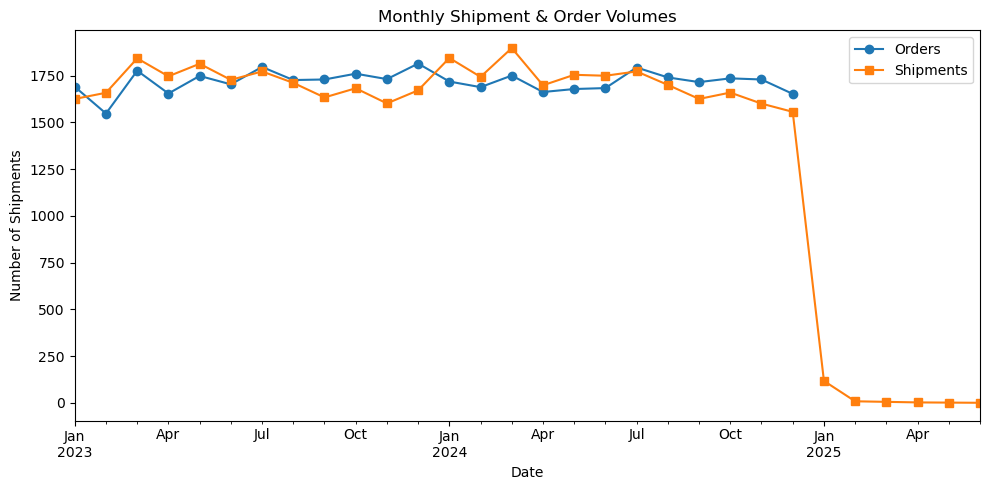

In [238]:
order_volume = shippment_data.groupby(shippment_data['order_date'].dt.to_period('M')).size()
ship_volume = shippment_data.groupby(shippment_data['ship_date'].dt.to_period('M')).size()

plt.figure(figsize=(10, 5))
order_volume.plot(label='Orders', marker='o')
ship_volume.plot(label='Shipments', marker='s')
plt.title("Monthly Shipment & Order Volumes")
plt.xlabel("Date")
plt.ylabel("Number of Shipments")
plt.legend()
plt.tight_layout()
plt.show()

*the dip at the end : we don't have data for Orders in January 2025, so it doesn't really count*

*we can see that there is fluctuations between the orders and shipments*

*-------------------------------------------------------*

<h3>Delivery delays</h3>

In [315]:
shippment_data['delivery_delay_days'] = (shippment_data['actual_delivery_date'] - shippment_data['planned_delivery_date']).dt.days
shippment_data['shiping_delay_days'] = (shippment_data['ship_date'] - shippment_data['order_date']).dt.days

In [309]:
del shippment_data['delivery_delay_days']

In [311]:
del shippment_data['shiping_delay_days']

In [324]:
shippment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42031 entries, 0 to 42030
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   shipment_id            42031 non-null  object        
 1   order_date             42031 non-null  datetime64[ns]
 2   ship_date              42031 non-null  datetime64[ns]
 3   planned_delivery_date  42031 non-null  datetime64[ns]
 4   actual_delivery_date   42031 non-null  datetime64[ns]
 5   origin                 42031 non-null  object        
 6   destination_city       42031 non-null  object        
 7   destination_region     42031 non-null  object        
 8   retailer               42031 non-null  object        
 9   retailer_store         42031 non-null  object        
 10  product                42031 non-null  object        
 11  product_code           42031 non-null  object        
 12  packaging              42031 non-null  object        
 13  q

<h3> delays </h3>

In [232]:
shippment_data['order_date'] = pd.to_datetime(shippment_data['order_date'], errors='coerce')
shippment_data['ship_date'] = pd.to_datetime(shippment_data['ship_date'], errors='coerce')

shippment_data['shiping_delay_days'] = (shippment_data['ship_date'] - shippment_data['order_date']).dt.days

In [293]:
shippment_data

shipment_id order_date  ship_date planned_delivery_date  \
0         S000001 2024-01-24 2024-01-31            2024-02-07   
1         S000002 2024-06-05 2024-06-09            2024-06-16   
2         S000003 2024-09-04 2024-09-07            2024-09-17   
3         S000005 2024-06-10 2024-06-16            2024-06-19   
4         S000007 2024-10-30 2024-11-03            2024-11-07   
...           ...        ...        ...                   ...   
42026     S033982 2023-06-12 2023-06-15            2023-06-20   
42027     S031261 2024-12-28 2024-12-29            2025-01-04   
42028     S012293 2024-01-31 2024-02-03            2024-02-10   
42029     S042287 2024-06-19 2024-06-25            2024-06-29   
42030     S013665 2023-08-06 2023-08-13            2023-08-18   

      actual_delivery_date                   origin destination_city  \
0               2024-02-10  Akola Plant, Casablanca          Tetouan   
1               2024-06-15  Akola Plant, Casablanca        Marrakech   
2               2024-09-16  Akola Plant, Casablanca       Casablanca   
3               2024-06-21  Akola Plant, Casablanca           Agadir   
4               2024-11-07  Akola Plant, Casablanca           Agadir   
...                    ...                      ...              ...   
42026           2023-06-19  Akola Plant, Casablanca              Fès   
42027           2025-01-03  Akola Plant, Casablanca          Tangier   
42028           2024-02-12  Akola Plant, Casablanca          Tetouan   
42029           2024-07-01  Akola Plant, Casablanca        Marrakech   
42030           2023-08-17  Akola Plant, Casablanca          Tetouan   

      destination_region       retailer    retailer_store  ...  \
0         Tanger-Tétouan      Label'Vie       Label'Vie_8  ...   
1                  Haouz  Aswak Assalam   Aswak Assalam_7  ...   
2             Casa-North            BIM             BIM_8  ...   
3                  Souss      Carrefour       Carrefour_2  ...   
4                  Souss        Marjane        Marjane_13  ...   
...                  ...            ...               ...  ...   
42026         Fès-Meknès      Label'Vie      Label'Vie_19  ...   
42027     Tanger-Tétouan            BIM            BIM_17  ...   
42028     Tanger-Tétouan  Aswak Assalam  Aswak Assalam_10  ...   
42029              Haouz        Marjane        Marjane_17  ...   
42030     Tanger-Tétouan      Label'Vie       Label'Vie_5  ...   

      weight_per_unit_kg total_weight_kg route_distance_km  transport_mode  \
0                   0.98          693.84               170             LTL   
1                   0.98          231.28               531             FTL   
2                   0.88          331.76               492             FTL   
3                   1.04          217.36               370             FTL   
4                   1.12          448.00                84             FTL   
...                  ...             ...               ...             ...   
42026               0.62          123.38               773             FTL   
42027               0.53          218.89               185             LTL   
42028               0.97          663.48               295             FTL   
42029               0.81          432.54               423             FTL   
42030               0.79          398.16               378             LTL   

        vehicle_type  temperature_control  transport_cost_mad     status  \
0       Semi-Trailer                False             1817.43  Cancelled   
1       Semi-Trailer                 True             4282.19    Delayed   
2              Rigid                False             3699.66  Cancelled   
3       Semi-Trailer                False             2894.38  Delivered   
4       Semi-Trailer                False             1165.76  Cancelled   
...              ...                  ...                 ...        ...   
42026          Rigid                False             5785.69  Cancelled   
42027          Rigid  

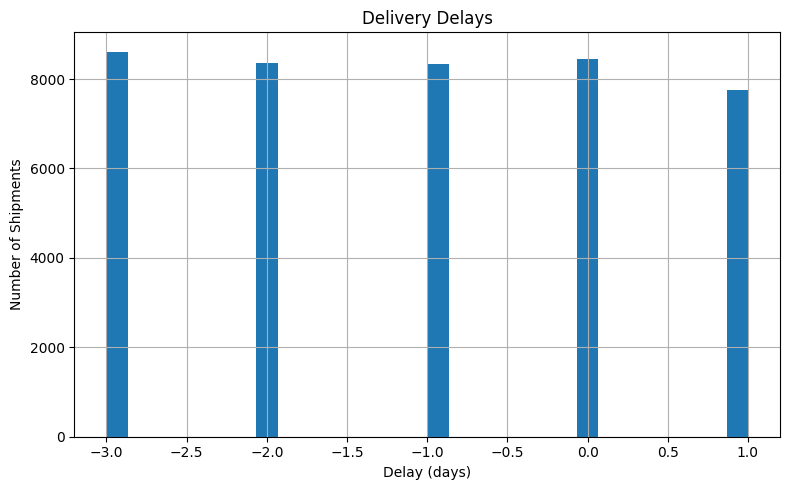

In [340]:
delivered = shippment_data[shippment_data['actual_delivery_date'].notna()]
reasonable_delays = delivered

plt.figure(figsize=(8, 5))
reasonable_delays['delay_days'].hist(bins=30)
plt.title("Delivery Delays")
plt.xlabel("Delay (days)")
plt.ylabel("Number of Shipments")
plt.grid(True)
plt.tight_layout()
plt.show()

*As we can see the majority of shipments were delayed between 0 to 3 days, with 1 day delay being the most commun one (more than 550 shipments)  

Each of these delay categories has around 500+ shipments, which means it's quite common for deliveries to be slightly delayed.  

A few shipments (almost 500) arrived sligghtly early (1 day early)  

The bars are relatively even across the 0–3 delay range, suggesting a stable but slightly delayed delivery trend.
*

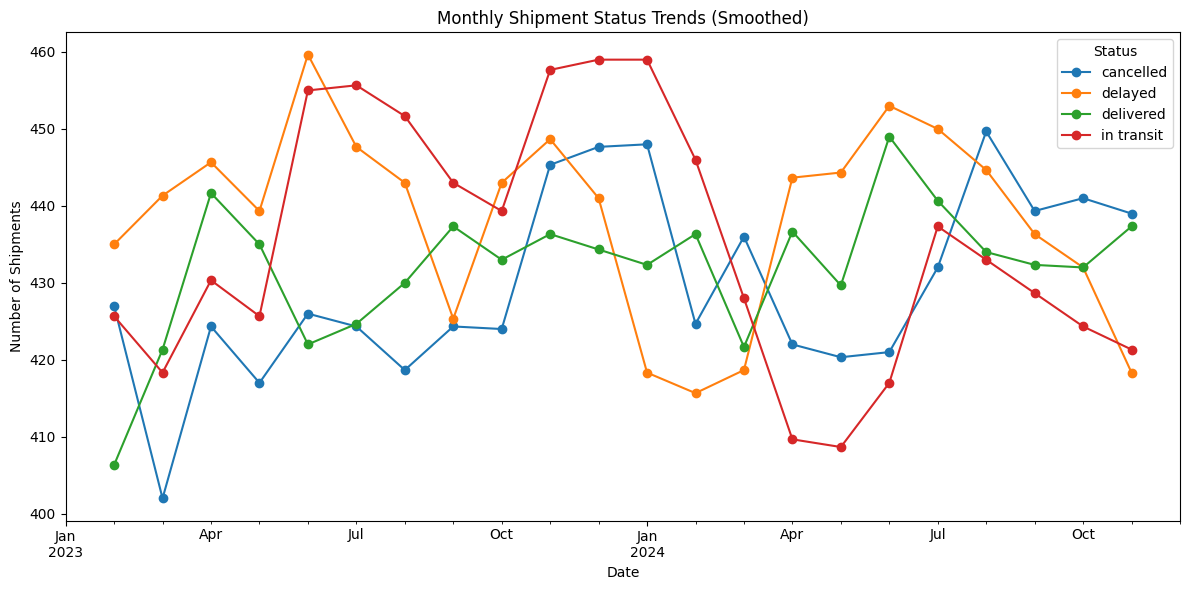

In [346]:
shippment_data['status'] = shippment_data['status'].str.strip().str.lower()

status_trend = shippment_data.groupby([shippment_data['order_date'].dt.to_period('M'), 'status']) \
                            .size().unstack(fill_value=0)

status_trend.index = status_trend.index.to_timestamp()

smoothed_trend = status_trend.rolling(window=3, center=True).mean()

smoothed_trend.plot(figsize=(12, 6), marker='o')
plt.title("Monthly Shipment Status Trends (Smoothed)")
plt.xlabel("Date")
plt.ylabel("Number of Shipments")
plt.legend(title='Status')
plt.tight_layout()
plt.show()

*Stable trends overall —> suggests operational consistency.

'Delivered' shipments are generally higher than 'cancelled' and stable, especially from Mar 2023 to Sep 2023.

'In Transit' and 'Delayed' occasionally peak above others (Dec 2023 to Jan 2024), maybe indicating operational or seasonal fluctuations.

'Cancelled' shipments drop around spring 2024, then rise again in mid-year.

The four status are pretty even — no dominant status consistently outpaces the others.*

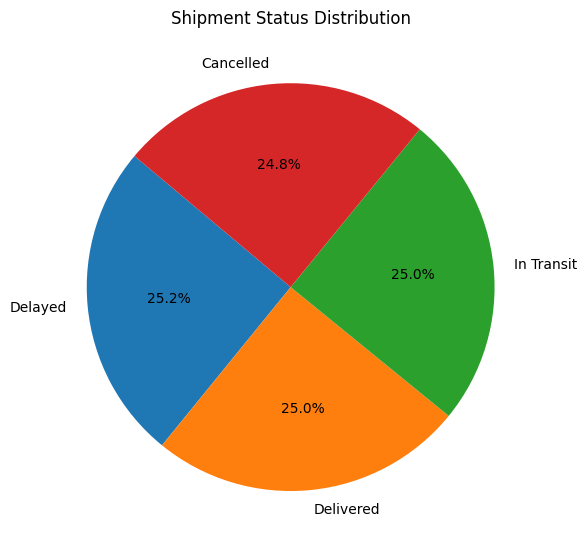

In [348]:
status_counts = no_shippment_data['status'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Shipment Status Distribution")
plt.tight_layout()
plt.show()

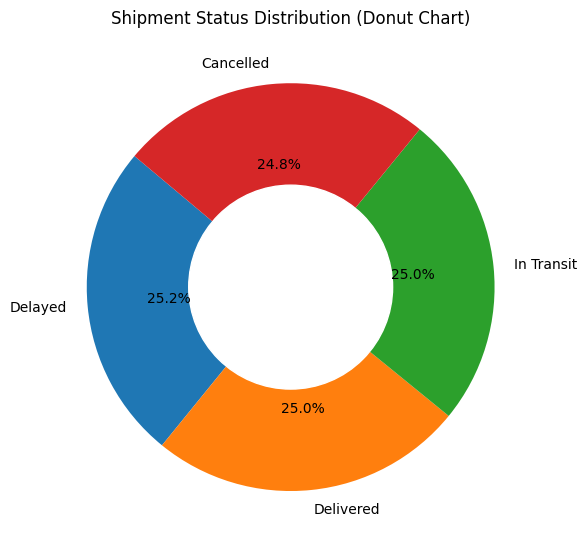

In [350]:
status_counts = no_shippment_data['status'].value_counts()
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=140
)
plt.gca().add_artist(plt.Circle((0, 0), 0.5, color='white'))
plt.title("Shipment Status Distribution (Donut Chart)")
plt.tight_layout()
plt.show()

*This tells us that no status dominates the shipment flow*

In [354]:
shippment_data['delivery_timing'] = shippment_data.apply(
    lambda row: (
        'early' if row['actual_delivery_date'] < row['planned_delivery_date']
        else 'on-time' if row['actual_delivery_date'] == row['planned_delivery_date']
        else 'delayed'
    ), axis=1
)


In [356]:
delivery_summary = shippment_data.groupby([
    shippment_data['planned_delivery_date'].dt.to_period('M'),
    'delivery_timing'
]).size().unstack(fill_value=0)

delivery_rate = delivery_summary.div(delivery_summary.sum(axis=1), axis=0)

delivery_rate.index = delivery_rate.index.to_timestamp()

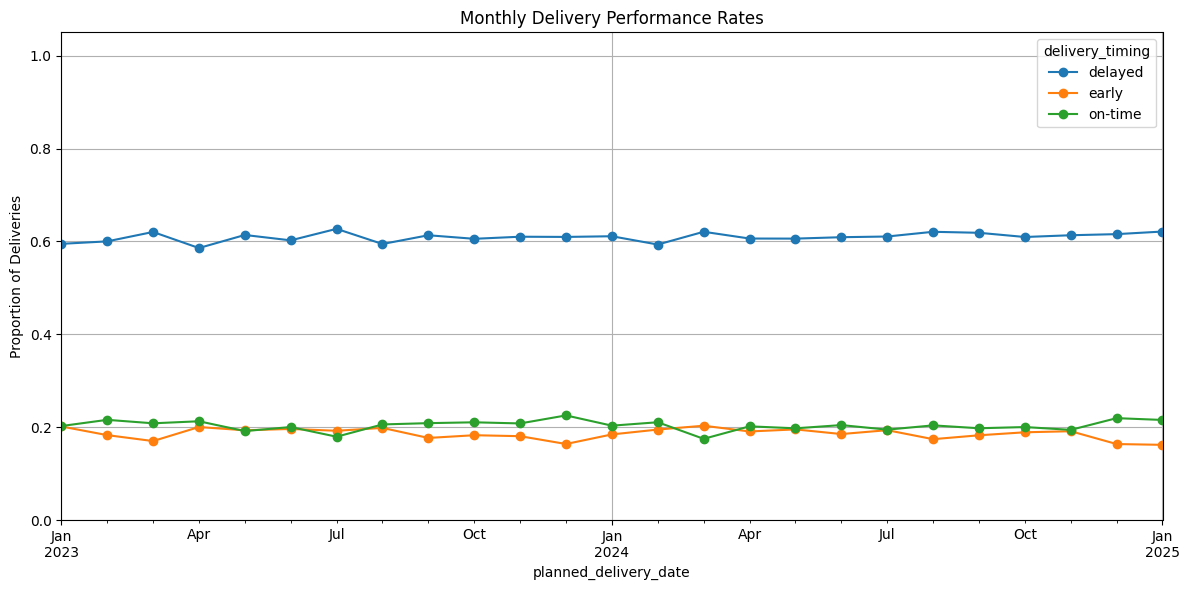

In [358]:
delivery_rate.plot(marker='o', figsize=(12, 6), title="Monthly Delivery Performance Rates")
plt.ylabel("Proportion of Deliveries")
plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()
plt.show()

<h3>Status Trends by Region, Truck, or Client</h3>

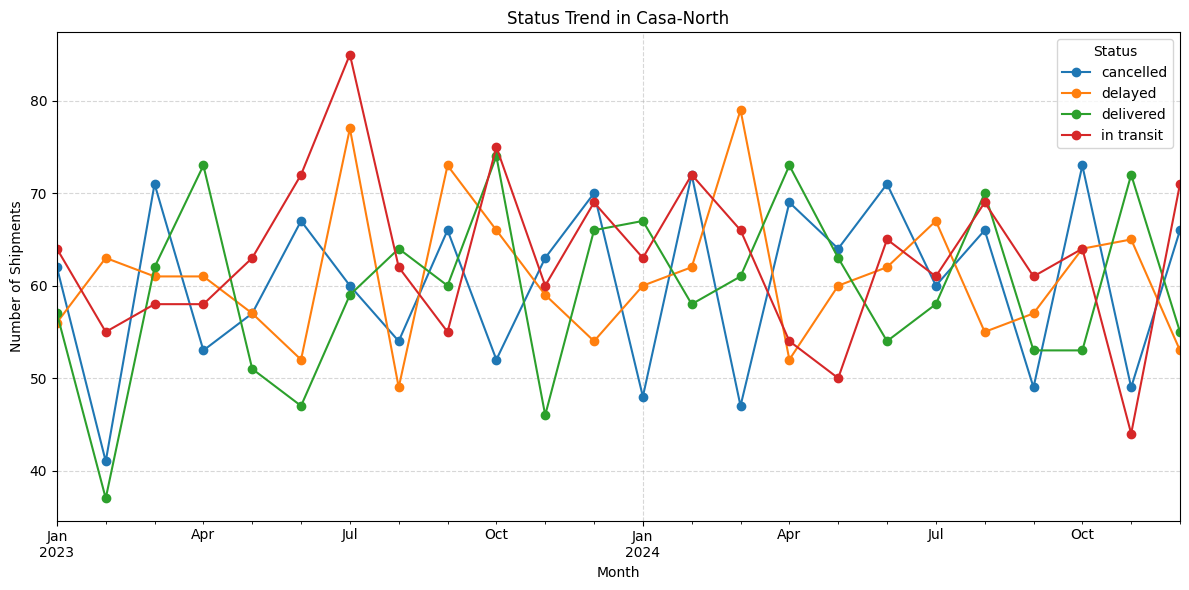

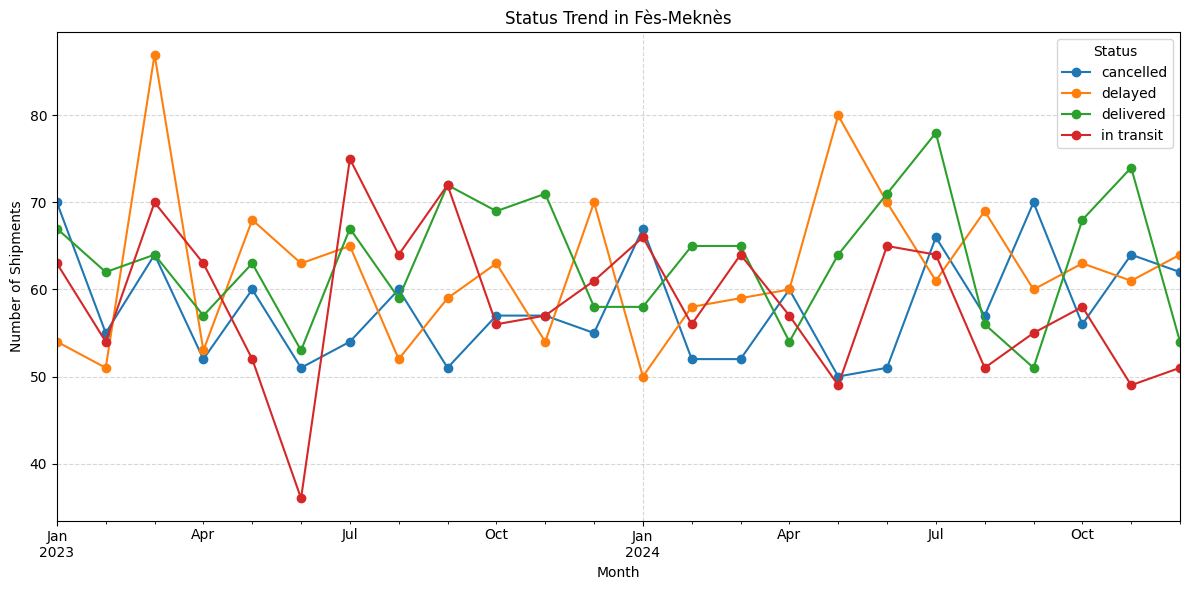

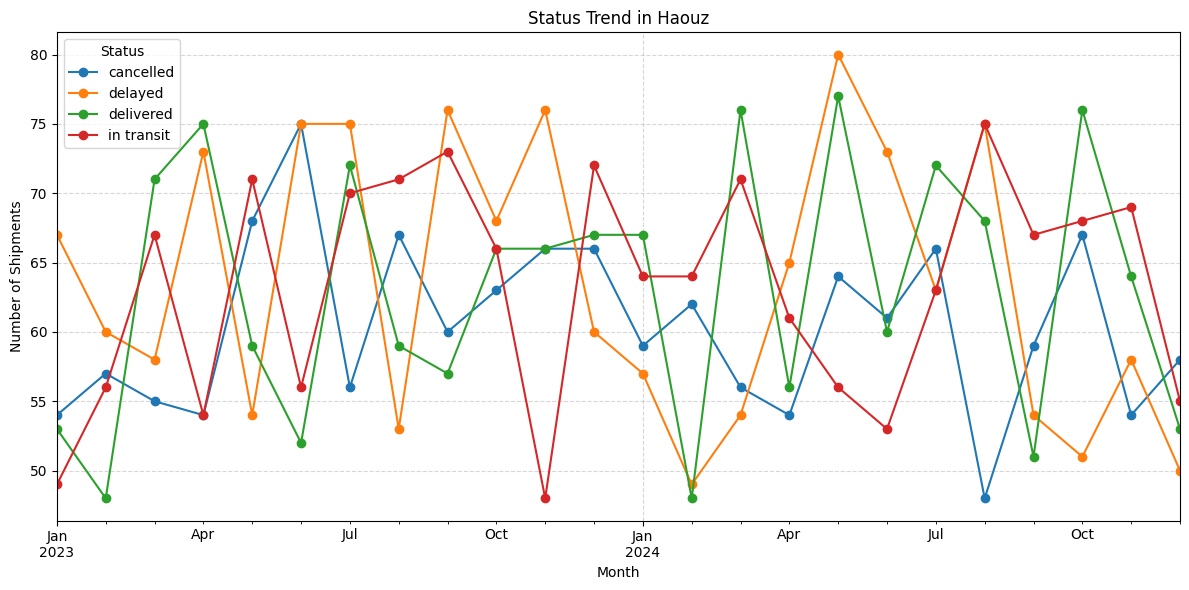

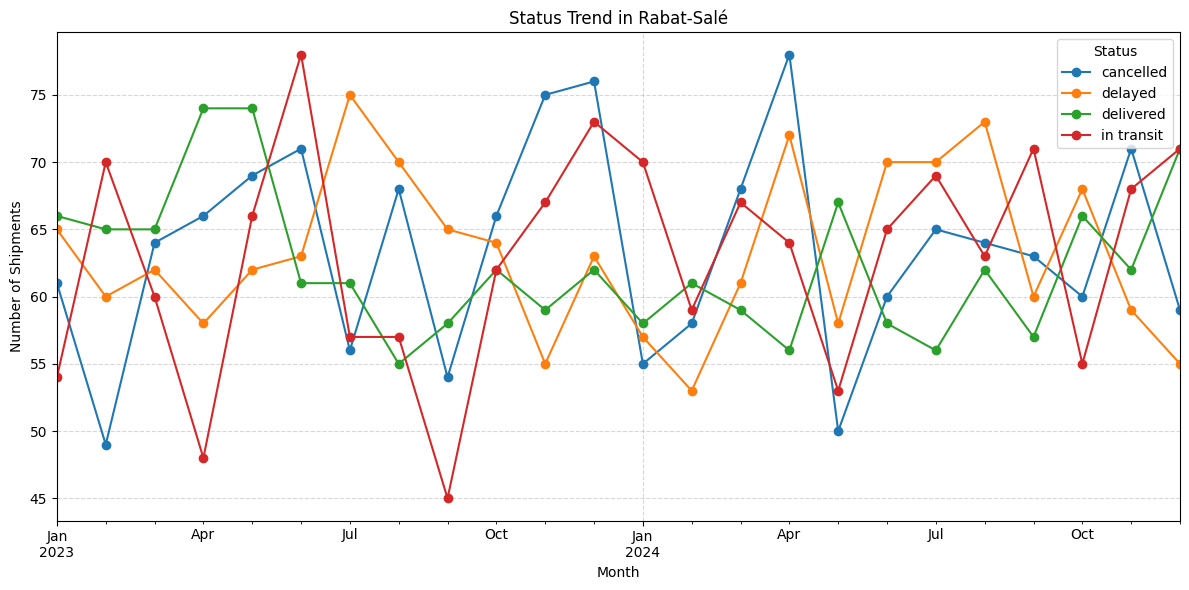

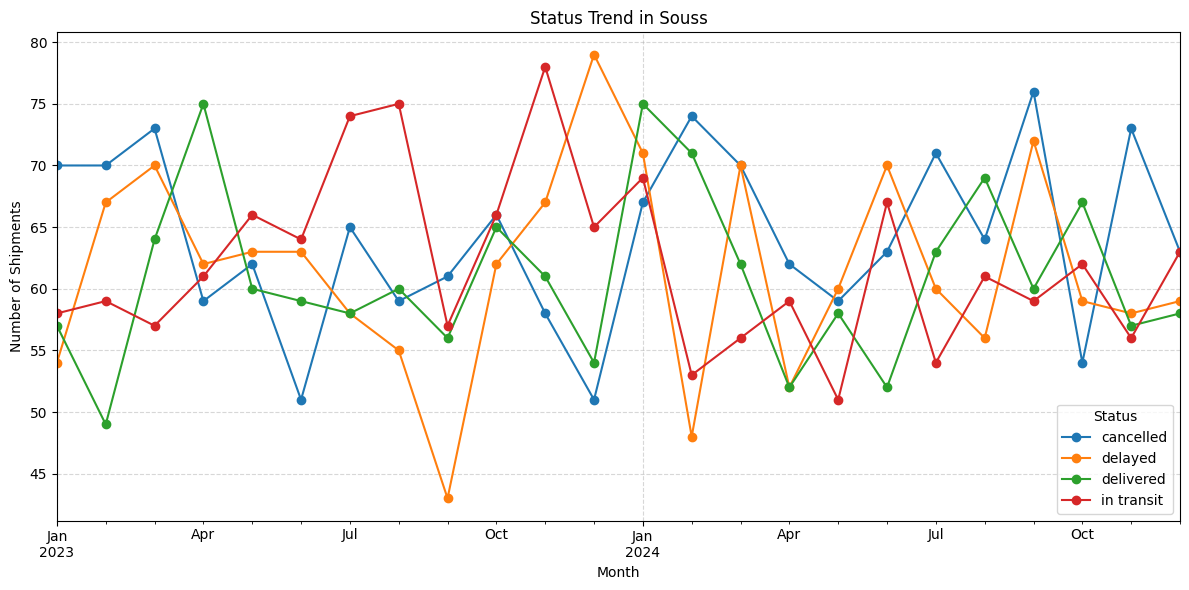

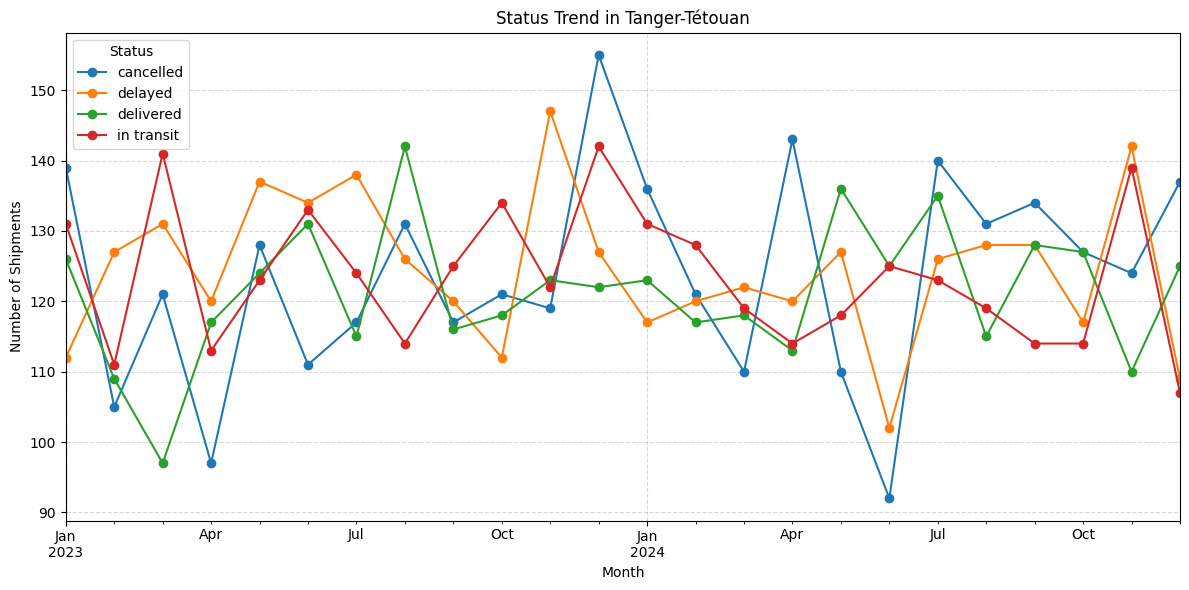

In [42]:
status_region = shippment_data.groupby([
    shippment_data['order_date'].dt.to_period('M'),
    'destination_region',
    'status'
]).size().unstack(fill_value=0)

status_region.index = status_region.index.set_levels(
    status_region.index.levels[0].to_timestamp(), level=0
)

regions = [
    'Casa-North', 'Fès-Meknès', 'Haouz',
    'Rabat-Salé', 'Souss', 'Tanger-Tétouan'
]

for region in regions:
    region_trend = status_region.xs(region, level=1)
    region_trend.plot(figsize=(12, 6), marker='o', title=f"Status Trend in {region}")
    plt.xlabel('Month')
    plt.ylabel('Number of Shipments')
    plt.legend(title='Status')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

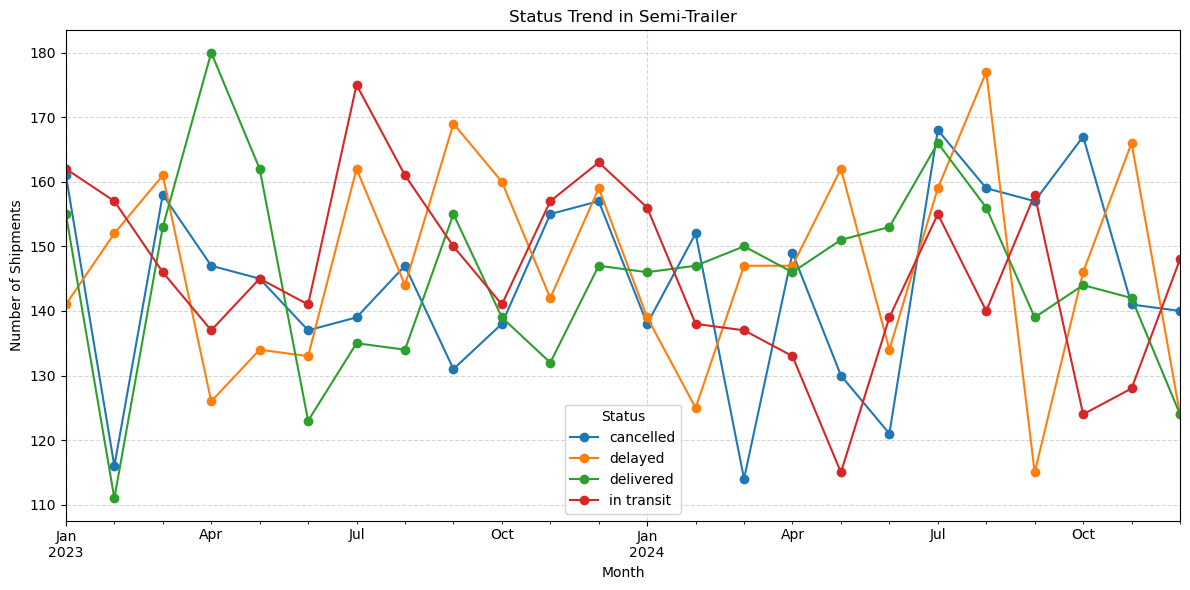

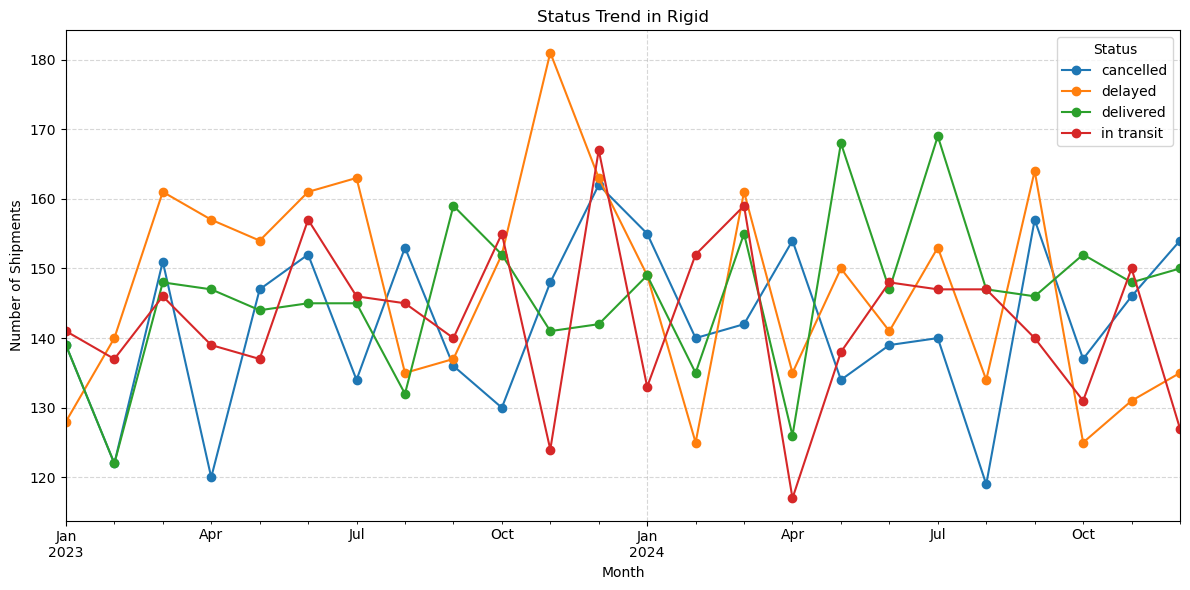

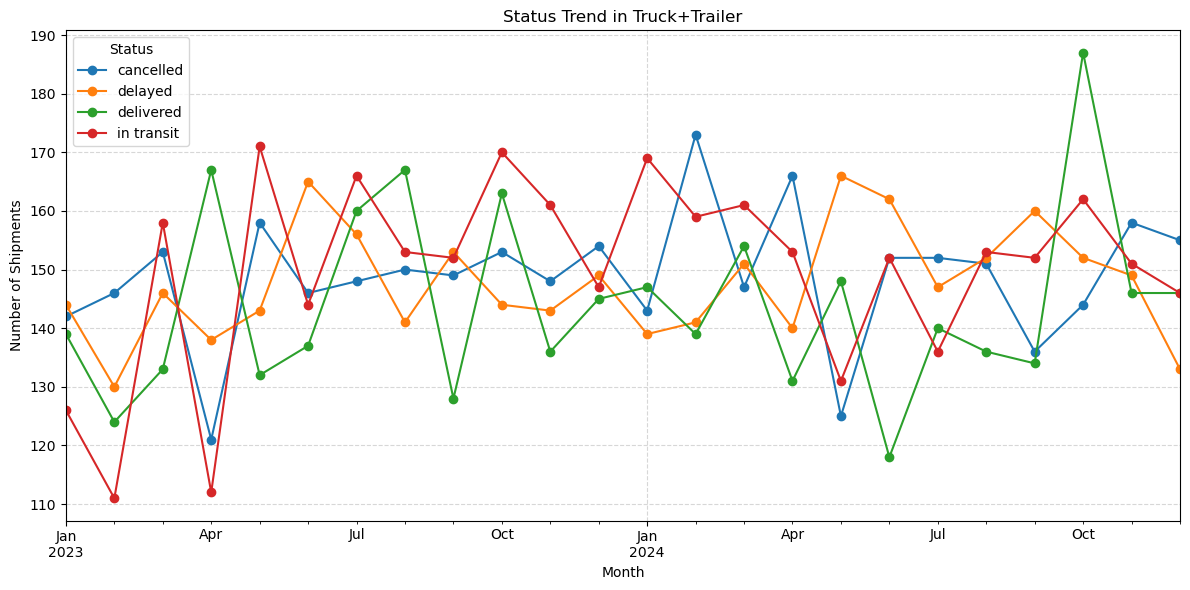

In [133]:
status_vtype = shippment_data.groupby([
    shippment_data['order_date'].dt.to_period('M'),
    'vehicle_type',
    'status'
]).size().unstack(fill_value=0)

status_vtype.index = status_vtype.index.set_levels(
    status_vtype.index.levels[0].to_timestamp(), level=0
)

vtypes = [
    'Semi-Trailer', 'Rigid', 'Truck+Trailer',
]

for vtype in vtypes:
    vtype_trend = status_vtype.xs(vtype, level=1)
    vtype_trend.plot(figsize=(12, 6), marker='o', title=f"Status Trend in {vtype}")
    plt.xlabel('Month')
    plt.ylabel('Number of Shipments')
    plt.legend(title='Status')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

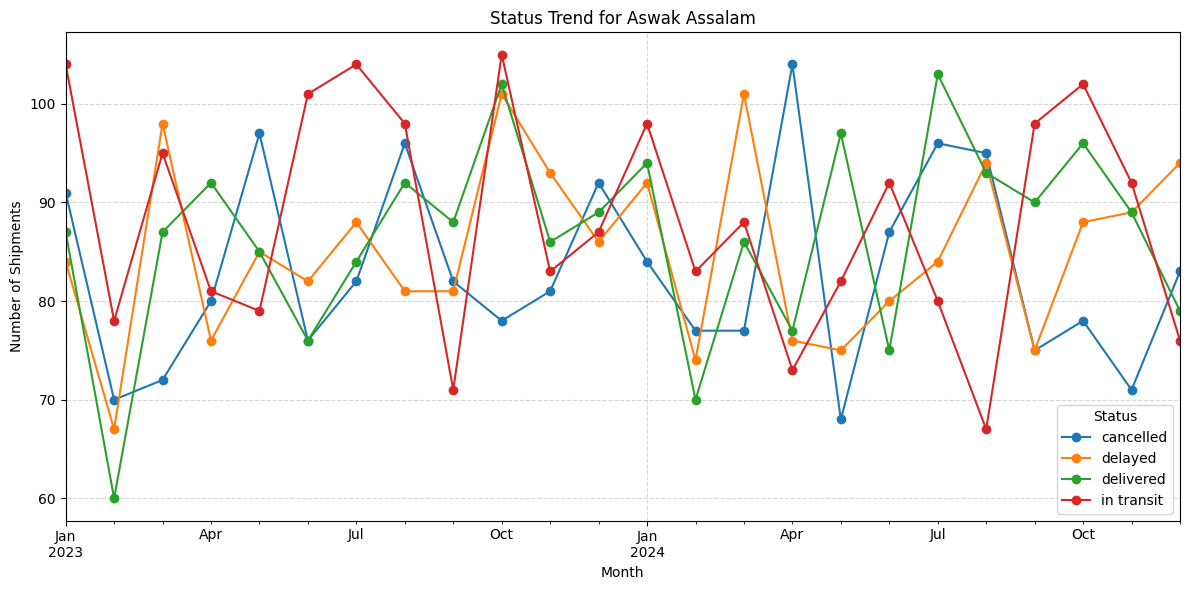

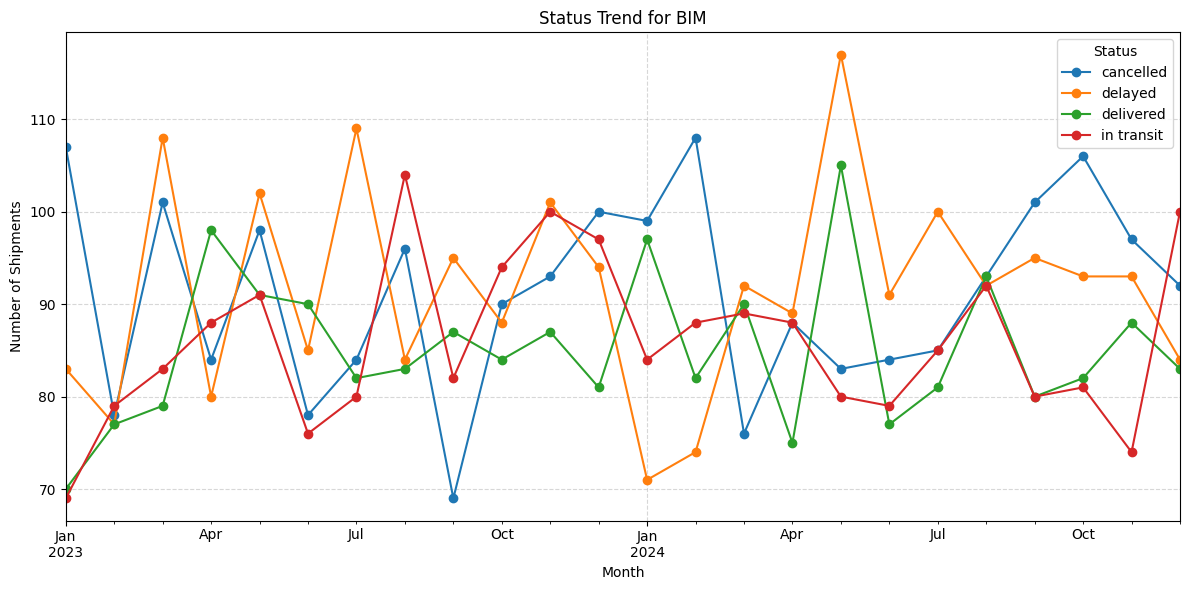

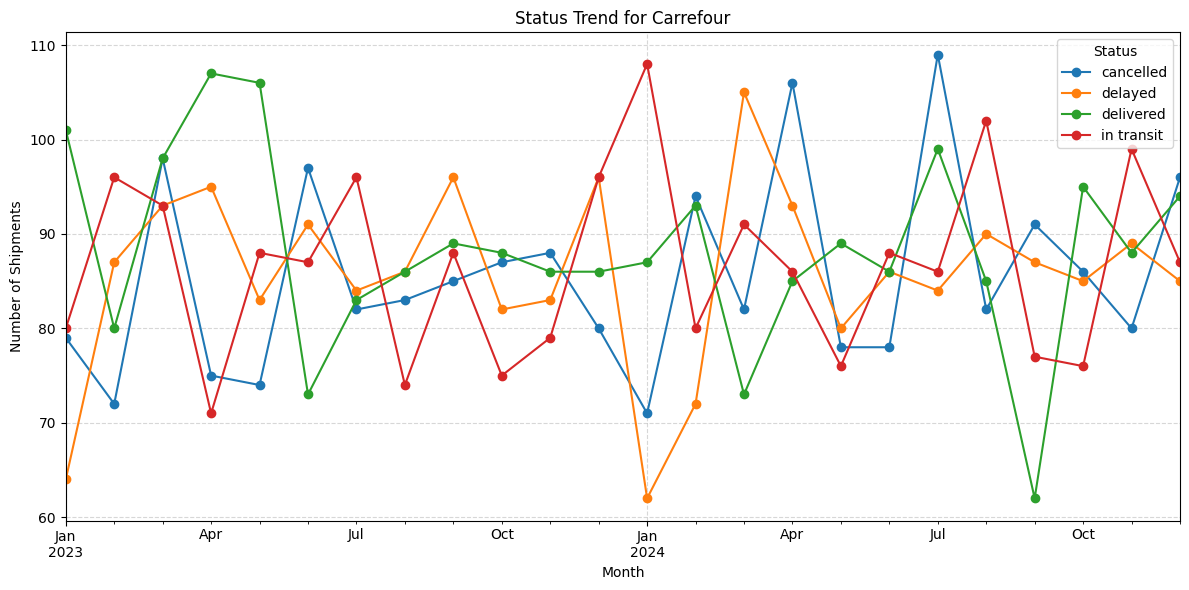

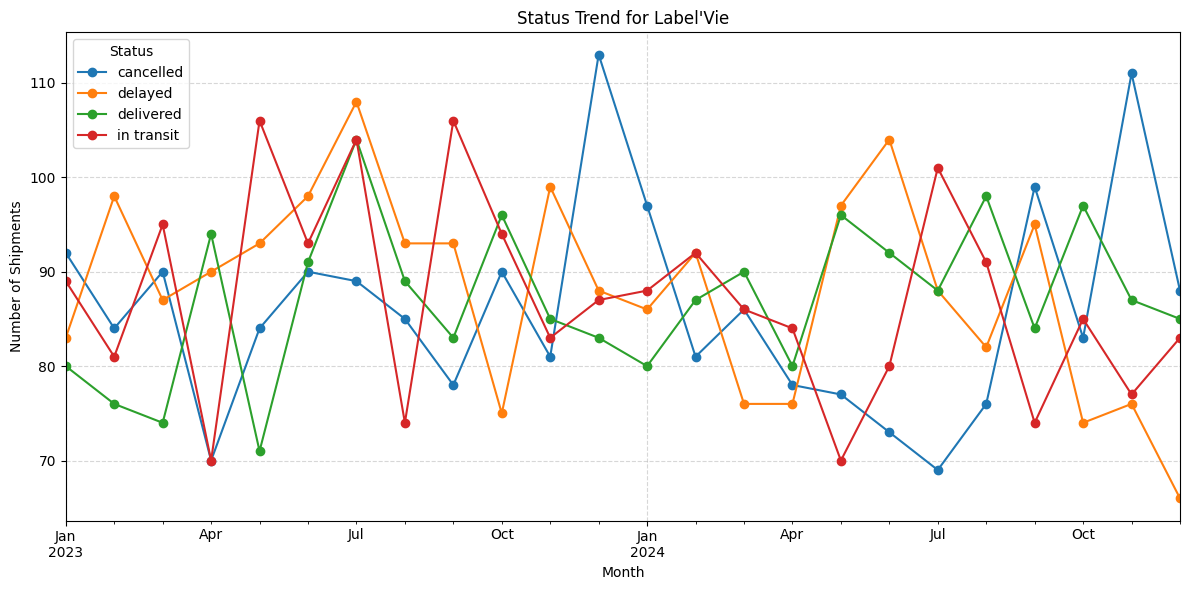

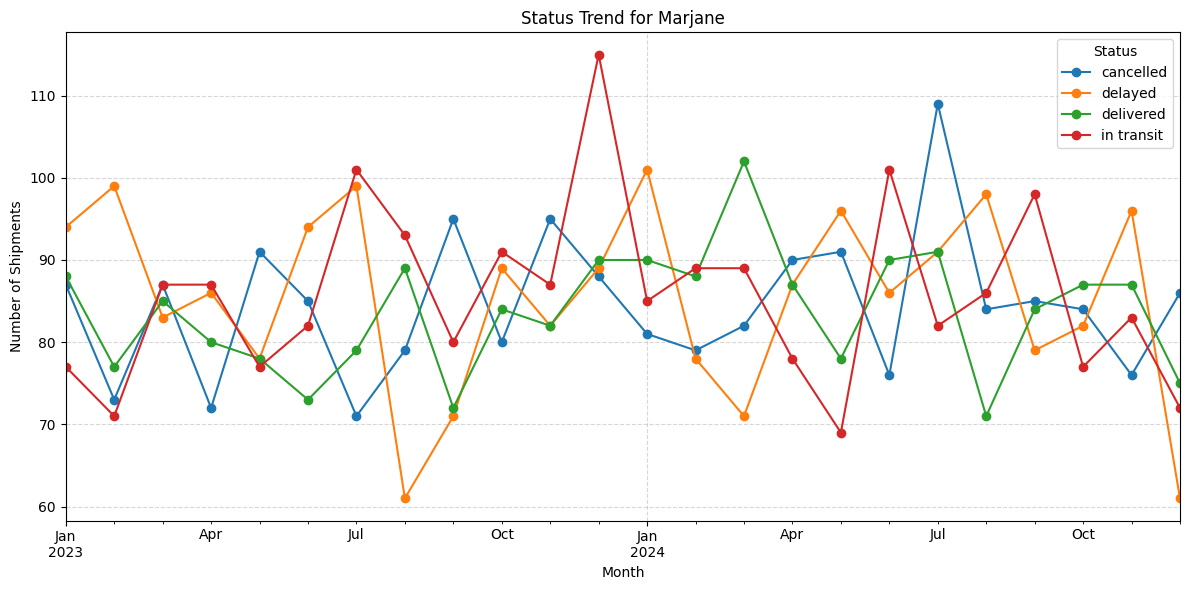

In [368]:
status_retailer = shippment_data.groupby([
    shippment_data['order_date'].dt.to_period('M'),
    'retailer',
    'status'
]).size().unstack(fill_value=0)

status_retailer.index = status_retailer.index.set_levels(
    status_retailer.index.levels[0].to_timestamp(), level=0
)

retailers = ['Aswak Assalam', 'BIM', 'Carrefour', "Label'Vie", 'Marjane']

for retailer in retailers:
    retailer_trend = status_retailer.xs(retailer, level=1)
    retailer_trend.plot(figsize=(12, 6), marker='o', title=f"Status Trend for {retailer}")
    plt.xlabel('Month')
    plt.ylabel('Number of Shipments')
    plt.legend(title='Status')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [370]:
shippment_data['order_date'] = pd.to_datetime(shippment_data['order_date'], errors='coerce')
shippment_data['planned_delivery_date'] = pd.to_datetime(shippment_data['planned_delivery_date'], errors='coerce')
shippment_data['actual_delivery_date'] = pd.to_datetime(shippment_data['actual_delivery_date'], errors='coerce')


shippment_data['delivery_timing'] = shippment_data.apply(
    lambda row: (
        'early' if pd.notnull(row['actual_delivery_date']) and pd.notnull(row['planned_delivery_date']) and row['actual_delivery_date'] < row['planned_delivery_date']
        else 'on-time' if pd.notnull(row['actual_delivery_date']) and pd.notnull(row['planned_delivery_date']) and row['actual_delivery_date'] == row['planned_delivery_date']
        else 'delayed' if pd.notnull(row['actual_delivery_date']) and pd.notnull(row['planned_delivery_date']) and row['actual_delivery_date'] > row['planned_delivery_date']
        else 'unknown'
    ), axis=1
)

spike_month = '2024-07'
spike_data = shippment_data[
    (shippment_data['order_date'].dt.to_period('M') == spike_month) &
    (shippment_data['status'].isin(['delayed', 'cancelled']))
]

retailer_summary = spike_data['retailer'].value_counts()
vehicle_summary = spike_data['vehicle_type'].value_counts()
route_summary = spike_data.groupby(['origin', 'destination_city']).size().sort_values(ascending=False)

spike_delivery_perf = spike_data['delivery_timing'].value_counts(normalize=True).to_frame(name='rate')

print(spike_delivery_perf)

                     rate
delivery_timing          
delayed          0.608743
on-time          0.202186
early            0.189071


<h2>Geographical Visiualization</h2>

<h3> Top 10 Cities by Shipment Counts and Total Transport Cost</h3>

                                     shipment_count  transport_cost_mad
destination_region destination_city                                    
Rabat-Salé         Rabat                       6639         22612800.34
Haouz              Marrakech                   6630         22668829.30
Tanger-Tétouan     Tangier                     6604         22454949.14
Souss              Agadir                      6528         22208023.50
Tanger-Tétouan     Tetouan                     6399         21709593.17
Fès-Meknès         Fès                         6370         21850662.48
Casa-North         Casablanca                  6369         21562824.52


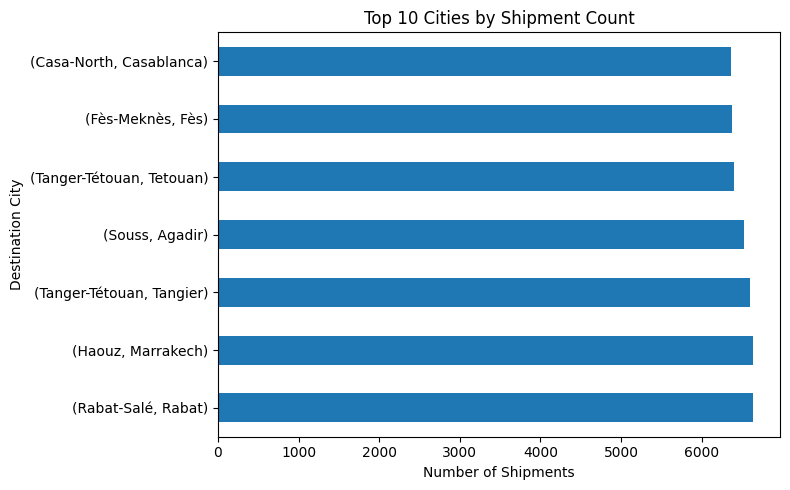

In [372]:
city_region_summary = no_shippment_data.groupby(['destination_region', 'destination_city']).agg({
    'shipment_id': 'count',
    'transport_cost_mad': 'sum'
}).rename(columns={'shipment_id': 'shipment_count'})

city_region_summary = city_region_summary.sort_values(by='shipment_count', ascending=False)

print(city_region_summary.head(10))

top_cities = city_region_summary.head(10)

top_cities['shipment_count'].plot(kind='barh', figsize=(8, 5), title='Top 10 Cities by Shipment Count')
plt.xlabel("Number of Shipments")
plt.ylabel("Destination City")
plt.tight_layout()
plt.show()

<h3>Distance Patterns by Route </h3>

                                      shipment_count  avg_distance_km  \
route                                                                   
Akola Plant, Casablanca → Rabat                 6639       426.406236   
Akola Plant, Casablanca → Marrakech             6630       427.848567   
Akola Plant, Casablanca → Tangier               6604       425.413992   
Akola Plant, Casablanca → Agadir                6528       425.598958   
Akola Plant, Casablanca → Tetouan               6399       424.481013   
Akola Plant, Casablanca → Fès                   6370       429.395761   
Akola Plant, Casablanca → Casablanca            6369       423.650495   

                                      min_distance_km  max_distance_km  
route                                                                   
Akola Plant, Casablanca → Rabat                    50              799  
Akola Plant, Casablanca → Marrakech                50              799  
Akola Plant, Casablanca → Tangier                 

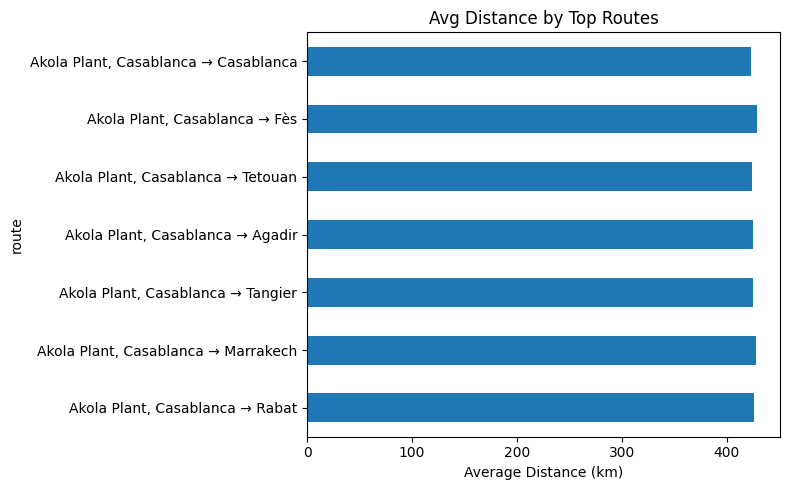

In [374]:
no_shippment_data['route'] = no_shippment_data['origin'] + ' → ' + no_shippment_data['destination_city']

route_stats = no_shippment_data.groupby('route').agg({
    'route_distance_km': ['count', 'mean', 'min', 'max']
})

route_stats.columns = ['shipment_count', 'avg_distance_km', 'min_distance_km', 'max_distance_km']
route_stats = route_stats.sort_values(by='shipment_count', ascending=False)

print(route_stats.head(10))

top_routes = route_stats.head(10)

top_routes['avg_distance_km'].plot(kind='barh', figsize=(8, 5), title='Avg Distance by Top Routes')
plt.xlabel("Average Distance (km)")
plt.tight_layout()
plt.show()

<h2>Product-Level</h2>

<h3>Most shipped products</h3>

product  product_code
Orange   A002            9237
Energy   A005            9205
Lemon    A003            9142
Cola     A001            8984
Zero     A004            8971
dtype: int64


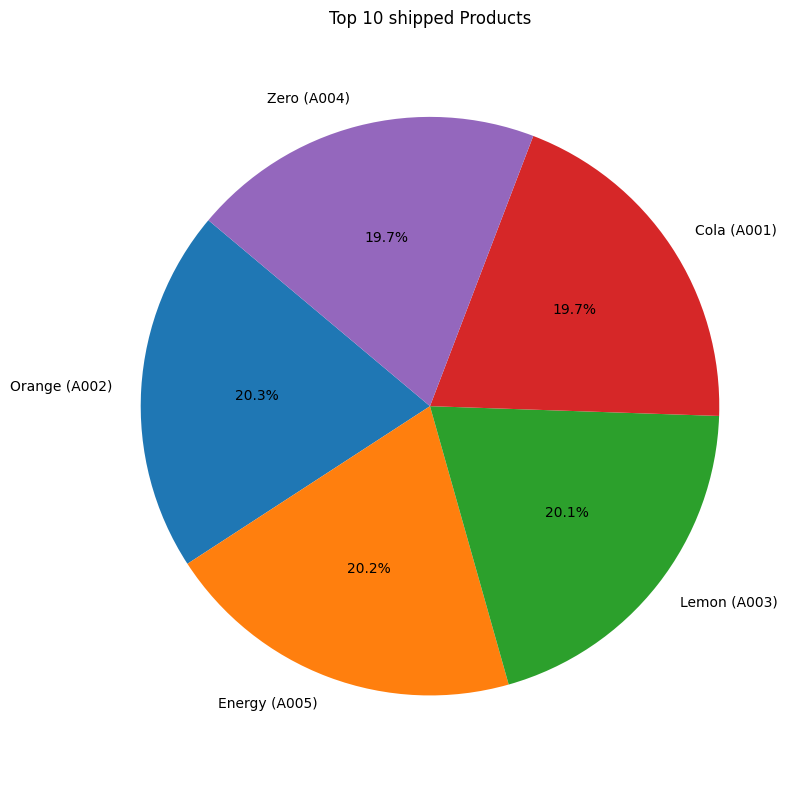

In [376]:
product_counts = no_shippment_data.groupby(['product', 'product_code']).size().sort_values(ascending=False)
print(product_counts.head(10))

top_products = product_counts.head(10)
labels = [f"{prod[0]} ({prod[1]})" for prod in top_products.index]

plt.figure(figsize=(8, 8))
plt.pie(top_products, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Top 10 shipped Products")
plt.axis('equal')  # Keep the pie chart circular
plt.tight_layout()
plt.show()

<h3>Volume & Revenue Contribution Per Product</h3>

In [378]:
product_metrics = no_shippment_data.groupby(['product', 'product_code']).agg({
    'quantity_units': 'sum',
    'order_value_mad': 'sum'
}).rename(columns={
    'quantity_units': 'total_units',
    'order_value_mad': 'total_revenue_mad'
}).sort_values(by='total_units', ascending=False)

print(product_metrics.head(10))

                      total_units  total_revenue_mad
product product_code                                
Orange  A002              5073685        27969642.77
Energy  A005              5055659        27880075.53
Lemon   A003              5047199        27779080.75
Cola    A001              5003508        27600273.07
Zero    A004              4939370        27061623.06


In [382]:
product_metrics['volume_pct'] = product_metrics['total_units'] / product_metrics['total_units'].sum()
product_metrics['revenue_pct'] = product_metrics['total_revenue_mad'] / product_metrics['total_revenue_mad'].sum()
print(product_metrics.head(10))

                      total_units  total_revenue_mad  volume_pct  revenue_pct
product product_code                                                         
Orange  A002              5073685        27969642.77    0.201983     0.202253
Energy  A005              5055659        27880075.53    0.201265     0.201605
Lemon   A003              5047199        27779080.75    0.200928     0.200875
Cola    A001              5003508        27600273.07    0.199189     0.199582
Zero    A004              4939370        27061623.06    0.196636     0.195687


<h3>Weight-to-Cost Efficiency</h3>

In [384]:
no_shippment_data['weight_cost_ratio'] = no_shippment_data['total_weight_kg'] / no_shippment_data['transport_cost_mad']

efficiency_by_product = no_shippment_data.groupby(['product', 'product_code'])['weight_cost_ratio'].mean().sort_values(ascending=False)
print(efficiency_by_product.head(10))

product  product_code
Orange   A002            0.184445
Energy   A005            0.183867
Lemon    A003            0.183498
Zero     A004            0.182974
Cola     A001            0.182456
Name: weight_cost_ratio, dtype: float64


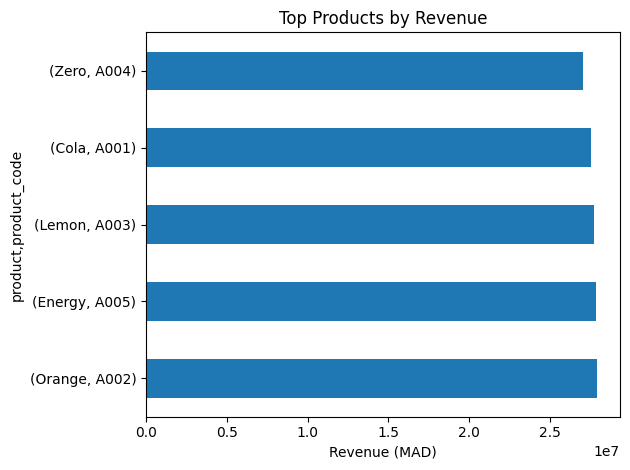

In [386]:
product_metrics.sort_values(by='total_revenue_mad', ascending=False).head(10)['total_revenue_mad'].plot(kind='barh', title="Top Products by Revenue")
plt.xlabel("Revenue (MAD)")
plt.tight_layout()
plt.show()

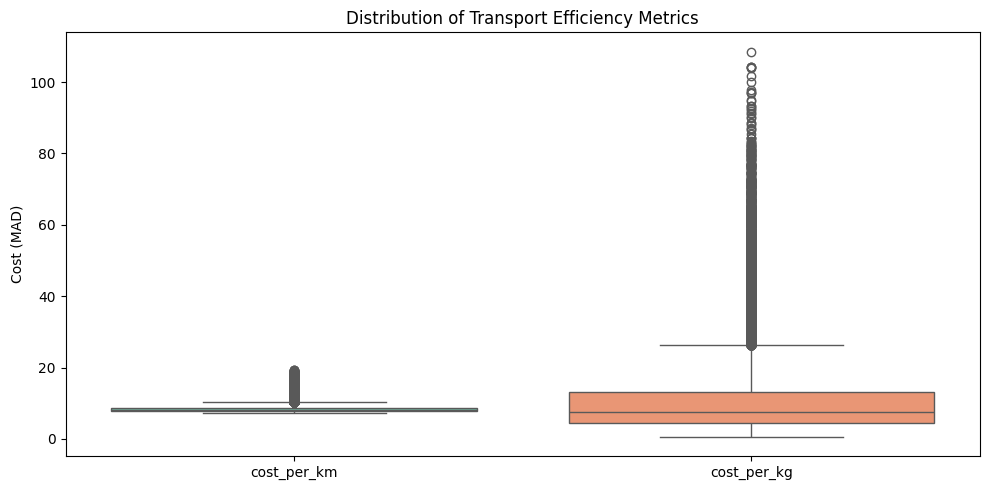

In [388]:
no_shippment_data['cost_per_km'] = no_shippment_data['transport_cost_mad'] / no_shippment_data['route_distance_km']
no_shippment_data['cost_per_kg'] = no_shippment_data['transport_cost_mad'] / no_shippment_data['total_weight_kg']

cleaned = no_shippment_data.replace([float('inf'), -float('inf')], pd.NA).dropna(subset=['cost_per_km', 'cost_per_kg'])

plt.figure(figsize=(10, 5))
sns.boxplot(data=cleaned[['cost_per_km', 'cost_per_kg']], palette='Set2')
plt.title("Distribution of Transport Efficiency Metrics")
plt.ylabel("Cost (MAD)")
plt.tight_layout()
plt.show()

__cost_per_km:__  
Median is around 9 MAD/km  
The distribution is tight and consistent — very few outliers.  
Most values fall within ~7 to 11 MAD/km  
This suggests the cost per km is well-controlled across your deliveries.  

__cost_per_kg:__  
Much more spread out than cost_per_km.  
Median is around 6 MAD/kg, but the upper whisker goes as high as ~20 MAD/kg.  
Many outliers reaching up to over 100 MAD/kg!  
That means some deliveries are extremely inefficient per kilogram — likely due to light loads or short distances.

cost per kg has many extreme values — this likely reflects inefficient loads (e.g., small weight, high distance).

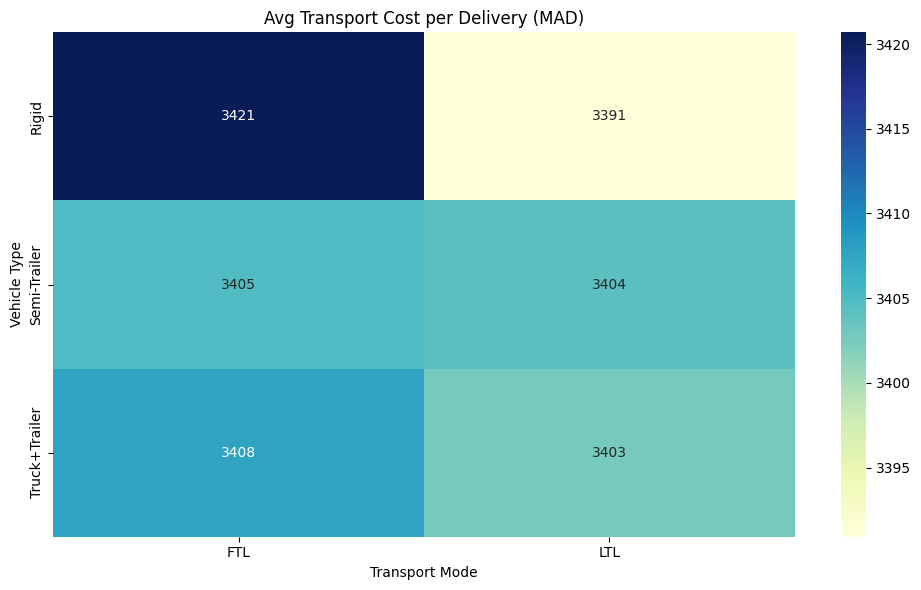

In [391]:
grouped_costs = no_shippment_data.groupby(['vehicle_type', 'transport_mode'])['transport_cost_mad'].mean().unstack()

# Heatmap for clarity
plt.figure(figsize=(10, 6))
sns.heatmap(grouped_costs, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Avg Transport Cost per Delivery (MAD)")
plt.ylabel("Vehicle Type")
plt.xlabel("Transport Mode")
plt.tight_layout()
plt.show()

**Rigid truck**s show the **most variation between FTL and LTL costs** it is still just 30MAD per Delivery, but 30 times Monthly shipments is a big number → investigate whether FTL trips are underloaded.

**Semi-Trailer** and **Truck+Trailer** are more **cost-consistent across modes**.

**Average cost** differences are small (~30 MAD max) — but **over hundreds of trips, they can add up.**

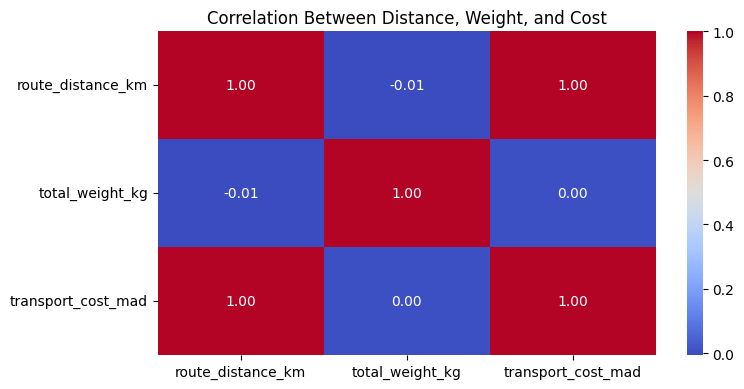

In [58]:
corr_df = no_shippment_data[['route_distance_km', 'total_weight_kg', 'transport_cost_mad']]

corr = corr_df.corr()

plt.figure(figsize=(8, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Distance, Weight, and Cost")
plt.tight_layout()
plt.show()

<h2>KPI</h2>

In [5]:
no_shippment_data['cost_per_km'] = no_shippment_data['transport_cost_mad'] / no_shippment_data['route_distance_km']
no_shippment_data['cost_per_kg'] = no_shippment_data['transport_cost_mad'] / no_shippment_data['total_weight_kg']
no_shippment_data['route'] = no_shippment_data['origin'] + " → " + no_shippment_data['destination_city']

no_shippment_data = no_shippment_data.replace([float('inf'), -float('inf')], pd.NA)
no_shippment_data = no_shippment_data.dropna(subset=['cost_per_km', 'cost_per_kg', 'vehicle_type'])

vehicle_kpis = no_shippment_data.groupby('vehicle_type').agg({
    'shipment_id': 'count',
    'transport_cost_mad': 'mean',
    'total_weight_kg': 'mean',
    'route_distance_km': 'mean'
}).rename(columns={
    'shipment_id': 'num_shipments',
    'transport_cost_mad': 'avg_cost',
    'total_weight_kg': 'avg_weight',
    'route_distance_km': 'avg_distance'
})

vehicle_kpis['cost_per_kg'] = vehicle_kpis['avg_cost'] / vehicle_kpis['avg_weight']
vehicle_kpis['cost_per_km'] = vehicle_kpis['avg_cost'] / vehicle_kpis['avg_distance']
vehicle_kpis = vehicle_kpis.round(2)

km_thresh = no_shippment_data['cost_per_km'].quantile(0.90)
kg_thresh = no_shippment_data['cost_per_kg'].quantile(0.90)

inefficient_routes = no_shippment_data[
    (no_shippment_data['cost_per_km'] > km_thresh) | (no_shippment_data['cost_per_kg'] > kg_thresh)
]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=no_shippment_data, x='cost_per_km', y='cost_per_kg', alpha=0.3, label='All Deliveries'
)
sns.scatterplot(
    data=inefficient_routes, x='cost_per_km', y='cost_per_kg', color='red', label='Inefficient'
)
plt.axvline(km_thresh, color='orange', linestyle='--', label='90th % cost/km')
plt.axhline(kg_thresh, color='blue', linestyle='--', label='90th % cost/kg')
plt.title("Inefficient Deliveries: Cost per km vs Cost per kg")
plt.xlabel("Cost per km (MAD)")
plt.ylabel("Cost per kg (MAD)")
plt.legend()
plt.tight_layout()
plt.show()

cols_to_export = [
    'shipment_id', 'vehicle_type', 'transport_mode', 'route',
    'route_distance_km', 'total_weight_kg', 'transport_cost_mad',
    'cost_per_km', 'cost_per_kg'
]
underperforming_rows = inefficient_routes[cols_to_export]

underperforming_rows.to_csv("underperforming_deliveries.csv", index=False)


NameError: name 'no_shippment_data' is not defined

The top left quadrant (high cost per kg, low km) suggests:    

  **Possibility of underloaded trucks (lightweight but costly trips)**  

The bottom right quadrant (high cost per km, low kg) suggests:    

  Longer trips that aren't cost-efficient per km **(e.g., bad routing or backhauling)** 

The dense red center shows clustered inefficiencies — common pain points

<h3>Top 5 Worst Deliveries by cost_per_km:</h3>

In [398]:
top5_cost_per_km = underperforming_rows.sort_values(by='cost_per_km', ascending=False).head(5)
top5_cost_per_km

shipment_id   vehicle_type transport_mode  \
17005     S019044  Truck+Trailer            FTL   
7769      S008692   Semi-Trailer            LTL   
22008     S024651   Semi-Trailer            FTL   
15131     S016956  Truck+Trailer            FTL   
5697      S006387   Semi-Trailer            FTL   

                                     route  route_distance_km  \
17005      Akola Plant, Casablanca → Rabat                 50   
7769   Akola Plant, Casablanca → Marrakech                 50   
22008    Akola Plant, Casablanca → Tetouan                 51   
15131  Akola Plant, Casablanca → Marrakech                 50   
5697     Akola Plant, Casablanca → Tetouan                 53   

       total_weight_kg  transport_cost_mad  cost_per_km  cost_per_kg  
17005          1097.79              965.46    19.309200     0.879458  
7769            620.80              959.05    19.181000     1.544861  
22008           627.12              977.91    19.174706     1.559367  
15131           936.60              955.27    19.105400     1.019934  
5697           1027.04             1012.04    19.095094     0.985395

All are short-distance trips (~50 km) — this inflates cost/km.

Weight varies between ~820–1100 kg, suggesting not fully loaded capacity.

Vehicle types (Semi-Trailer, Truck+Trailer) may be oversized for these short trips, worsening cost-efficiency.  

C:\Users\hp\AppData\Local\Temp\ipykernel_10232\583029002.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=route_ranking, x='cost_per_km', y='route', palette='Reds_r')


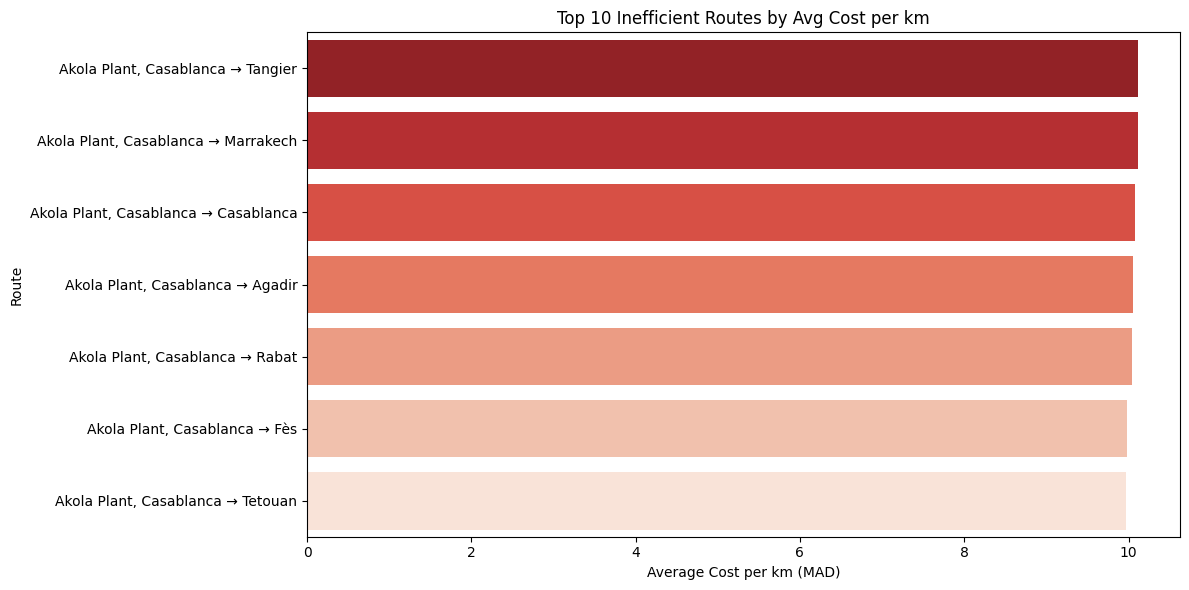

C:\Users\hp\AppData\Local\Temp\ipykernel_10232\583029002.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vehicle_inefficient_counts, x='count', y='vehicle_type', palette='Blues_d')


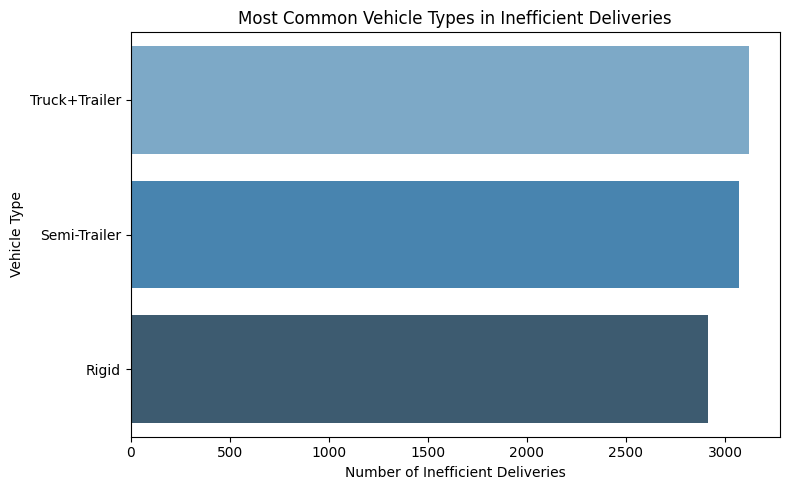

In [400]:
cost_per_km_threshold = underperforming_rows['cost_per_km'].quantile(0.90)
cost_per_kg_threshold = underperforming_rows['cost_per_kg'].quantile(0.90)

route_ranking = underperforming_rows.groupby('route')['cost_per_km'].mean().sort_values(ascending=False).head(10).reset_index()

vehicle_inefficient_counts = underperforming_rows['vehicle_type'].value_counts().reset_index()
vehicle_inefficient_counts.columns = ['vehicle_type', 'count']
plt.figure(figsize=(12, 6))
sns.barplot(data=route_ranking, x='cost_per_km', y='route', palette='Reds_r')
plt.title("Top 10 Inefficient Routes by Avg Cost per km")
plt.xlabel("Average Cost per km (MAD)")
plt.ylabel("Route")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(data=vehicle_inefficient_counts, x='count', y='vehicle_type', palette='Blues_d')
plt.title("Most Common Vehicle Types in Inefficient Deliveries")
plt.xlabel("Number of Inefficient Deliveries")
plt.ylabel("Vehicle Type")
plt.tight_layout()
plt.show()

Most originate from Akola Plant, Casablanca, targeting major cities.

Casablanca → Casablanca appears, meaning local trips are disproportionately expensive (likely due to fixed handling costs over short distance).

Routes like Tangier, Agadir, Fès, and Rabat may be using oversized vehicles for the load.  
Vehicle Type  	
, Frequency  
Truck+Trailer --	Very High  
Semi-Trailer  --	Very High  
Rigid  --	Slightly lower

C:\Users\hp\AppData\Local\Temp\ipykernel_10232\525162586.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_vehicle, x='count', y='vehicle_type', palette='viridis')


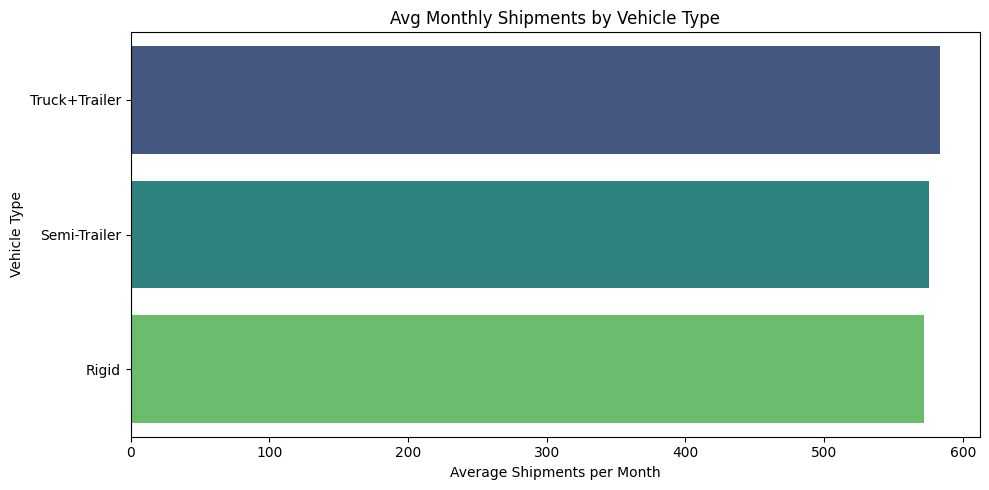

C:\Users\hp\AppData\Local\Temp\ipykernel_10232\525162586.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_mode, x='count', y='transport_mode', palette='magma')


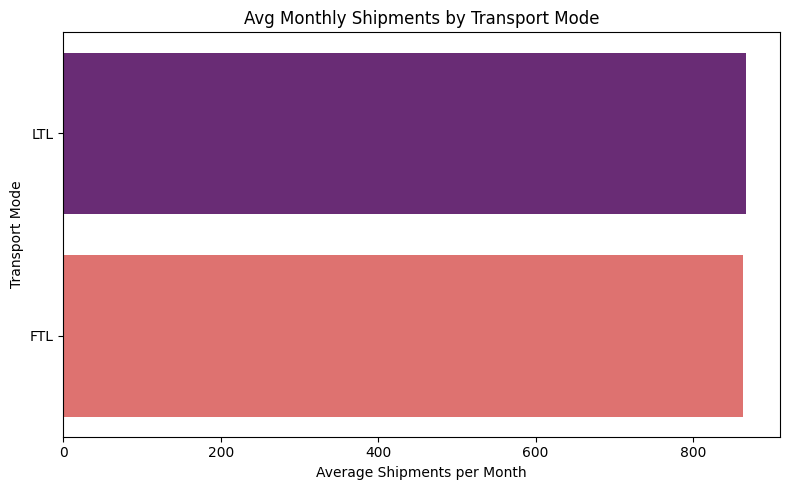

(1730.6666666666667,
     vehicle_type  count
 0  Truck+Trailer  583.2
 1   Semi-Trailer  575.8
 2          Rigid  571.7,
   transport_mode  count
 0            LTL  867.2
 1            FTL  863.4)

In [402]:
# excluding 2025 !!!!!!!!!!!
shippment_data['order_date'] = pd.to_datetime(shippment_data['order_date'], errors='coerce')
shippment_data = shippment_data[shippment_data['order_date'].dt.year < 2025]
shippment_data['month'] = shippment_data['order_date'].dt.to_period('M')

monthly_avg = shippment_data.groupby('month').size()
avg_total_monthly = monthly_avg.mean()

vehicle_monthly = shippment_data.groupby(['month', 'vehicle_type']).size().reset_index(name='count')
avg_vehicle = vehicle_monthly.groupby('vehicle_type')['count'].mean().round(1).sort_values(ascending=False).reset_index()

mode_monthly = shippment_data.groupby(['month', 'transport_mode']).size().reset_index(name='count')
avg_mode = mode_monthly.groupby('transport_mode')['count'].mean().round(1).sort_values(ascending=False).reset_index()


plt.figure(figsize=(10, 5))
sns.barplot(data=avg_vehicle, x='count', y='vehicle_type', palette='viridis')
plt.title("Avg Monthly Shipments by Vehicle Type")
plt.xlabel("Average Shipments per Month")
plt.ylabel("Vehicle Type")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(data=avg_mode, x='count', y='transport_mode', palette='magma')
plt.title("Avg Monthly Shipments by Transport Mode")
plt.xlabel("Average Shipments per Month")
plt.ylabel("Transport Mode")
plt.tight_layout()
plt.show()

avg_total_monthly, avg_vehicle, avg_mode

**All vehicle types are used quite evenly, with Truck+Trailer slightly leading. If resources are limited, vehicle mix optimization could trim costs.**

Average Shipments by Transport Mode (per month)  
Transport Mode	  ------    Avg Monthly Shipments  
**LTL** ----	  **862.2**  
**FTL**	-----   **856.2**

Your operations are ***evenly balanced*** between FTL and LTL. This suggests potential in:

***Route consolidation to shift LTL → FTL***

Load balancing between contract and spot freight

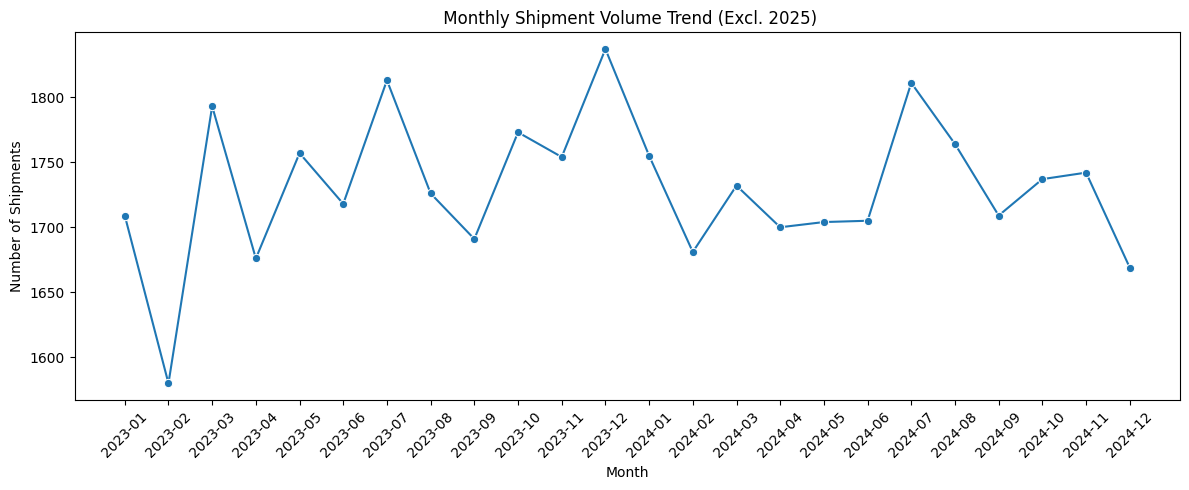

In [404]:
monthly_volume = shippment_data.groupby('month_str').size().reset_index(name='shipments')

plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_volume, x='month_str', y='shipments', marker='o')
plt.title(" Monthly Shipment Volume Trend (Excl. 2025)")
plt.xlabel("Month")
plt.ylabel("Number of Shipments")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

retailer_monthly = shippment_data.groupby(['month_str', 'retailer']).size().reset_index(name='count')
avg_retailer = retailer_monthly.groupby('retailer')['count'].mean().round(1).sort_values(ascending=False).reset_index()

region_monthly = shippment_data.groupby(['month_str', 'destination_region']).size().reset_index(name='count')
avg_region = region_monthly.groupby('destination_region')['count'].mean().round(1).sort_values(ascending=False).reset_index()

product_monthly = shippment_data.groupby(['month_str', 'product']).size().reset_index(name='count')
avg_product = product_monthly.groupby('product')['count'].mean().round(1).sort_values(ascending=False).reset_index()

avg_region.to_csv("avg_monthly_shipments_by_region.csv", index=False)

<h3> Products</h3>

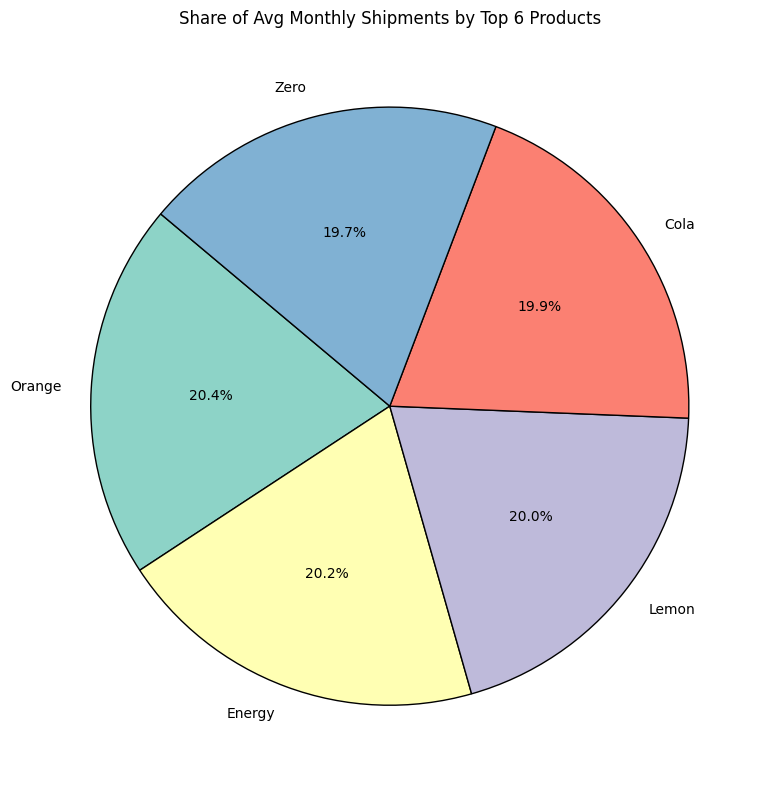

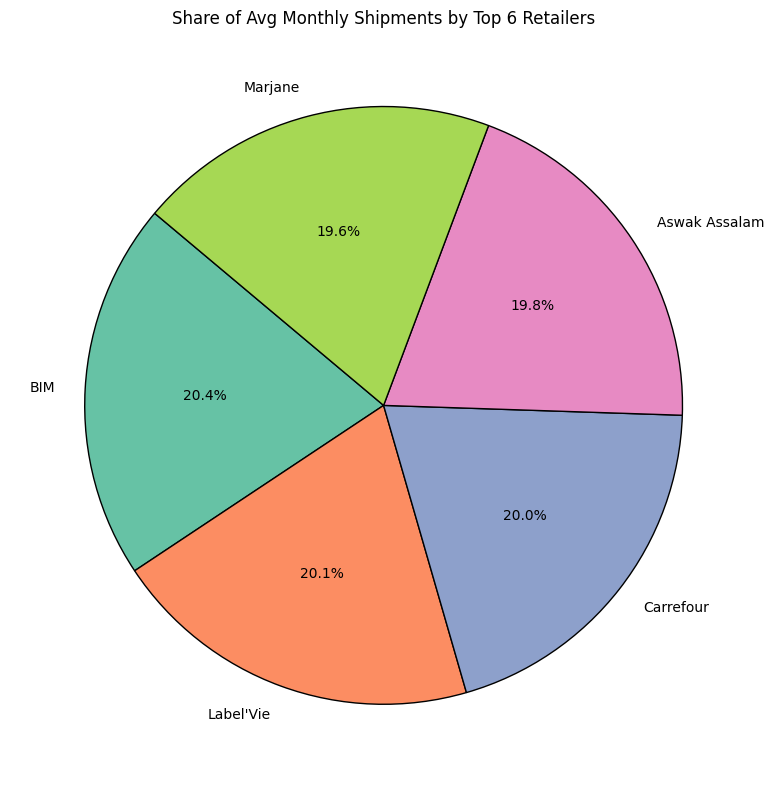

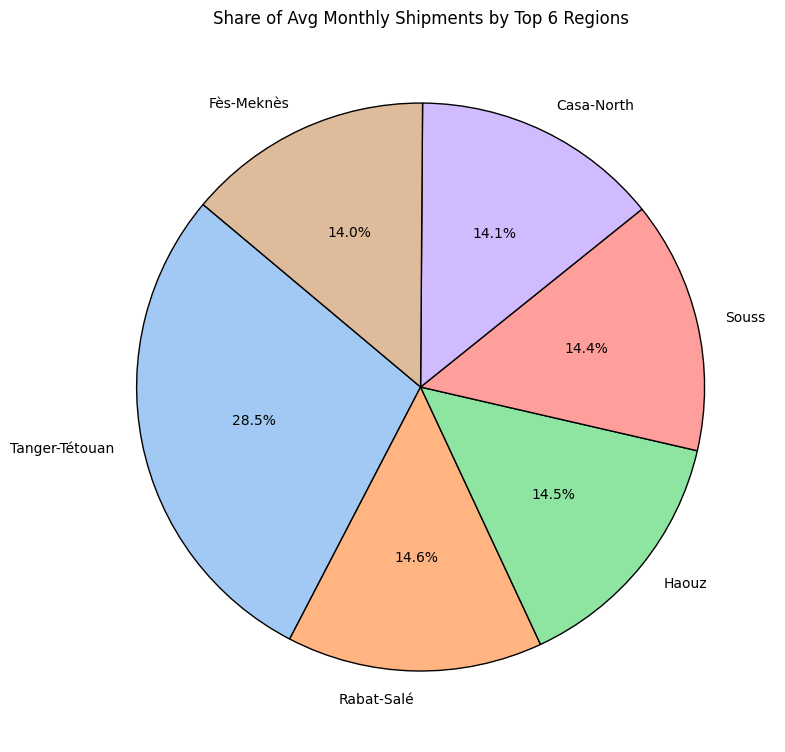

In [406]:
shippment_data['order_date'] = pd.to_datetime(shippment_data['order_date'], errors='coerce')
shippment_data = shippment_data[shippment_data['order_date'].dt.year < 2025]
shippment_data['month'] = shippment_data['order_date'].dt.to_period('M')
shippment_data['month_str'] = shippment_data['month'].astype(str)

product_monthly = shippment_data.groupby(['month_str', 'product']).size().reset_index(name='count')
avg_product = product_monthly.groupby('product')['count'].mean().round(1).sort_values(ascending=False).reset_index()

retailer_monthly = shippment_data.groupby(['month_str', 'retailer']).size().reset_index(name='count')
avg_retailer = retailer_monthly.groupby('retailer')['count'].mean().round(1).sort_values(ascending=False).reset_index()

region_monthly = shippment_data.groupby(['month_str', 'destination_region']).size().reset_index(name='count')
avg_region = region_monthly.groupby('destination_region')['count'].mean().round(1).sort_values(ascending=False).reset_index()


top_products = avg_product.head(6)
plt.figure(figsize=(8, 8))
plt.pie(
    top_products['count'],
    labels=top_products['product'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('Set3'),
    wedgeprops=dict(edgecolor='black')
)
plt.title("Share of Avg Monthly Shipments by Top 6 Products")
plt.tight_layout()
plt.show()

top_retailers = avg_retailer.head(6)
plt.figure(figsize=(8, 8))
plt.pie(
    top_retailers['count'],
    labels=top_retailers['retailer'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('Set2'),
    wedgeprops=dict(edgecolor='black')
)
plt.title("Share of Avg Monthly Shipments by Top 6 Retailers")
plt.tight_layout()
plt.show()

region_monthly = shippment_data.groupby(['month_str', 'destination_region']).size().reset_index(name='count')
avg_region = region_monthly.groupby('destination_region')['count'].mean().round(1).sort_values(ascending=False).reset_index()

top_regions = avg_region.head(6)
plt.figure(figsize=(8, 8))
plt.pie(
    top_regions['count'],
    labels=top_regions['destination_region'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('pastel'),
    wedgeprops=dict(edgecolor='black')
)
plt.title("Share of Avg Monthly Shipments by Top 6 Regions")
plt.tight_layout()
plt.show()

**Products:**  
All Product are almost evenly distributed, withOrange, Lemon adn Energy a tiny bit ahead  
Balanced demand profile — could be ideal for unified fleet planning  
  
***Retailers:**   
Same as Produts, items are evenly distributed (BIM with a slight lead)  
  
**Regions:**  
Tanger-Tétouan dominates. If this is a key retail zone, this might call for a :  

**Dedicated routing plans** 

***Inventory hubs closer to that zone***

<h3>
Packaging types   &   Temperature control   &   Route-level metrics</h3>

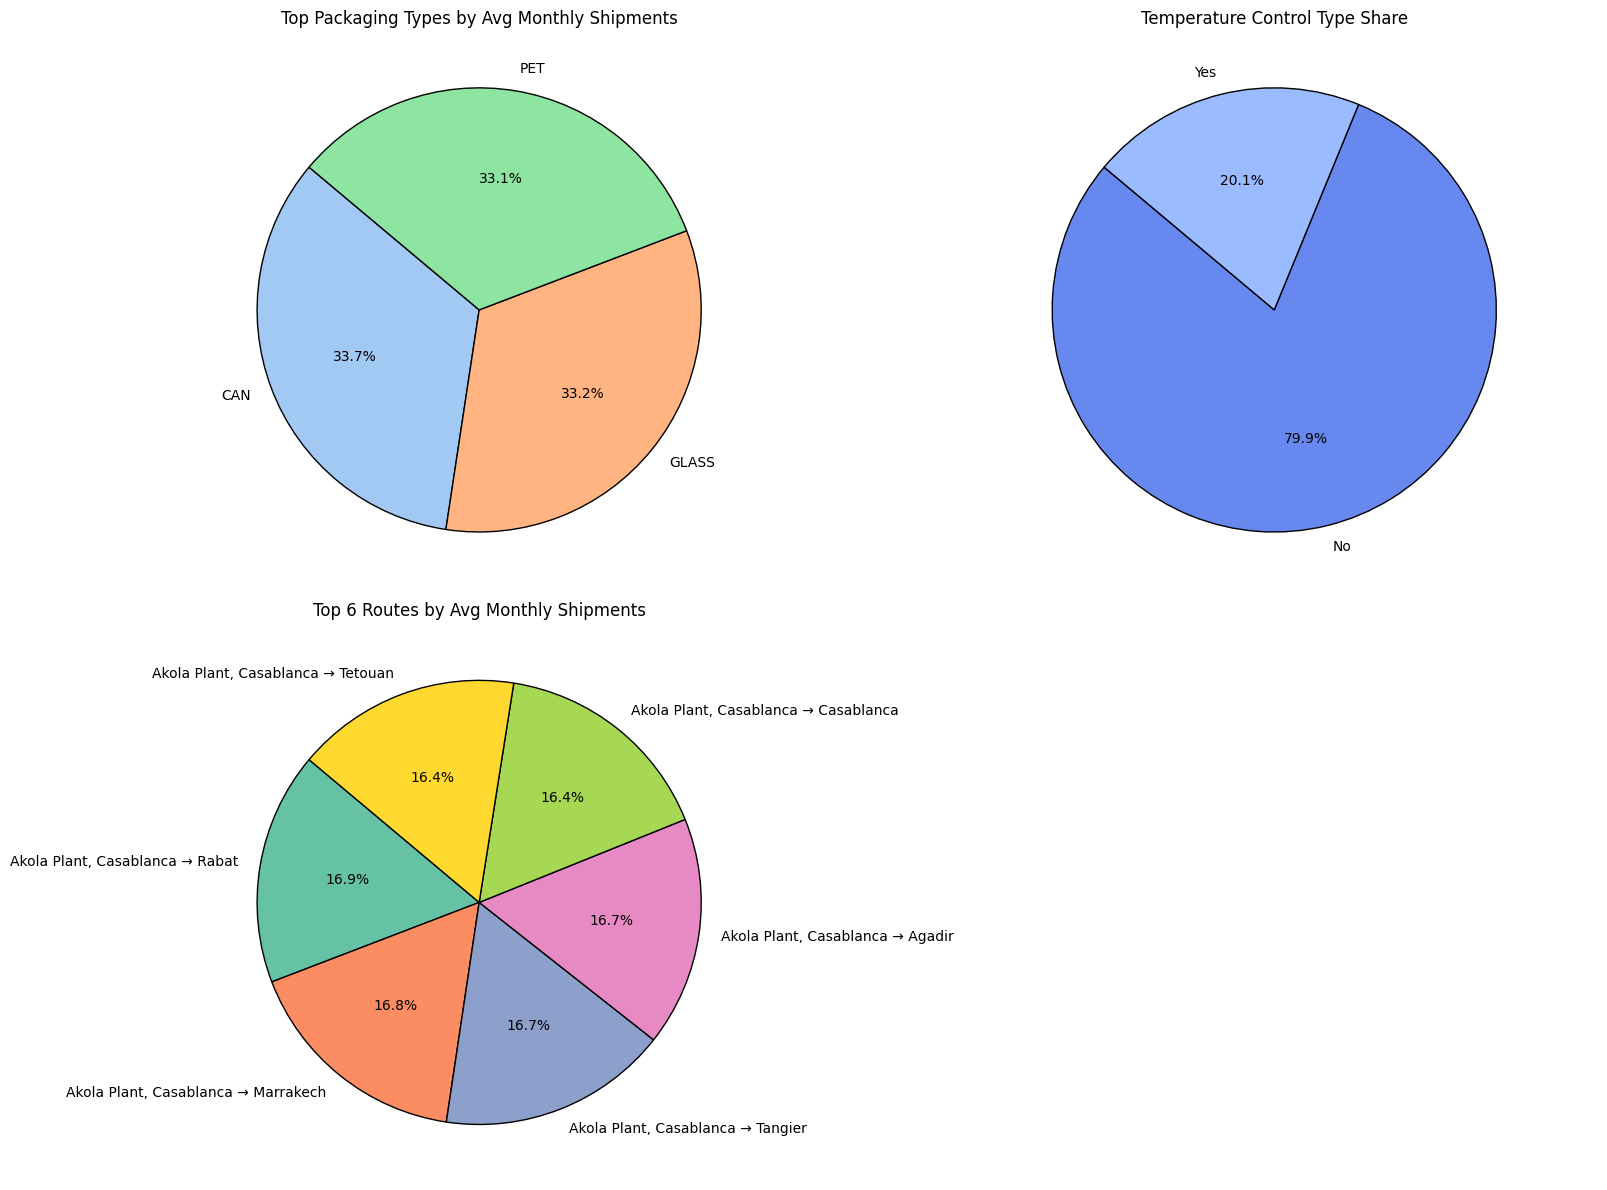

In [408]:
shippment_data['order_date'] = pd.to_datetime(shippment_data['order_date'], errors='coerce')
shippment_data = shippment_data[shippment_data['order_date'].dt.year < 2025]
shippment_data['month'] = shippment_data['order_date'].dt.to_period('M')
shippment_data['month_str'] = shippment_data['month'].astype(str)


packaging_monthly = shippment_data.groupby(['month_str', 'packaging']).size().reset_index(name='count')
avg_packaging = packaging_monthly.groupby('packaging')['count'].mean().round(1).sort_values(ascending=False).reset_index()

temp_monthly = shippment_data.groupby(['month_str', 'temperature_control']).size().reset_index(name='count')
avg_temp = temp_monthly.groupby('temperature_control')['count'].mean().round(1).sort_values(ascending=False).reset_index()

shippment_data['route'] = shippment_data['origin'] + " → " + shippment_data['destination_city']
route_monthly = shippment_data.groupby(['month_str', 'route']).size().reset_index(name='count')
avg_route = route_monthly.groupby('route')['count'].mean().round(1).sort_values(ascending=False).reset_index()

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

top_packaging = avg_packaging.head(6)
axs[0, 0].pie(
    top_packaging['count'],
    labels=top_packaging['packaging'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('pastel'),
    wedgeprops=dict(edgecolor='black')
)
axs[0, 0].set_title("Top Packaging Types by Avg Monthly Shipments")

top_temp = avg_temp.head(6)
axs[0, 1].pie(
    top_temp['count'],
    labels=top_temp['temperature_control'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('coolwarm'),
    wedgeprops=dict(edgecolor='black')
)
axs[0, 1].set_title("Temperature Control Type Share")

top_routes = avg_route.head(6)
axs[1, 0].pie(
    top_routes['count'],
    labels=top_routes['route'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('Set2'),
    wedgeprops=dict(edgecolor='black')
)
axs[1, 0].set_title("Top 6 Routes by Avg Monthly Shipments")

axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

**Packaging & Routes**  
balanced demand across packaging types  
Balanced regional demand  
**Temperature control Type Share**  
Majority of shipments do not require temperature control  
<h3>let's dig to :</h3>  
<h4>Consolidate cold chain deliveries into dedicated lanes</h4>

<h4>Avoid under-utilizing temperature-controlled trucks on mixed loads</h4>

C:\Users\hp\AppData\Local\Temp\ipykernel_10232\1257434841.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_routes, x='cold_chain_ratio', y='route', palette='coolwarm')


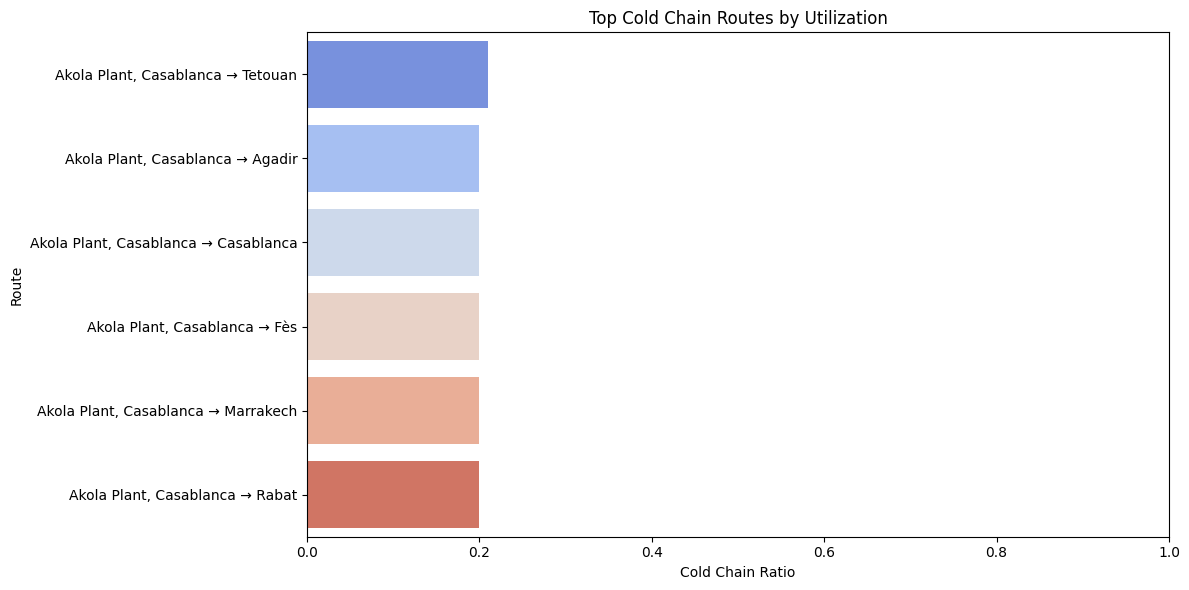

C:\Users\hp\AppData\Local\Temp\ipykernel_10232\1257434841.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=underutilized.head(10), x='cold_chain_ratio', y='route', palette='Reds_r')


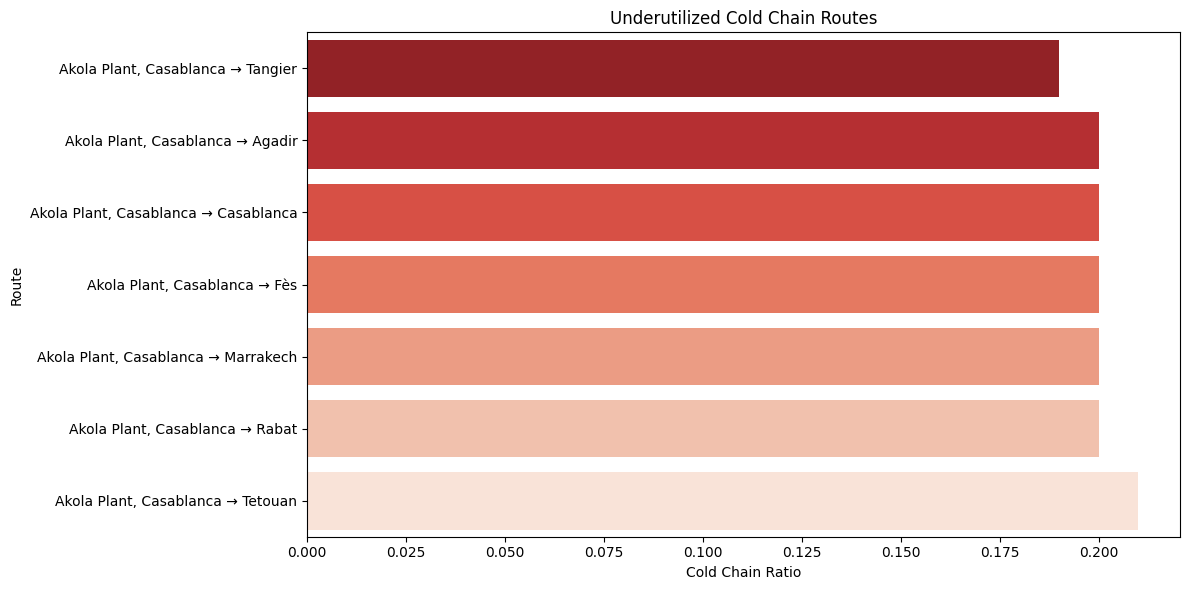

In [410]:
no_shippment_data['route'] = no_shippment_data['origin'] + " → " + no_shippment_data['destination_city']

route_temp_counts = no_shippment_data.groupby(['route', 'temperature_control'])['shipment_id'].count().unstack(fill_value=0).reset_index()
route_temp_counts.columns.name = None

route_temp_counts = route_temp_counts.rename(columns={False: 'non_cold_shipments', True: 'cold_shipments'})

route_temp_counts['total_shipments'] = route_temp_counts['cold_shipments'] + route_temp_counts['non_cold_shipments']
route_temp_counts['cold_chain_ratio'] = (route_temp_counts['cold_shipments'] / route_temp_counts['total_shipments']).round(2)

underutilized_cold_routes = route_temp_counts[
    (route_temp_counts['cold_shipments'] > 0) & 
    (route_temp_counts['cold_chain_ratio'] < 0.3)
].sort_values(by='cold_chain_ratio')

consolidation_candidates = route_temp_counts[
    route_temp_counts['cold_chain_ratio'] >= 0.2
].sort_values(by='cold_chain_ratio', ascending=False)

plt.figure(figsize=(12, 6))
top_routes = consolidation_candidates.sort_values(by='cold_chain_ratio', ascending=False).head(10)
sns.barplot(data=top_routes, x='cold_chain_ratio', y='route', palette='coolwarm')
plt.title("Top Cold Chain Routes by Utilization")
plt.xlabel("Cold Chain Ratio")
plt.ylabel("Route")
plt.xlim(0, 1.0)
plt.tight_layout()
plt.show()

underutilized = route_temp_counts[
    (route_temp_counts['cold_shipments'] > 0) & 
    (route_temp_counts['cold_chain_ratio'] < 0.3)
].sort_values(by='cold_chain_ratio')

plt.figure(figsize=(12, 6))
sns.barplot(data=underutilized.head(10), x='cold_chain_ratio', y='route', palette='Reds_r')
plt.title("Underutilized Cold Chain Routes")
plt.xlabel("Cold Chain Ratio")
plt.ylabel("Route")
plt.tight_layout()
plt.show()

**tempeature controlled distribution on Routes**  
  
temperature controlled shipments are almost evenly distributed between Routes  
***no possibility for a dedicated temperature controlled Fleet***  
  
**Underutilized Cold Chain Routes**  
  
These routes evenly carry few cold-sensitive goods, but the majority is non-cold.  
***Extra operating costs for Cargo with not enough cold cargo to justify it.***

In [44]:
underutilized_costs = no_shippment_data.groupby('route').agg({
    'cold_cost': 'sum',
    'non_cold_cost': 'sum'
}).reset_index()

underutilized_costs['total_cost'] = underutilized_costs['cold_cost'] + underutilized_costs['non_cold_cost']
# Top 5 routes by total cost
top_routes = underutilized_costs.sort_values('total_cost', ascending=False).head(5)

for _, row in top_routes.iterrows():
    labels = ['Cold Cost', 'Non-Cold Cost']
    values = [row['cold_cost'], row['non_cold_cost']]
    
    plt.figure(figsize=(5, 5))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90,
            wedgeprops={'width': 0.5})
    plt.title(f" Cost Share: {row['route']}")
    plt.tight_layout()
    plt.show()

KeyError: 'route'

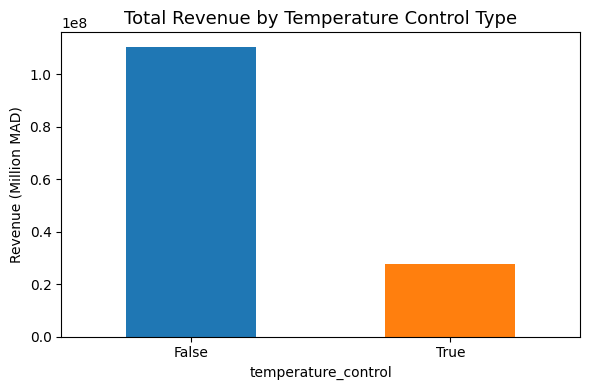

In [416]:
no_shippment_data['temperature_control'] = no_shippment_data['temperature_control'].astype(bool)

colors = ['#1f77b4', '#ff7f0e']  # Custom blue-orange palette

revenue_by_temp = (
    no_shippment_data
    .groupby('temperature_control')['order_value_mad']
    .sum()
    
    .sort_values(ascending=False)
)
plt.figure(figsize=(6, 4))
revenue_by_temp.plot(kind='bar', color=colors)
plt.title("Total Revenue by Temperature Control Type", fontsize=13)
plt.ylabel("Revenue (MAD)")
plt.xticks(rotation=0)
revenue_millions = revenue_by_temp / 1e6

ax = revenue_millions.plot(kind='bar', color=colors, figsize=(6, 4))
plt.title("Total Revenue by Temperature Control Type", fontsize=13)
plt.ylabel("Revenue (Million MAD)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 

In [39]:
shippment_data['temperature_control'] = shippment_data['temperature_control'].map({'Yes': True, 'No': False})

C:\Users\hp\AppData\Local\Temp\ipykernel_6824\104403737.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shippment_data['temperature_control'] = shippment_data['temperature_control'].map({'Yes': True, 'No': False})


In [41]:
shippment_data = shippment_data.copy()

shippment_data.loc[:, 'temperature_control'] = shippment_data['temperature_control'].map({'Yes': True, 'No': False})

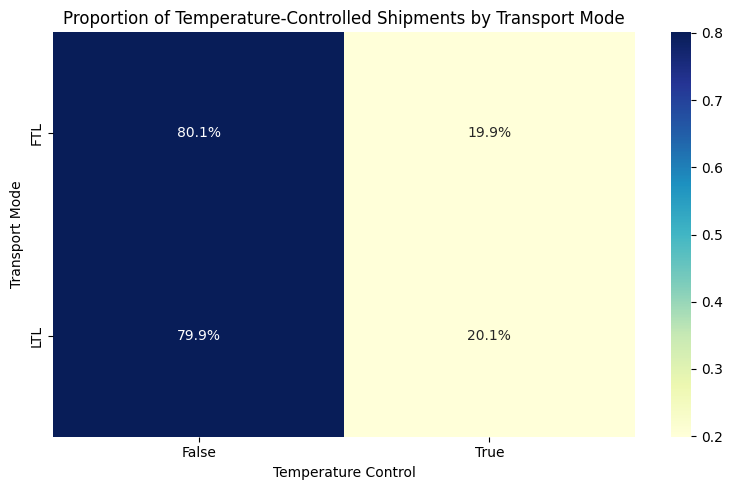

C:\Users\hp\AppData\Local\Temp\ipykernel_4360\2365173011.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=no_shippment_data, x='temperature_control', y='transport_cost_mad', palette='Set2')


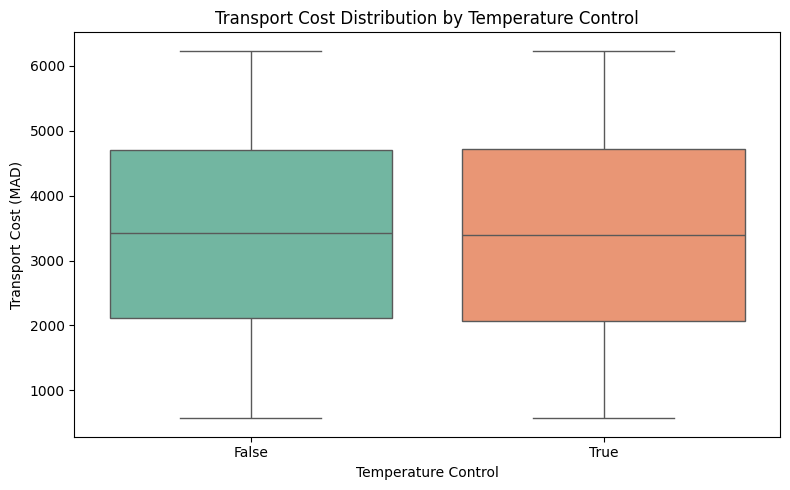

C:\Users\hp\AppData\Local\Temp\ipykernel_4360\2365173011.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=profit_by_temp, x='temperature_control', y='profit_mad', palette=['lightblue', 'lightsalmon'])


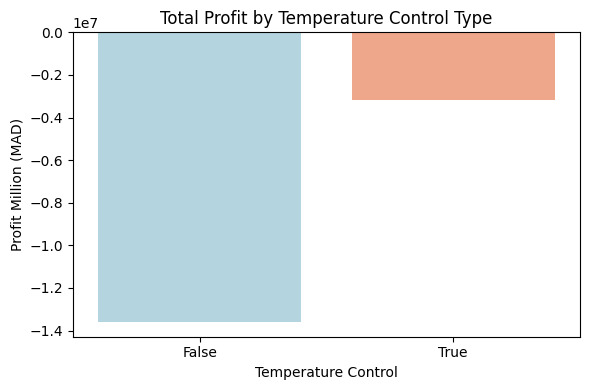

In [33]:
no_shippment_data['temperature_control'] = no_shippment_data['temperature_control'].astype(bool)
no_shippment_data['transport_mode'] = no_shippment_data['transport_mode'].astype(str)

temp_mode_ct = pd.crosstab(no_shippment_data['transport_mode'], no_shippment_data['temperature_control'], normalize='index')

plt.figure(figsize=(8, 5))
sns.heatmap(temp_mode_ct, annot=True, cmap='YlGnBu', fmt='.1%')
plt.title('Proportion of Temperature-Controlled Shipments by Transport Mode')
plt.xlabel('Temperature Control')
plt.ylabel('Transport Mode')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(data=no_shippment_data, x='temperature_control', y='transport_cost_mad', palette='Set2')
plt.title('Transport Cost Distribution by Temperature Control')
plt.xlabel('Temperature Control')
plt.ylabel('Transport Cost (MAD)')
plt.tight_layout()
plt.show()

no_shippment_data['profit_mad'] = no_shippment_data['order_value_mad'] - no_shippment_data['transport_cost_mad']

profit_by_temp = no_shippment_data.groupby('temperature_control')['profit_mad'].sum().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(data=profit_by_temp, x='temperature_control', y='profit_mad', palette=['lightblue', 'lightsalmon'])
plt.title("Total Profit by Temperature Control Type")
plt.ylabel("Profit Million (MAD)")
plt.xlabel("Temperature Control")
plt.tight_layout()
plt.show()

### 

Consistent ratio across both FTL/LTL.

Temperatue_control utilization is low across all transport types → underuse of ***refrigeration capacity.***

The transport cost distributions for both tYPES are evenly distributed on a medians of almost 3500 MAD :

Similar interquartile ranges and outliers.  

***Despite added refrigeration, cold shipments do not seem significantly more expensive per delivery.***

may be an indicator of temperature control inneficency

Both shipment types are operating at a loss.  

Non-temperature control shipments account for the majority of the loss.

Possibly due to large volume and low-margin nature.

Cold Chain is less unprofitable (or more efficient per shipment).

***!!! WARNING !!!***  
This suggests serious cost structure issues.

Suggestions :

Reviewing pricing models.

Route consolidation, especially for Non-temperature control.

Increasing temperature control chain pricing to reflect value.

<h1>EDA & KPI :</h1>

<h3>OTIF</h3>

***Delivered on the planned date and completely fulfilled (quantity, weight).***

In [47]:
shippment_data['on_time'] = (shippment_data['actual_delivery_date'] == shippment_data['planned_delivery_date'])
shippment_data['in_full'] = shippment_data['quantity_units'] == shippment_data['quantity_units']  # Assuming complete if not partials given

shippment_data['otif'] = shippment_data['on_time'] & shippment_data['in_full']

otif_rate = shippment_data['otif'].mean() * 100
print(f"OTIF Rate: {otif_rate:.2f}%")

OTIF Rate: 20.36%


<h2> taux de remplissage</h2>

Average Load Factor (Fill Rate): 89.73%


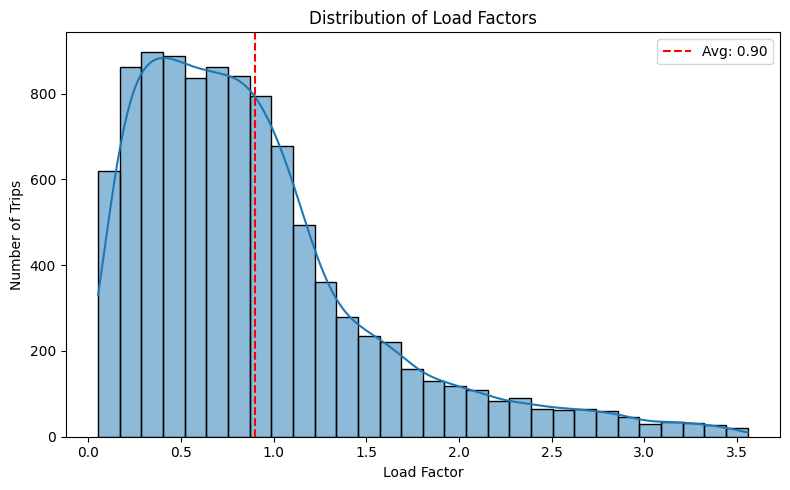

In [430]:
trips_merged = pd.merge(
    no_trips_df,
    no_fleet_df,
    on='truck_plate',
    how='left'
)

trips_merged['load_factor'] = trips_merged['load_kg'] / trips_merged['capacity_kg']

avg_fill = trips_merged['load_factor'].mean()
print(f"Average Load Factor (Fill Rate): {avg_fill:.2%}")

plt.figure(figsize=(8, 5))
sns.histplot(trips_merged['load_factor'], bins=30, kde=True)
plt.title("Distribution of Load Factors")
plt.xlabel("Load Factor")
plt.ylabel("Number of Trips")
plt.axvline(avg_fill, color='red', linestyle='--', label=f'Avg: {avg_fill:.2f}')
plt.legend()
plt.tight_layout()
plt.show()

<h2>Costs</h2>

Average Transport Cost per Shipment: 3405.16 MAD


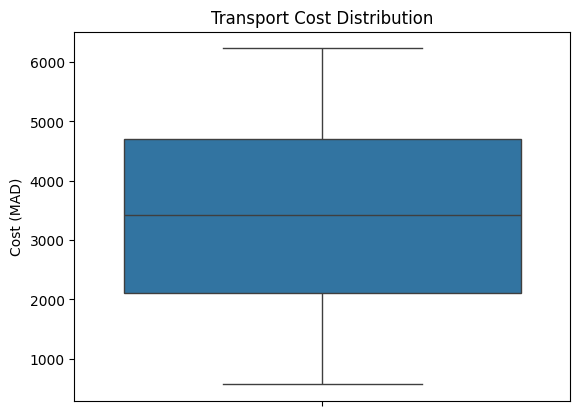

In [432]:
avg_cost = no_shippment_data['transport_cost_mad'].mean()
print(f"Average Transport Cost per Shipment: {avg_cost:.2f} MAD")

sns.boxplot(data=no_shippment_data, y='transport_cost_mad')
plt.title("Transport Cost Distribution")
plt.ylabel("Cost (MAD)")
plt.show()

In [434]:
# Adding Profit column !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Profit column
shippment_data['profit_mad'] = shippment_data['order_value_mad'] - shippment_data['transport_cost_mad']
# no_Profit column
no_shippment_data['profit_mad'] = no_shippment_data['order_value_mad'] - no_shippment_data['transport_cost_mad']

<h2>Route Distance</h2>

In [436]:
total_distance = no_shippment_data['route_distance_km'].sum()
avg_distance = no_shippment_data['route_distance_km'].mean()

print(f"Total Distance Covered: {total_distance:,.0f} km")
print(f"Average Distance per Shipment: {avg_distance:.2f} km")

Total Distance Covered: 19,405,026 km
Average Distance per Shipment: 426.12 km


<h2>Delay</h2>

In [438]:
shippment_data['delay_days'] = (shippment_data['actual_delivery_date'] - shippment_data['planned_delivery_date']).dt.days
avg_delay = shippment_data['delay_days'].mean()
print(f"Average Delivery Delay: {avg_delay:.2f} days")

Average Delivery Delay: 1.04 days


<h2>KPI Summary</h2>

In [440]:
kpi_summary = pd.DataFrame({
    'OTIF Rate (%)': [otif_rate],
    'Avg Load Factor': [avg_fill],
    'Avg Cost (MAD)': [avg_cost],
    'Avg Distance (km)': [avg_distance],
    'Avg Delay (days)': [avg_delay]
})
display(kpi_summary)

OTIF Rate (%)  Avg Load Factor  Avg Cost (MAD)  Avg Distance (km)  \
0      20.355836         0.897318     3405.162222         426.118843   

   Avg Delay (days)  
0          1.038665

<h2> Cost per kg / Cost per km</h2>

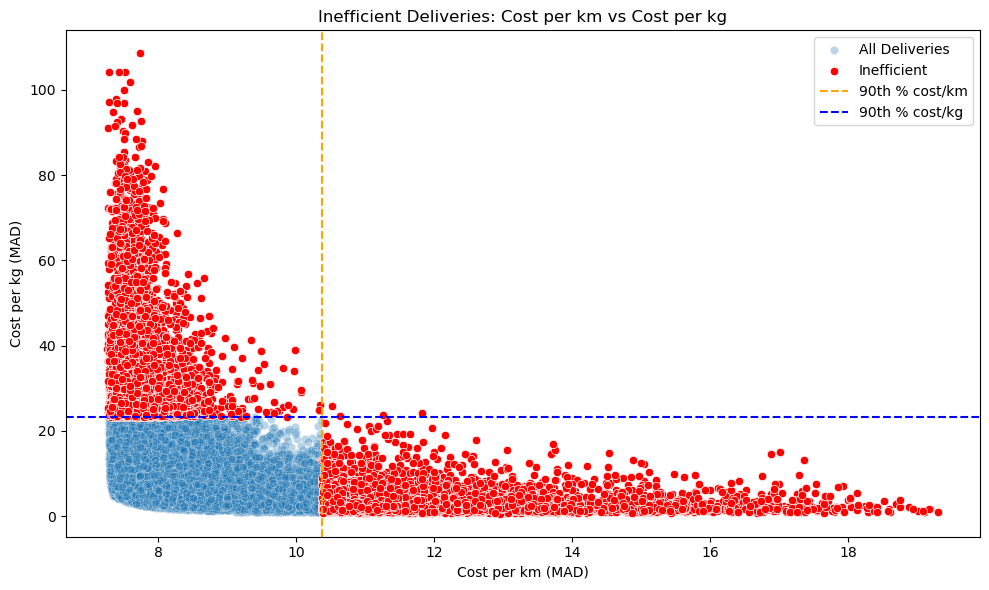

In [191]:
no_shippment_data['cost_per_km'] = no_shippment_data['transport_cost_mad'] / no_shippment_data['route_distance_km']
no_shippment_data['cost_per_kg'] = no_shippment_data['transport_cost_mad'] / no_shippment_data['total_weight_kg']
no_shippment_data['route'] = no_shippment_data['origin'] + " → " + no_shippment_data['destination_city']

no_shippment_data = no_shippment_data.replace([float('inf'), -float('inf')], pd.NA)
no_shippment_data = no_shippment_data.dropna(subset=['cost_per_km', 'cost_per_kg', 'vehicle_type'])

vehicle_kpis = no_shippment_data.groupby('vehicle_type').agg({
    'shipment_id': 'count',
    'transport_cost_mad': 'mean',
    'total_weight_kg': 'mean',
    'route_distance_km': 'mean'
}).rename(columns={
    'shipment_id': 'num_shipments',
    'transport_cost_mad': 'avg_cost',
    'total_weight_kg': 'avg_weight',
    'route_distance_km': 'avg_distance'
})

vehicle_kpis['cost_per_kg'] = vehicle_kpis['avg_cost'] / vehicle_kpis['avg_weight']
vehicle_kpis['cost_per_km'] = vehicle_kpis['avg_cost'] / vehicle_kpis['avg_distance']
vehicle_kpis = vehicle_kpis.round(2)

km_thresh = no_shippment_data['cost_per_km'].quantile(0.90)
kg_thresh = no_shippment_data['cost_per_kg'].quantile(0.90)

inefficient_routes = no_shippment_data[
    (no_shippment_data['cost_per_km'] > km_thresh) | (no_shippment_data['cost_per_kg'] > kg_thresh)
]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=no_shippment_data, x='cost_per_km', y='cost_per_kg', alpha=0.3, label='All Deliveries'
)
sns.scatterplot(
    data=inefficient_routes, x='cost_per_km', y='cost_per_kg', color='red', label='Inefficient'
)
plt.axvline(km_thresh, color='orange', linestyle='--', label='90th % cost/km')
plt.axhline(kg_thresh, color='blue', linestyle='--', label='90th % cost/kg')
plt.title("Inefficient Deliveries: Cost per km vs Cost per kg")
plt.xlabel("Cost per km (MAD)")
plt.ylabel("Cost per kg (MAD)")
plt.legend()
plt.tight_layout()
plt.show()

cols_to_export = [
    'shipment_id', 'vehicle_type', 'transport_mode', 'route',
    'route_distance_km', 'total_weight_kg', 'transport_cost_mad',
    'cost_per_km', 'cost_per_kg'
]
underperforming_rows = inefficient_routes[cols_to_export]

underperforming_rows.to_csv("underperforming_deliveries.csv", index=False)

The top left quadrant (high cost per kg, low km) suggests:    

  **Possibility of underloaded trucks (lightweight but costly trips)**  

The bottom right quadrant (high cost per km, low kg) suggests:    

  Longer trips that aren't cost-efficient per km **(e.g., bad routing or backhauling)** 

The dense red center shows clustered inefficiencies — common pain points

<h2>Cancellation & Delay Rates</h2>

In [29]:
shippment_data['status'] = shippment_data['status'].str.strip().str.lower()

shippment_data['is_cancelled'] = shippment_data['status'].str.contains('cancelled')
shippment_data['is_delayed'] = shippment_data['status'] == 'delayed'

shippment_data['route'] = shippment_data['origin'] + ' → ' + shippment_data['destination_city']

group_dims = ['destination_region', 'route', 'retailer', 'product']
delay_cancel_kpis = {}

for dim in group_dims:
    grouped = shippment_data.groupby(dim).agg(
        total_shipments=('shipment_id', 'count'),
        cancelled=('is_cancelled', 'sum'),
        delayed=('is_delayed', 'sum')
    )
    grouped['cancelled_rate'] = grouped['cancelled'] / grouped['total_shipments']
    grouped['delayed_rate'] = grouped['delayed'] / grouped['total_shipments']
    
    delay_cancel_kpis[dim] = grouped.sort_values(by='cancelled_rate', ascending=False)


In [31]:
delay_cancel_kpis['destination_region'].head()
delay_cancel_kpis['route'].head()
delay_cancel_kpis['retailer'].head()
delay_cancel_kpis['product'].head()

total_shipments  cancelled  delayed  cancelled_rate  delayed_rate
product                                                                   
Lemon               8287       2104     2066        0.253892      0.249306
Cola                8250       2076     2113        0.251636      0.256121
Zero                8168       2030     2043        0.248531      0.250122
Orange              8456       2083     2112        0.246334      0.249763
Energy              8375       2032     2133        0.242627      0.254687

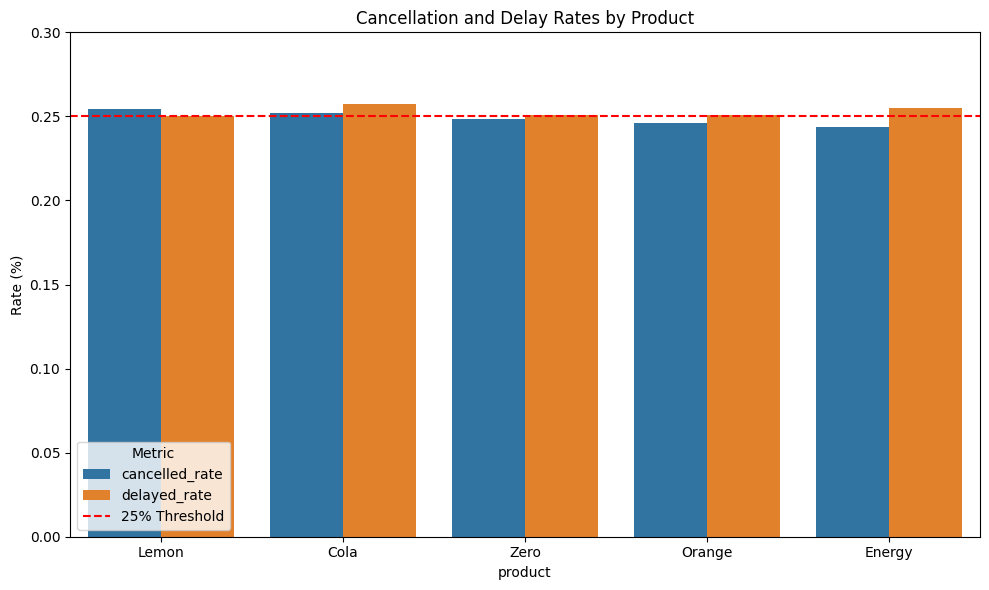

In [55]:
product_kpis = delay_cancel_kpis['product'].reset_index()

melted = product_kpis.melt(
    id_vars='product',
    value_vars=['cancelled_rate', 'delayed_rate'],
    var_name='Metric',
    value_name='Rate'
)

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='product', y='Rate', hue='Metric')
plt.title('Cancellation and Delay Rates by Product')
plt.ylabel('Rate (%)')
plt.ylim(0, 0.3)
plt.axhline(0.25, color='red', linestyle='--', label='25% Threshold')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

**Cancellation & Delay rates are equally devided** is **not** particularly **good**. this might infer **systemic issues across the supply chain affecting all products similarly** (e.g., shared logistics constraints, warehouse bottlenecks, or fleet limitations).

<Figure size 1400x600 with 0 Axes>

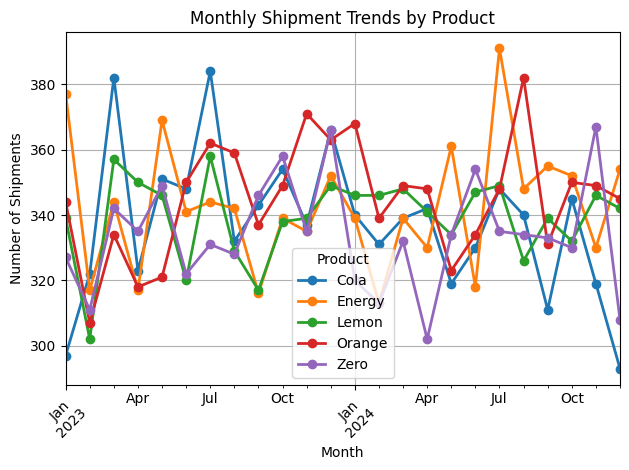

In [57]:
shippment_data["order_date"] = pd.to_datetime(shippment_data["order_date"], errors="coerce")

shippment_data["month"] = shippment_data["order_date"].dt.to_period("M")

monthly_counts = shippment_data.groupby(["month", "product"]).size().reset_index(name="shipments")

monthly_pivot = monthly_counts.pivot(index="month", columns="product", values="shipments")

plt.figure(figsize=(14, 6))
monthly_pivot.plot(marker='o', linewidth=2)
plt.title("Monthly Shipment Trends by Product")
plt.ylabel("Number of Shipments")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend(title="Product")
plt.show()

Seasonal fluctuations are clearly visible, with some products showing recurring peaks (e.g., Energy in mid-2023).

<h1>Forecast</h1>

<h2> Prophet Forecast </h2>

**Aggregate Historical Data**  
time series from existing data (2023–2024) by month:

In [59]:
monthly_data = shippment_data.groupby(shippment_data['order_date'].dt.to_period('M')).agg({
    'quantity_units': 'sum',
    'total_weight_kg': 'sum',
    'transport_cost_mad': 'sum'
}).reset_index()
monthly_data['order_date'] = monthly_data['order_date'].dt.to_timestamp()


17:51:12 - cmdstanpy - INFO - Chain [1] start processing
17:51:13 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


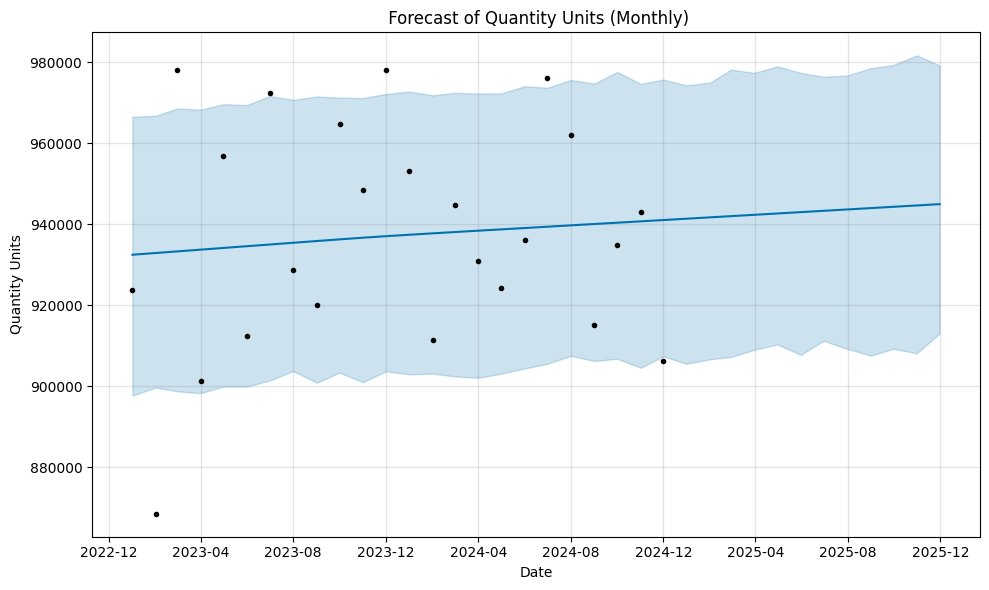

17:51:14 - cmdstanpy - INFO - Chain [1] start processing
17:51:14 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


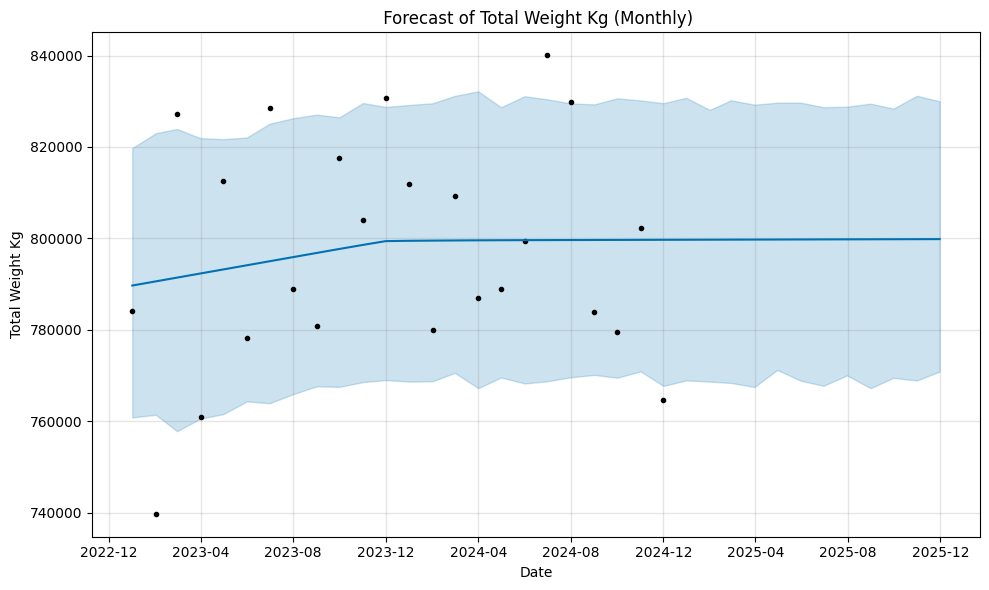

17:51:15 - cmdstanpy - INFO - Chain [1] start processing
17:51:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


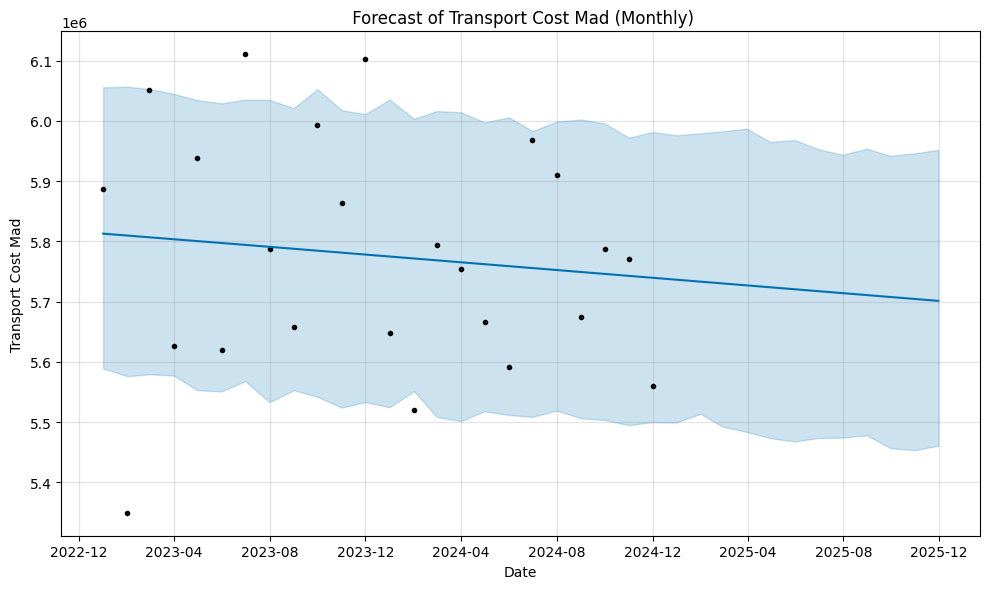

In [61]:
def forecast_series(df, column, periods=12):
    model_data = df[['order_date', column]].rename(columns={'order_date': 'ds', column: 'y'})
    model = Prophet()
    model.fit(model_data)

    future = model.make_future_dataframe(periods=periods, freq='M')
    forecast = model.predict(future)

    fig = model.plot(forecast)
    plt.title(f" Forecast of {column.replace('_', ' ').title()} (Monthly)")
    plt.xlabel("Date")
    plt.ylabel(column.replace('_', ' ').title())
    plt.tight_layout()
    plt.show()


    result = forecast[['ds', 'yhat']].tail(periods).rename(columns={
    'ds': 'date',
    'yhat': f'{column}_forecast'
})
    return result

quantity_forecast = forecast_series(monthly_data, 'quantity_units')
weight_forecast = forecast_series(monthly_data, 'total_weight_kg')
cost_forecast = forecast_series(monthly_data, 'transport_cost_mad')

in terms of **Units quantity** a relatively stable demand with a slight inrease in early Q4 of 2023, but slightly decreasing in 2025.    
  
in terms of **Total Weight Kg**, with the slight increase coming a bit later (lae Q4 of 2023), this indicates ***Product demande is dropping in 2025***   
  
In terms of **Costs**, it remains amost flat, in a slightly declining trend.  
***Cost Management is mandatory***

<h2> Arima Forecast</h2>

C:\Users\hp\AppData\Local\Temp\ipykernel_6824\4215678641.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = shippment_data.groupby(pd.Grouper(key='order_date', freq='M')).agg({
C:\Users\hp\AppData\Local\Temp\ipykernel_6824\4215678641.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = ts.asfreq('M')  # Monthly frequency


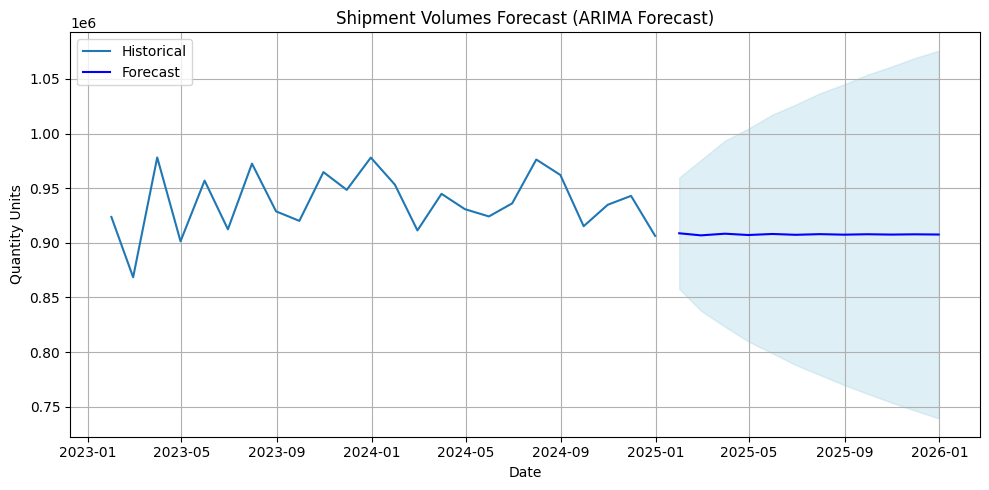

C:\Users\hp\AppData\Local\Temp\ipykernel_6824\4215678641.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = ts.asfreq('M')  # Monthly frequency


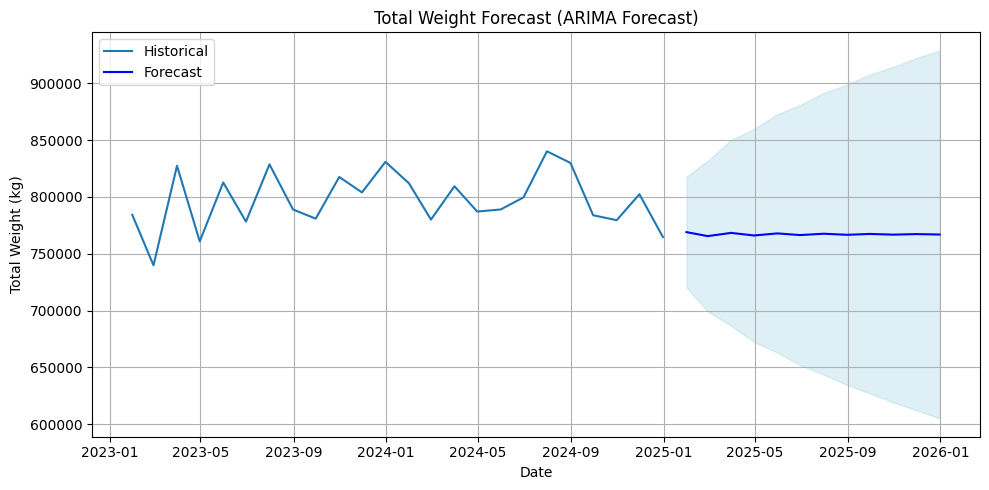

C:\Users\hp\AppData\Local\Temp\ipykernel_6824\4215678641.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = ts.asfreq('M')  # Monthly frequency


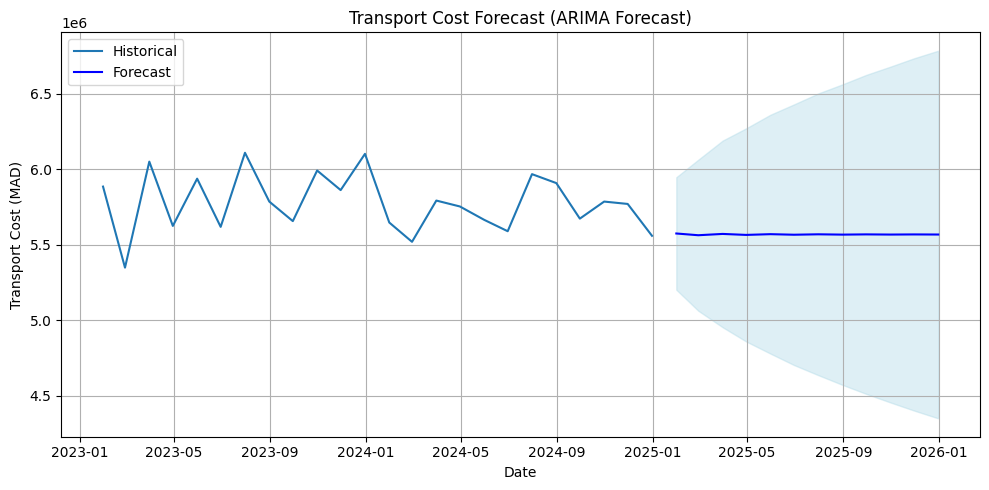

2025-01-31    5.575813e+06
2025-02-28    5.564281e+06
2025-03-31    5.572937e+06
2025-04-30    5.566440e+06
2025-05-31    5.571317e+06
2025-06-30    5.567656e+06
2025-07-31    5.570404e+06
2025-08-31    5.568341e+06
2025-09-30    5.569890e+06
2025-10-31    5.568727e+06
2025-11-30    5.569600e+06
2025-12-31    5.568945e+06
Freq: ME, Name: predicted_mean, dtype: float64

In [63]:
monthly_data = shippment_data.groupby(pd.Grouper(key='order_date', freq='M')).agg({
    'quantity_units': 'sum',
    'total_weight_kg': 'sum',
    'transport_cost_mad': 'sum'
}).reset_index()


def arima_forecast(series, periods=12, title='Forecast', ylabel='Value'):
    # Ensure datetime index
    ts = series.set_index('order_date')
    ts = ts.asfreq('M')  # Monthly frequency

    # Fit ARIMA model (adjust (p,d,q) if needed)
    model = ARIMA(ts, order=(1,1,1))  # basic ARIMA config
    fitted = model.fit()

    forecast = fitted.get_forecast(steps=periods)
    pred_ci = forecast.conf_int()
    forecast_values = forecast.predicted_mean

    plt.figure(figsize=(10,5))
    plt.plot(ts, label='Historical')
    plt.plot(forecast_values, label='Forecast', color='blue')
    plt.fill_between(forecast_values.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='lightblue', alpha=0.4)
    plt.title(f"{title} (ARIMA Forecast)")
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return forecast_values
arima_forecast(monthly_data[['order_date', 'quantity_units']], title='Shipment Volumes Forecast', ylabel='Quantity Units')

arima_forecast(monthly_data[['order_date', 'total_weight_kg']], title='Total Weight Forecast', ylabel='Total Weight (kg)')

arima_forecast(monthly_data[['order_date', 'transport_cost_mad']], title='Transport Cost Forecast', ylabel='Transport Cost (MAD)')

**Shipment Volumes Forecast (Quantity Units)**  
  
Historical Data (2023–2024): Monthly shipment volumes fluctuates between around 880K and 990K units, indicating some ***volatility***, ***no clear seasonality.***  
  
Forecast (2025): Flat forecast around ~910,000 units.

Confidence Interval: Widens substantially into late 2025, reflecting increased uncertainty.  

The model suggests a mild decrease or flatness in shipments.  
  
The wide forecast band indicates low confidence in the model’s predictive power(Might due to the absence of strong seasonality or trend.)


**Total Weight Forecast (kg)**

Historical Weight: Ranged between 740K and 860K kg/month.

Forecast: A flat line around 790K kg.

The confidence interval expands to a wide range (660K to 930K).  

Like the shipment volume, this trend shows no strong seasonality or ttrend.


**Transport Cost Forecast (MAD)**  
  
Historical Costs: Varying between 5.4M and 6.2M MAD/month.

Forecast: Stabilizes around 5.7M MAD with broad uncertainty from around 4.4M to 6.9M MAD.  

The projected stabilization of cost is promising but might hide volatility from xternal factors.

In [ ]:
!pip install pmdarima

C:\Users\hp\AppData\Local\Temp\ipykernel_6824\1288452231.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = shippment_data.groupby(pd.Grouper(key='order_date', freq='M')).agg({
C:\Users\hp\AppData\Local\Temp\ipykernel_6824\4215678641.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = ts.asfreq('M')  # Monthly frequency


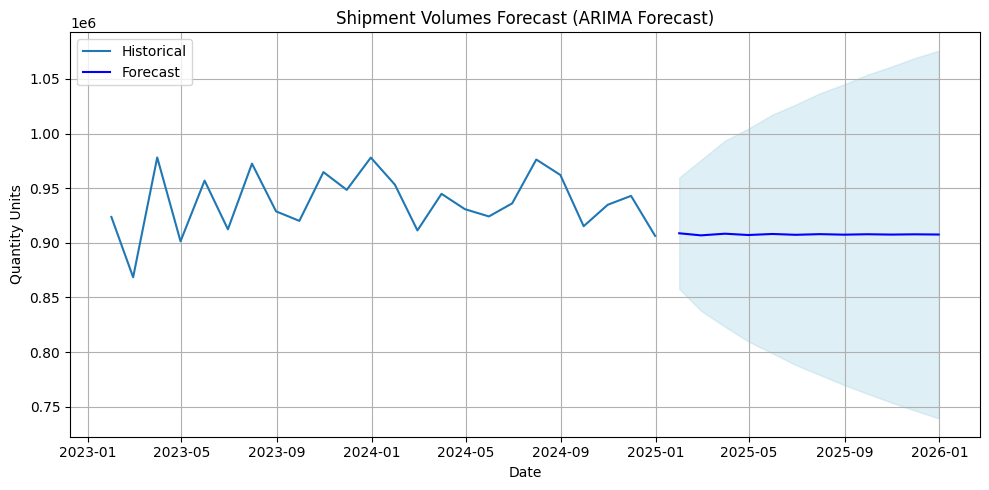

C:\Users\hp\AppData\Local\Temp\ipykernel_6824\4215678641.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = ts.asfreq('M')  # Monthly frequency


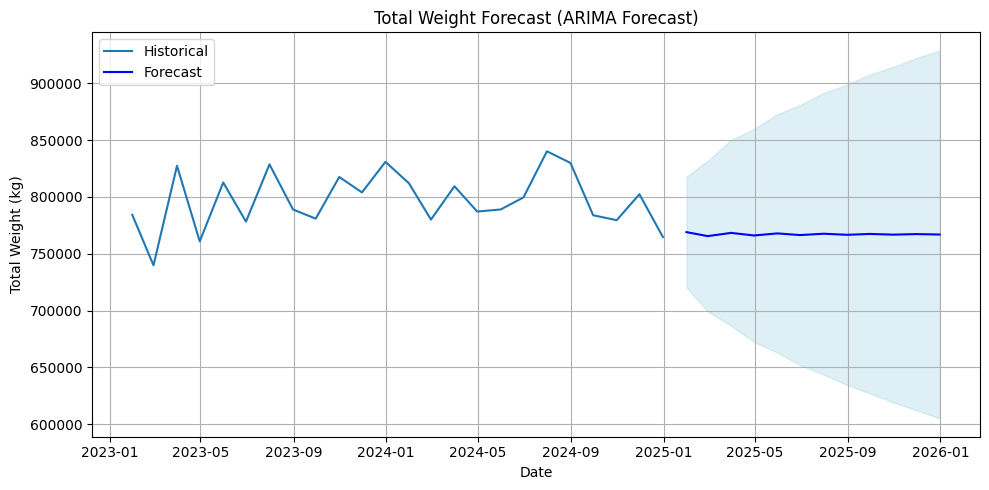

C:\Users\hp\AppData\Local\Temp\ipykernel_6824\4215678641.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = ts.asfreq('M')  # Monthly frequency


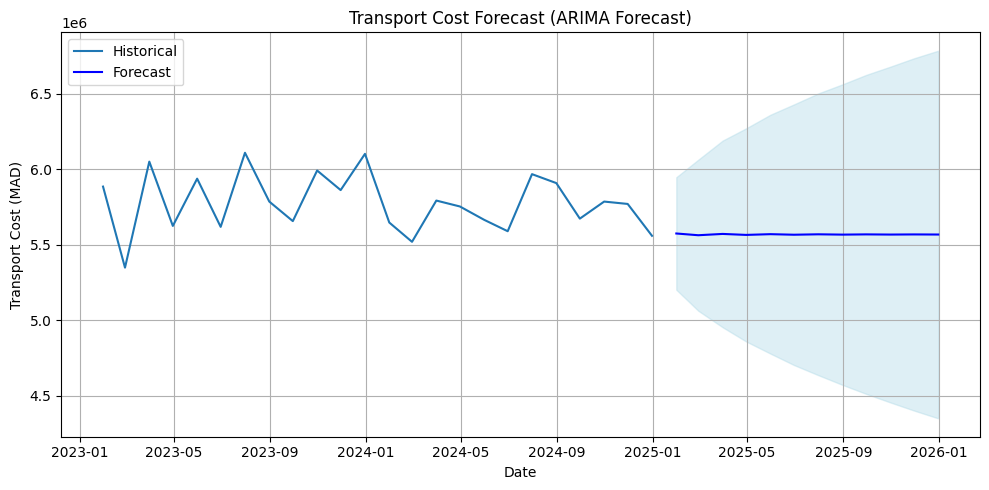

2025-01-31    5.575813e+06
2025-02-28    5.564281e+06
2025-03-31    5.572937e+06
2025-04-30    5.566440e+06
2025-05-31    5.571317e+06
2025-06-30    5.567656e+06
2025-07-31    5.570404e+06
2025-08-31    5.568341e+06
2025-09-30    5.569890e+06
2025-10-31    5.568727e+06
2025-11-30    5.569600e+06
2025-12-31    5.568945e+06
Freq: ME, Name: predicted_mean, dtype: float64

In [65]:
monthly_data = shippment_data.groupby(pd.Grouper(key='order_date', freq='M')).agg({
    'quantity_units': 'sum',
    'total_weight_kg': 'sum',
    'transport_cost_mad': 'sum'
}).reset_index()

def sarima_forecast(series_df, column='value', title='Forecast with SARIMA', ylabel='Value'):
    ts = series_df.set_index('order_date')[column]
    ts = ts.asfreq('MS')  # monthly start

    stepwise_model = auto_arima(ts, seasonal=True, m=12, trace=True, suppress_warnings=True,
                                 error_action='ignore', stepwise=True)

    best_order = stepwise_model.order
    best_seasonal_order = stepwise_model.seasonal_order

    sarima_model = SARIMAX(ts, order=best_order, seasonal_order=best_seasonal_order)
    sarima_results = sarima_model.fit(disp=False)

    forecast_steps = 12
    pred = sarima_results.get_forecast(steps=forecast_steps)
    forecast_index = pd.date_range(ts.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
    forecast_values = pred.predicted_mean
    conf_int = pred.conf_int()

    plt.figure(figsize=(10, 5))
    plt.plot(ts, label='Historical')
    plt.plot(forecast_index, forecast_values, label='Forecast', color='blue')
    plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='lightblue', alpha=0.4)
    plt.title(f"{title}")
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return forecast_values, best_order, best_seasonal_order

arima_forecast(monthly_data[['order_date', 'quantity_units']], title='Shipment Volumes Forecast', ylabel='Quantity Units')
arima_forecast(monthly_data[['order_date', 'total_weight_kg']], title='Total Weight Forecast', ylabel='Total Weight (kg)')
arima_forecast(monthly_data[['order_date', 'transport_cost_mad']], title='Transport Cost Forecast', ylabel='Transport Cost (MAD)')

<h2>LSTM </h2>

<h4> Quantity Units </h4>

C:\Users\hp\AppData\Local\Temp\ipykernel_6824\3110250733.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = shippment_data.groupby(pd.Grouper(key='order_date', freq='M')).agg({
C:\Users\hp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1936
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.1747
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1564
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.1389
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1219
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1058
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0908
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0770
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0648
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0546
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0472
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0429
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0421
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0444
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0482
Epoch 16/100
1/1 ━━

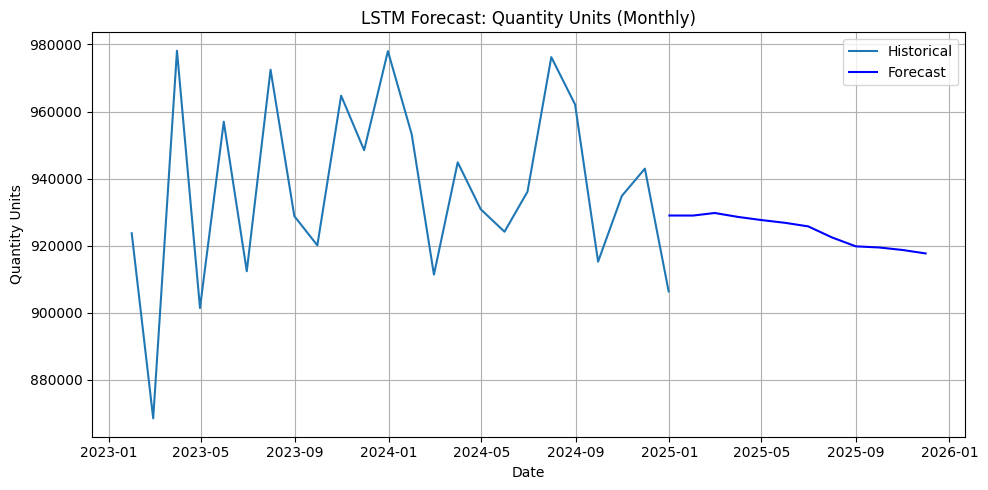

In [67]:
monthly_data = shippment_data.groupby(pd.Grouper(key='order_date', freq='M')).agg({
    'quantity_units': 'sum',
    'total_weight_kg': 'sum',
    'transport_cost_mad': 'sum'
}).reset_index()


scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(monthly_data[['quantity_units', 'total_weight_kg', 'transport_cost_mad']])


def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 12
X, y = create_sequences(scaled_data, window_size)


model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(units=3))  # 3 outputs for quantity, weight, cost
model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=100, verbose=1)


forecast_input = scaled_data[-window_size:]

forecast = []
for _ in range(12):  # 12 months
    input_reshaped = forecast_input[-window_size:].reshape(1, window_size, 3)
    pred = model.predict(input_reshaped)[0]
    forecast.append(pred)
    forecast_input = np.vstack([forecast_input, pred])


forecast = scaler.inverse_transform(forecast)
forecast_df = pd.DataFrame(forecast, columns=['quantity_units', 'total_weight_kg', 'transport_cost_mad'])
forecast_df['date'] = pd.date_range(start='2025-01-01', periods=12, freq='MS')


plt.figure(figsize=(10,5))
plt.plot(monthly_data['order_date'], monthly_data['quantity_units'], label='Historical')
plt.plot(forecast_df['date'], forecast_df['quantity_units'], label='Forecast', color='blue')
plt.title('LSTM Forecast: Quantity Units (Monthly)')
plt.xlabel("Date")
plt.ylabel("Quantity Units")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [69]:
monthly_quantity = shippment_data.groupby(pd.Grouper(key='order_date', freq='M'))['quantity_units'].sum().reset_index()

C:\Users\hp\AppData\Local\Temp\ipykernel_6824\3488587906.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_quantity = shippment_data.groupby(pd.Grouper(key='order_date', freq='M'))['quantity_units'].sum().reset_index()


In [71]:
# Scale to 0-1
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(monthly_quantity[['quantity_units']])

# Create sequences
def create_univariate_sequences(data, window=12):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window_size = 12
X, y = create_univariate_sequences(scaled_values, window=window_size)

# Reshape for LSTM: (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))


In [73]:
model = Sequential()
model.add(LSTM(units=100, activation='tanh', return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation='tanh'))
model.add(Dense(units=1))  # One output for univariate prediction

model.compile(optimizer='adam', loss='mse')

C:\Users\hp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [75]:
history = model.fit(X, y, epochs=150, batch_size=8, verbose=1)

Epoch 1/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.3627
Epoch 2/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1693
Epoch 3/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0533
Epoch 4/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0454
Epoch 5/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0723
Epoch 6/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0489
Epoch 7/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0295
Epoch 8/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0377
Epoch 9/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0381
Epoch 10/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0511
Epoch 11/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0497
Epoch 12/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0420
Epoch 13/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0382
Epoch 14/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0294
Epoch 15/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0363
Epoch 16/150
2/2 ━━

In [77]:
last_input = scaled_values[-window_size:].reshape(1, window_size, 1)
forecast_scaled = []

for _ in range(12):
    next_pred = model.predict(last_input)[0]
    forecast_scaled.append(next_pred)
    last_input = np.append(last_input[:, 1:, :], [[next_pred]], axis=1)

# Inverse scale
forecast_values = scaler.inverse_transform(forecast_scaled)
forecast_index = pd.date_range(start=monthly_quantity['order_date'].max() + pd.offsets.MonthBegin(1), periods=12, freq='MS')

forecast_df = pd.DataFrame({
    'date': forecast_index,
    'forecast_quantity_units': forecast_values.flatten()
})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


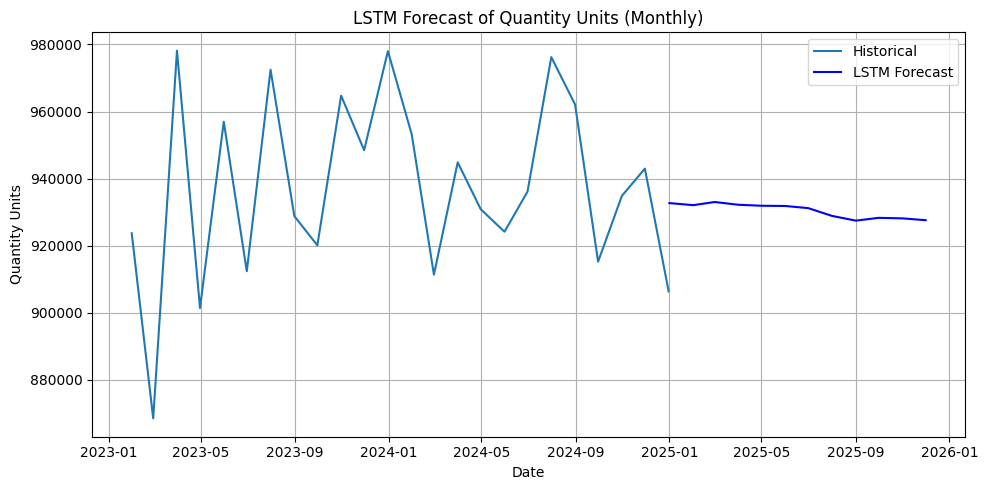

In [79]:
plt.figure(figsize=(10, 5))
plt.plot(monthly_quantity['order_date'], monthly_quantity['quantity_units'], label='Historical')
plt.plot(forecast_df['date'], forecast_df['forecast_quantity_units'], label='LSTM Forecast', color='blue')
plt.title("LSTM Forecast of Quantity Units (Monthly)")
plt.xlabel("Date")
plt.ylabel("Quantity Units")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<h4>Transport Costs</h4>

C:\Users\hp\AppData\Local\Temp\ipykernel_6824\22189983.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_cost = shippment_data.groupby(pd.Grouper(key='order_date', freq='M'))['transport_cost_mad'].sum().reset_index()
C:\Users\hp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.1987
Epoch 2/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0924
Epoch 3/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0349 
Epoch 4/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0495
Epoch 5/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0442
Epoch 6/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0300
Epoch 7/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0327
Epoch 8/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0359 
Epoch 9/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0267
Epoch 10/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0361
Epoch 11/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0364
Epoch 12/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0289
Epoch 13/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0318
Epoch 14/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0366 
Epoch 15/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0272
Epoch 16/150
2/

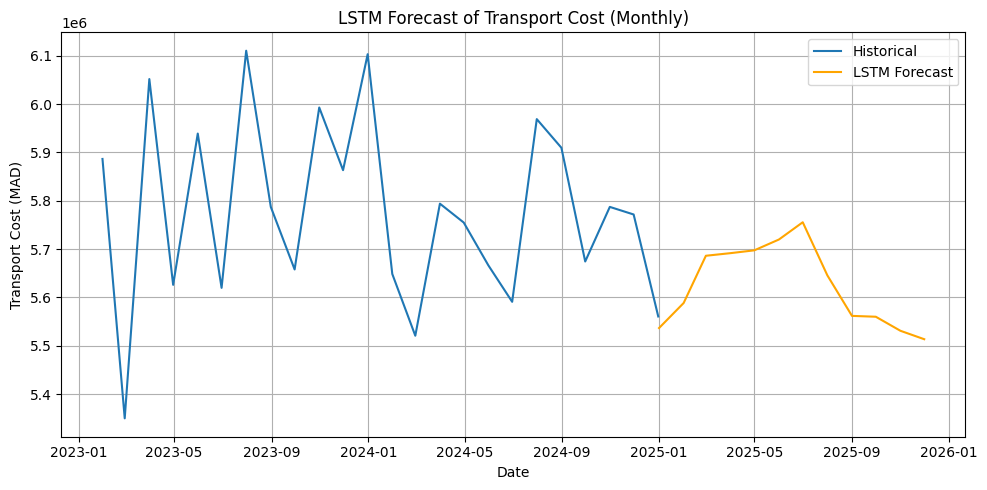

In [81]:
monthly_cost = shippment_data.groupby(pd.Grouper(key='order_date', freq='M'))['transport_cost_mad'].sum().reset_index()

scaler_cost = MinMaxScaler()
scaled_cost = scaler_cost.fit_transform(monthly_cost[['transport_cost_mad']])

def create_sequences(data, window=12):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window_size = 12
Xc, yc = create_sequences(scaled_cost, window_size)
Xc = Xc.reshape((Xc.shape[0], Xc.shape[1], 1))  # Reshape for LSTM


cost_model = Sequential([
    LSTM(100, activation='tanh', return_sequences=True, input_shape=(Xc.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, activation='tanh'),
    Dense(1)
])

cost_model.compile(optimizer='adam', loss='mse')

cost_model.fit(Xc, yc, epochs=150, batch_size=8, verbose=1)

last_input_c = scaled_cost[-window_size:].reshape(1, window_size, 1)
forecast_scaled_c = []

for _ in range(12):
    next_c = cost_model.predict(last_input_c)[0]
    forecast_scaled_c.append(next_c)
    last_input_c = np.append(last_input_c[:, 1:, :], [[next_c]], axis=1)

forecast_costs = scaler_cost.inverse_transform(forecast_scaled_c)

forecast_cost_dates = pd.date_range(start=monthly_cost['order_date'].max() + pd.offsets.MonthBegin(1), periods=12, freq='MS')
forecast_cost_df = pd.DataFrame({
    'date': forecast_cost_dates,
    'forecast_transport_cost_mad': forecast_costs.flatten()
})
plt.figure(figsize=(10, 5))
plt.plot(monthly_cost['order_date'], monthly_cost['transport_cost_mad'], label='Historical')
plt.plot(forecast_cost_df['date'], forecast_cost_df['forecast_transport_cost_mad'], label='LSTM Forecast', color='orange')
plt.title("LSTM Forecast of Transport Cost (Monthly)")
plt.xlabel("Date")
plt.ylabel("Transport Cost (MAD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<h4>Total Weight</h4>

C:\Users\hp\AppData\Local\Temp\ipykernel_6824\976961733.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_weight = shippment_data.groupby(pd.Grouper(key='order_date', freq='M'))['total_weight_kg'].sum().reset_index()
C:\Users\hp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.3589
Epoch 2/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2326
Epoch 3/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1057
Epoch 4/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0448
Epoch 5/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0787 
Epoch 6/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0724 
Epoch 7/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0637
Epoch 8/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0517
Epoch 9/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0521
Epoch 10/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0521
Epoch 11/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0709
Epoch 12/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0672
Epoch 13/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0620 
Epoch 14/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0388
Epoch 15/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0522
Epoch 16/150
2/2

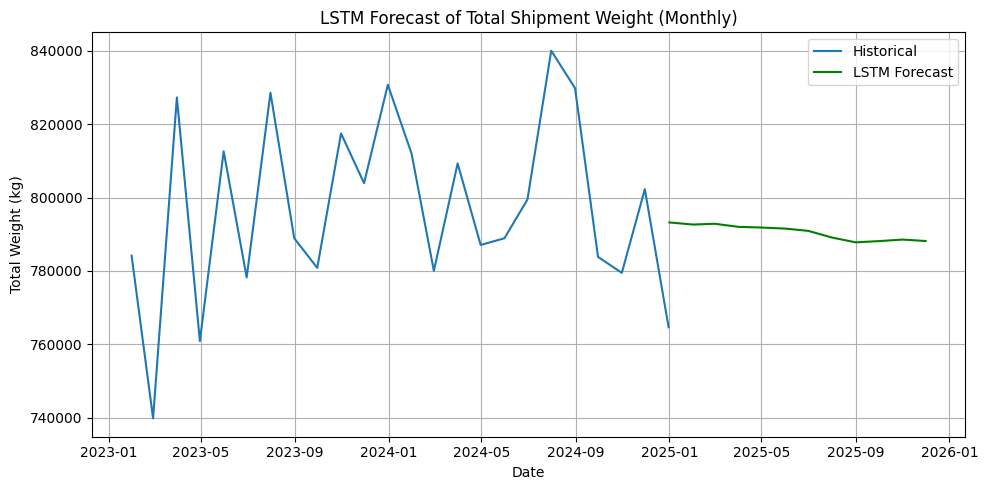

In [83]:
monthly_weight = shippment_data.groupby(pd.Grouper(key='order_date', freq='M'))['total_weight_kg'].sum().reset_index()

scaler_weight = MinMaxScaler()
scaled_weight = scaler_weight.fit_transform(monthly_weight[['total_weight_kg']])

def create_sequences(data, window=12):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window_size = 12
Xw, yw = create_sequences(scaled_weight, window_size)
Xw = Xw.reshape((Xw.shape[0], Xw.shape[1], 1))  # reshape for LSTM input


weight_model = Sequential([
    LSTM(100, activation='tanh', return_sequences=True, input_shape=(Xw.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, activation='tanh'),
    Dense(1)
])

weight_model.compile(optimizer='adam', loss='mse')

weight_model.fit(Xw, yw, epochs=150, batch_size=8, verbose=1)

last_input_w = scaled_weight[-window_size:].reshape(1, window_size, 1)
forecast_scaled_w = []

for _ in range(12):
    next_w = weight_model.predict(last_input_w)[0]
    forecast_scaled_w.append(next_w)
    last_input_w = np.append(last_input_w[:, 1:, :], [[next_w]], axis=1)

forecast_weights = scaler_weight.inverse_transform(forecast_scaled_w)

forecast_weight_dates = pd.date_range(start=monthly_weight['order_date'].max() + pd.offsets.MonthBegin(1), periods=12, freq='MS')
forecast_weight_df = pd.DataFrame({
    'date': forecast_weight_dates,
    'forecast_total_weight_kg': forecast_weights.flatten()
})

plt.figure(figsize=(10, 5))
plt.plot(monthly_weight['order_date'], monthly_weight['total_weight_kg'], label='Historical')
plt.plot(forecast_weight_df['date'], forecast_weight_df['forecast_total_weight_kg'], label='LSTM Forecast', color='green')
plt.title("LSTM Forecast of Total Shipment Weight (Monthly)")
plt.xlabel("Date")
plt.ylabel("Total Weight (kg)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<h4> Delivery Delay</h4>

C:\Users\hp\AppData\Local\Temp\ipykernel_6824\2393377456.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = shippment_data.groupby('actual_delivery_date')['delay_days'].mean().asfreq('D').fillna(method='ffill')
C:\Users\hp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


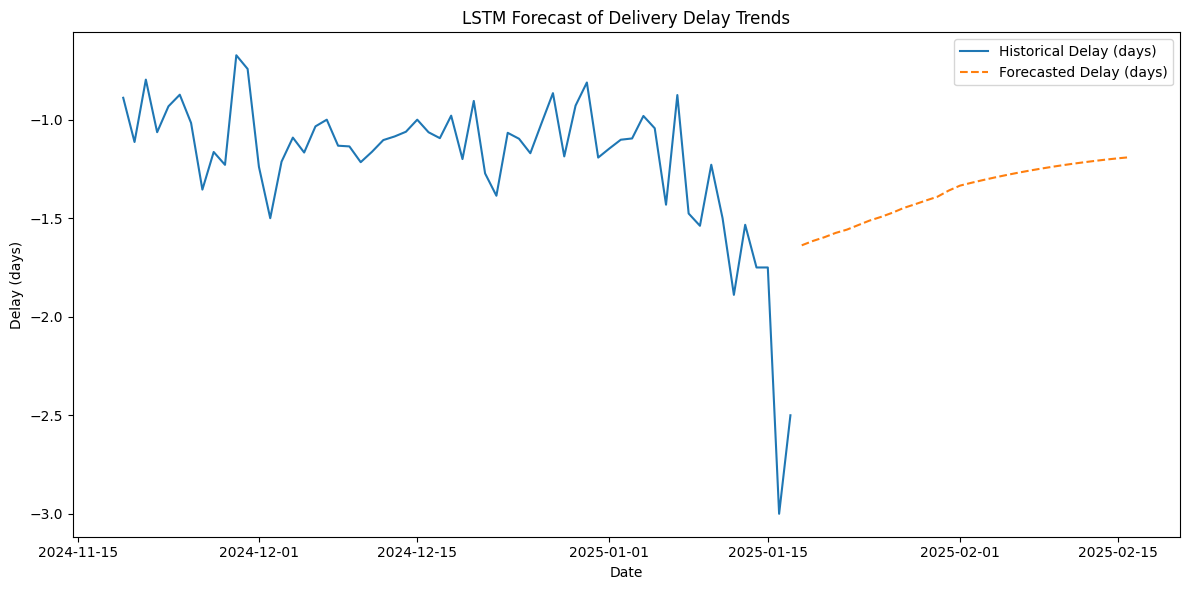

In [85]:
ts = shippment_data.groupby('actual_delivery_date')['delay_days'].mean().asfreq('D').fillna(method='ffill')

scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(ts.values.reshape(-1, 1))

def create_sequences(data, seq_len=14):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_ts)

model = Sequential([
    LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=20, batch_size=8, verbose=0)

# Forecast next 30 days
input_seq = scaled_ts[-14:].reshape(1, 14, 1)
forecast_scaled = []
for _ in range(30):
    pred = model.predict(input_seq, verbose=0)
    forecast_scaled.append(pred[0, 0])
    input_seq = np.append(input_seq[:, 1:, :], np.expand_dims(pred, axis=1), axis=1)

forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()

forecast_dates = pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=30)

plt.figure(figsize=(12, 6))
plt.plot(ts.index[-60:], ts.values[-60:], label='Historical Delay (days)')
plt.plot(forecast_dates, forecast, label='Forecasted Delay (days)', linestyle='--')
plt.title("LSTM Forecast of Delivery Delay Trends")
plt.xlabel("Date")
plt.ylabel("Delay (days)")
plt.legend()
plt.tight_layout()
plt.show()

Epoch 1/20


C:\Users\hp\AppData\Local\Temp\ipykernel_6824\4133504060.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = ts.fillna(method='ffill').fillna(0)
C:\Users\hp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0963
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0027
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0028
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0033
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0029
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0037
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0031
Epoch 9/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0028
Epoch 10/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0032
Epoch 11/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0035
Epoch 12/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0032
Epoch 13/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030
Epoch 14/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029
Epoch 15/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0031
Epoch 16/20
92/92 ━━━━━━━━━━━━

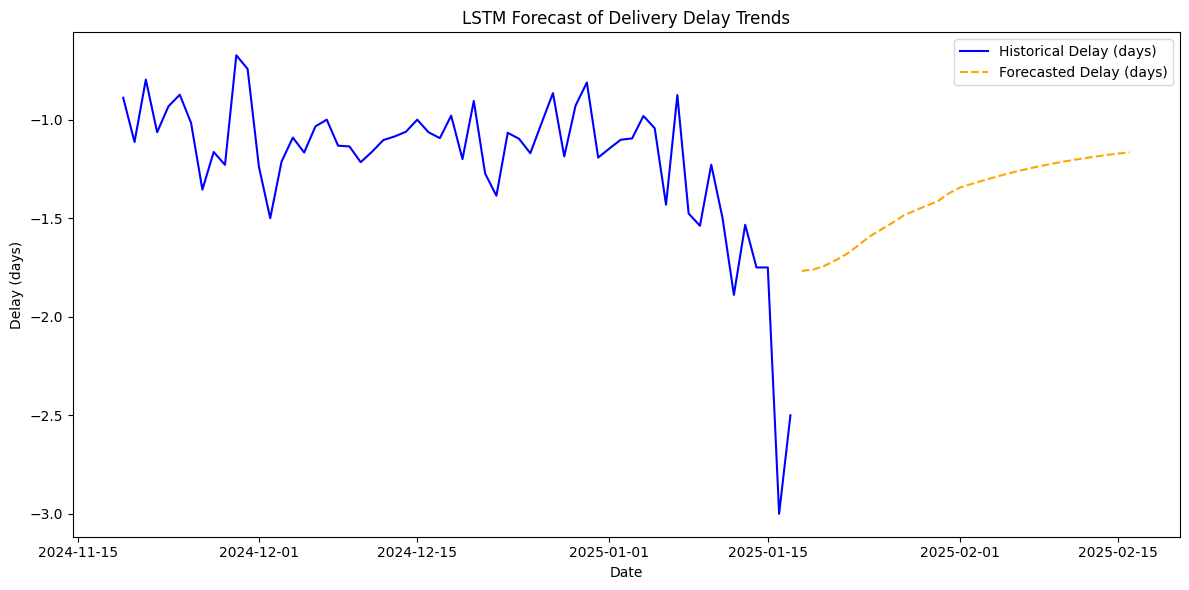

In [87]:
ts = shippment_data.groupby('actual_delivery_date')['delay_days'].mean().asfreq('D')
ts = ts.fillna(method='ffill').fillna(0)

scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(ts.values.reshape(-1, 1))

def create_sequences(data, seq_len=14):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_ts)

model = Sequential([
    LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=20, batch_size=8, verbose=1)

input_seq = scaled_ts[-14:].reshape(1, 14, 1)
forecast_scaled = []
for _ in range(30):
    pred = model.predict(input_seq, verbose=0)
    forecast_scaled.append(pred[0, 0])
    input_seq = np.append(input_seq[:, 1:, :], np.expand_dims(pred, axis=1), axis=1)

forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()
forecast_dates = pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=30)

plt.figure(figsize=(12, 6))
plt.plot(ts.index[-60:], ts.values[-60:], label='Historical Delay (days)', color='blue')
plt.plot(forecast_dates, forecast, label='Forecasted Delay (days)', linestyle='--', color='orange')
plt.title("LSTM Forecast of Delivery Delay Trends")
plt.xlabel("Date")
plt.ylabel("Delay (days)")
plt.legend()
plt.tight_layout()
plt.show()

In [210]:
shippment_data['delay_days'].describe()
shippment_data['delay_days'].sort_values(ascending=False).head(10)

14977    29
27757    29
8727     29
13302    29
12214    29
1772     29
33204    29
29551    29
34006    29
25865    28
Name: delay_days, dtype: int64

In [95]:
# Create output directory
os.makedirs("outputs", exist_ok=True)


#  Plot 1: Distribution of Truck Capacity
plt.figure(figsize=(10, 5))
sns.histplot(fleet_df['capacity_kg'], bins=10, kde=True, color='orange', edgecolor='black')
plt.title("Distribution of Truck Capacity (kg)")
plt.xlabel("Capacity (kg)")
plt.ylabel("Number of Trucks")
plt.tight_layout()
plt.savefig("outputs/capacity_distribution.png")
plt.close()

#  Plot 2: Number of Trucks by Year of Acquisition
plt.figure(figsize=(10, 5))
sns.countplot(data=fleet_df, x='year', order=sorted(fleet_df['year'].unique()), palette='Spectral')
plt.title("Number of Trucks by Year of Acquisition")
plt.xlabel("Year")
plt.ylabel("Truck Count")
plt.tight_layout()
plt.savefig("outputs/trucks_by_year.png")
plt.close()

#  Plot 3: Truck Capacity by Year (Boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(data=fleet_df, x='year', y='capacity_kg', palette='viridis')
plt.title("Truck Capacity by Year")
plt.xlabel("Year of Acquisition")
plt.ylabel("Capacity (kg)")
plt.tight_layout()
plt.savefig("outputs/capacity_by_year.png")
plt.close()

#  Plot 4: Shipment Capacity Utilization (%)
# Simulate truck assignment if not in shipment data
np.random.seed(42)
trips_df['truck_plate'] = np.random.choice(trips_df['truck_plate'], size=len(trips_df), replace=True)

# Merge to get truck capacity
merged = shipment_df.merge(carrier_df[['truck_plate', 'capacity_kg']], on='truck_plate', how='left')
merged['capacity_utilization_%'] = (merged['total_weight_kg'] / merged['capacity_kg']) * 100

# Plot
plt.figure(figsize=(10, 5))
sns.histplot(merged['capacity_utilization_%'], bins=30, kde=True, color='orange', edgecolor='black')
plt.title("Shipment Capacity Utilization (%)")
plt.xlabel("Utilization (%)")
plt.ylabel("Number of Shipments")
plt.tight_layout()
plt.savefig("outputs/utilization_distribution.png")
plt.close()

C:\Users\hp\AppData\Local\Temp\ipykernel_6824\494269251.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=fleet_df, x='year', order=sorted(fleet_df['year'].unique()), palette='Spectral')
C:\Users\hp\AppData\Local\Temp\ipykernel_6824\494269251.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=fleet_df, x='year', y='capacity_kg', palette='viridis')


NameError: name 'shipment_df' is not defined

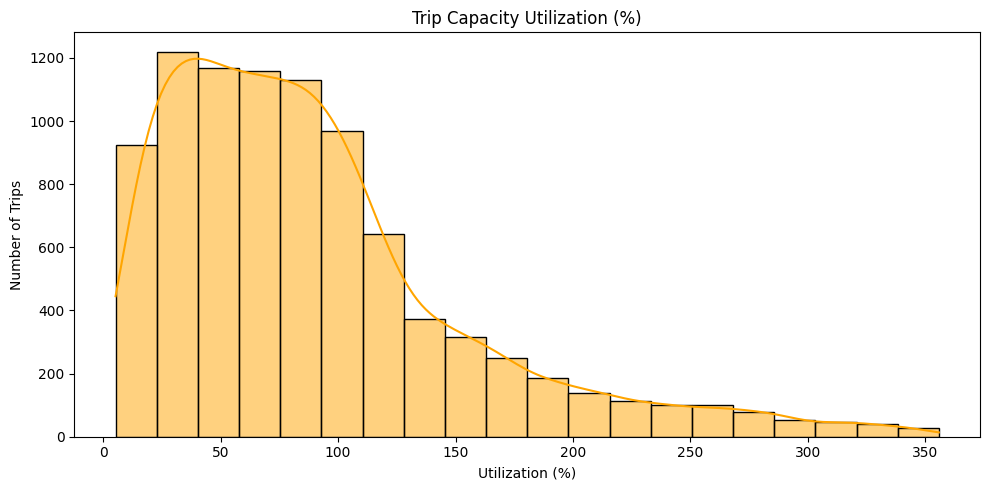

C:\Users\hp\AppData\Local\Temp\ipykernel_4360\401743407.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=trips_merged, x='status', y='capacity_utilization_%', palette='Set2')


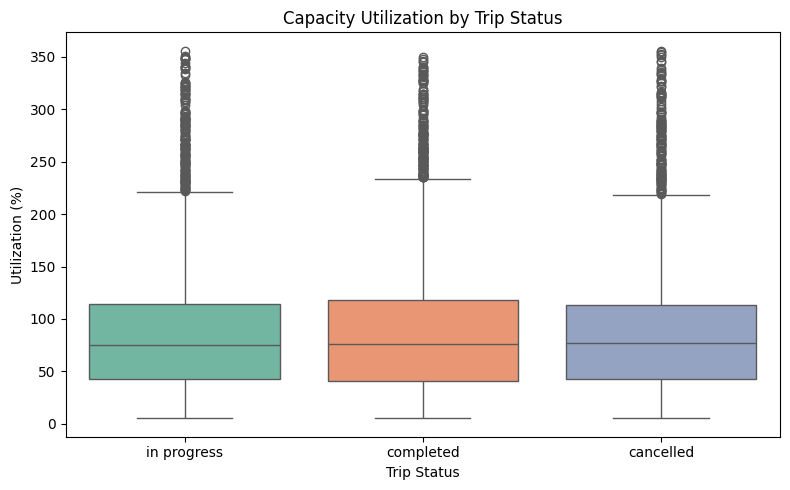

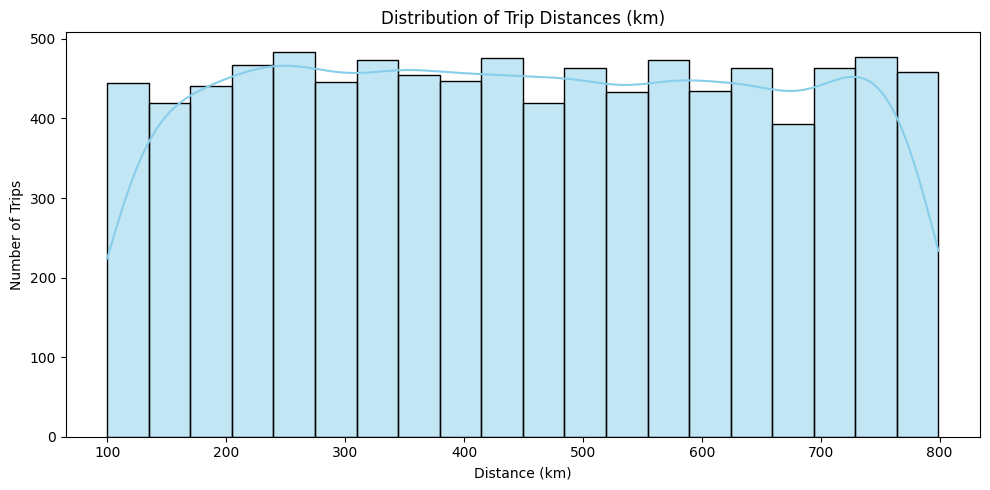

trip_id truck_plate  capacity_kg  load_kg  capacity_utilization_%  \
0  t000001     tr-0027         7978     2433               30.496365   
1  t000002     tr-0020         5137     3737               72.746739   
2  t000003     tr-0040        15763     5852               37.124913   
3  t000006     tr-0029        10433    15623              149.745998   
4  t000007     tr-0022         5917     6756              114.179483   

        status  
0  in progress  
1  in progress  
2  in progress  
3    completed  
4  in progress

In [9]:
os.makedirs("outputs", exist_ok=True)

fleet_df = carrier_data['Fleet']
trips_merged = trips_df.merge(fleet_df[['truck_plate', 'capacity_kg']], on='truck_plate', how='left')

trips_merged['capacity_utilization_%'] = (trips_merged['load_kg'] / trips_merged['capacity_kg']) * 100

plt.figure(figsize=(10, 5))
sns.histplot(trips_merged['capacity_utilization_%'], bins=20, kde=True, color='orange', edgecolor='black')
plt.title("Trip Capacity Utilization (%)")
plt.xlabel("Utilization (%)")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.savefig("outputs/trip_utilization_distribution.png")
plt.show()
plt.close()

plt.figure(figsize=(8, 5))
sns.boxplot(data=trips_merged, x='status', y='capacity_utilization_%', palette='Set2')
plt.title("Capacity Utilization by Trip Status")
plt.ylabel("Utilization (%)")
plt.xlabel("Trip Status")
plt.tight_layout()
plt.savefig("outputs/utilization_by_status.png")
plt.show()
plt.close()

plt.figure(figsize=(10, 5))
sns.histplot(trips_merged['distance_km'], bins=20, kde=True, color='skyblue', edgecolor='black')
plt.title("Distribution of Trip Distances (km)")
plt.xlabel("Distance (km)")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.savefig("outputs/trip_distance_distribution.png")
plt.show()
plt.close()

trips_merged[['trip_id', 'truck_plate', 'capacity_kg', 'load_kg', 'capacity_utilization_%', 'status']].head()

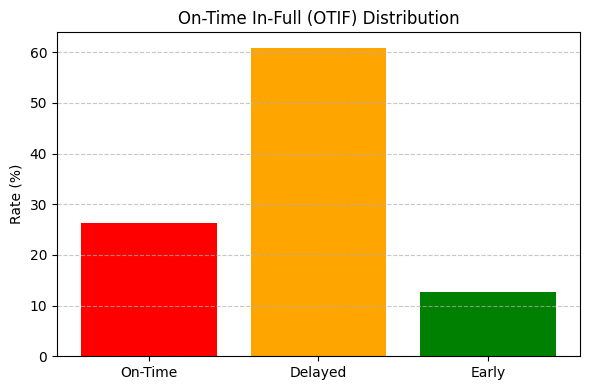

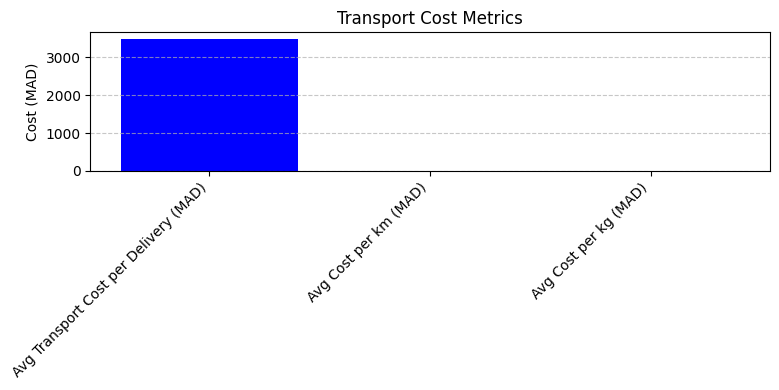

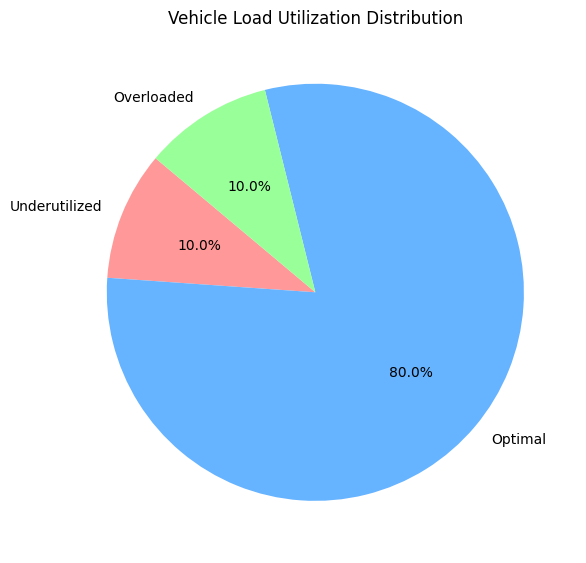

Utilization Type  Percentage
0    Underutilized          10
1          Optimal          80
2       Overloaded          10

In [46]:
data_otif = {
    'Delivery Type': ['On-Time', 'Delayed', 'Early'],
    'Rate (%)': [26.36, 60.87, 12.77]
}
df_otif = pd.DataFrame(data_otif)

data_costs = {
    'Metric': ['Avg Transport Cost per Delivery (MAD)', 'Avg Cost per km (MAD)', 'Avg Cost per kg (MAD)'],
    'Value': [3485.16, 8.12, 0.85]
}
df_costs = pd.DataFrame(data_costs)

data_utilization = {
    'Utilization Type': ['Underutilized', 'Optimal', 'Overloaded'],
    'Percentage': [10, 80, 10]
}
df_utilization = pd.DataFrame(data_utilization)

plt.figure(figsize=(6, 4))
plt.bar(df_otif['Delivery Type'], df_otif['Rate (%)'], color=['red', 'orange', 'green'])
plt.title('On-Time In-Full (OTIF) Distribution')
plt.ylabel('Rate (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
data_otif

plt.figure(figsize=(8, 4))
plt.bar(df_costs['Metric'], df_costs['Value'], color='blue')
plt.title('Transport Cost Metrics')
plt.ylabel('Cost (MAD)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
df_costs

plt.figure(figsize=(6, 6))
plt.pie(df_utilization['Percentage'], labels=df_utilization['Utilization Type'],
        autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Vehicle Load Utilization Distribution')
plt.tight_layout()
plt.show()

df_utilization

In [17]:
df_otif

Delivery Type  Rate (%)
0       On-Time     26.36
1       Delayed     60.87
2         Early     12.77

In [25]:
df_costs

Metric    Value
0  Avg Transport Cost per Delivery (MAD)  3485.16
1                  Avg Cost per km (MAD)     8.12
2                  Avg Cost per kg (MAD)     0.85